# Exploring TensorFlow Probability STS Forecasting

In this notebook we explore the [Structural Time Series (STS) Module](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) of [TensorFlow Probability](https://www.tensorflow.org/probability/). We follow closely the [use cases](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) presented in their [Medium blog](https://medium.com/tensorflow). As described there: *An STS model expresses an observed time series as the sum of simpler components*: 

$$
f(t) = \sum_{k=1}^{N}f_{k}(t) + \varepsilon, \quad \text{where}\quad \varepsilon \sim N(0, \sigma^2).
$$

Each summand $f_{k}(t)$ has a particular structure, e.g. specific seasonality, trend, autoregressive terms, etc.  

In this notebook we generate a time series sample and then present some techniques to recover its component structure. This is indeed a crucial step since in real applications we are not given the components separately. We then show how to fit and generate predictions using [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). Finally we run some diagnostics of the errors on the test set. 

## Prepare Notebook

In [1]:
import arviz as az
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.ndimage import gaussian_filter
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import signal

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

2023-11-09 10:51:11.463437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed: int = 0
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
print(tf.__version__)
print(tfp.__version__)

2.14.0
0.22.1


## Generate Data

We are going to generate daily data on the range `2017-01-01` to `2020-12-31`.

In [4]:
# Create dataframe with a date range (4 years).
date_range = pd.date_range(start="2017-01-01", end="2020-12-31", freq="D")
# Create data frame.
df = pd.DataFrame(data={"date": date_range})
# Extract number of points.
n = df.shape[0]

We begin with Gaussian noise. 

In [5]:
df["y"] = rng.normal(loc=0.0, scale=0.5, size=n)

Next we define an external regressor `x`.

In [6]:
# External regressor:
df["x"] = rng.uniform(low=0.0, high=1.0, size=n)
df["x"] = df["x"].apply(lambda x: x if abs(x) > 0.95 else 0.0)

df["y"] = df["y"] + 6 * df["x"]

In [7]:
df["x"] = df["x"].astype(np.float32)
df["y"] = df["y"].astype(np.float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1461 non-null   datetime64[ns]
 1   y       1461 non-null   float32       
 2   x       1461 non-null   float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 23.0 KB


[Text(0.5, 1.0, 'External Regressor $x$')]

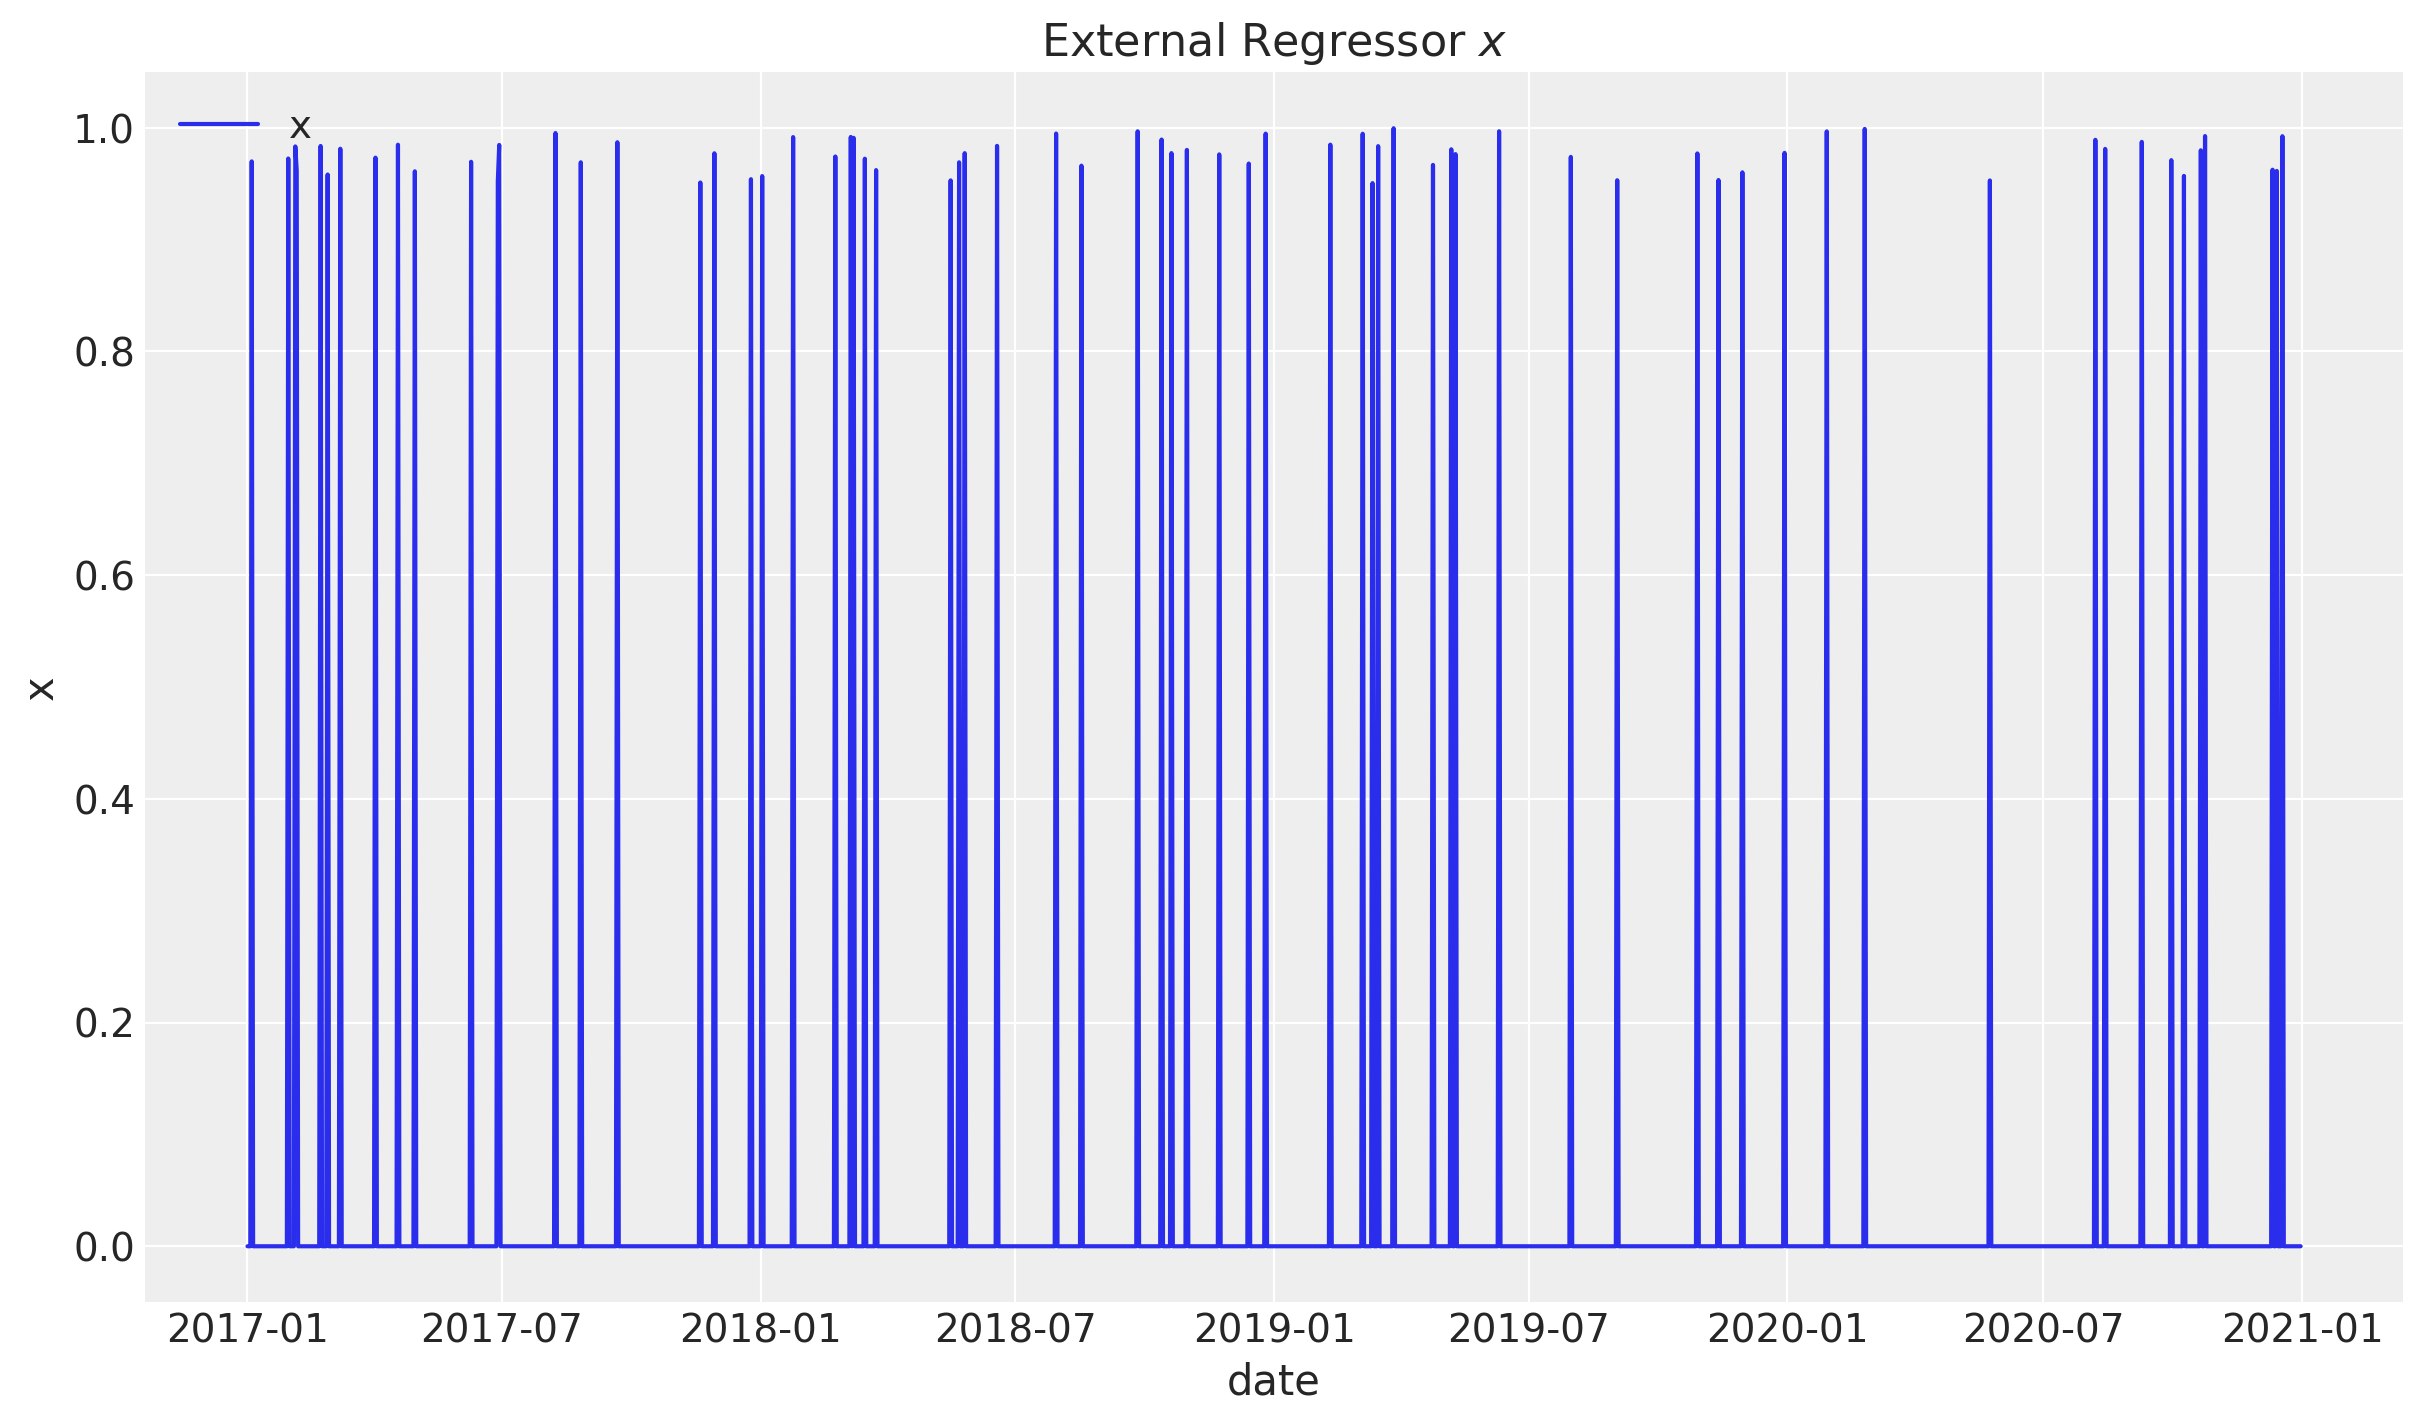

In [8]:
plt.rcParams["figure.figsize"] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x="date", y="x", label="x", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title=r"External Regressor $x$")

Now, let us add a non-linear trend component of the form $t\longmapsto t^{1/3}$.

In [9]:
df["y"] = df["y"] + np.power(df.index.values, 1 / 3)

Finally, we add some seasonal variables, which we encode as cyclic variables using $\sin(z)$ and $\cos(z)$ functions.

In [10]:
# Seasonal features:
df["day_of_month"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["day_of_week"] = df["date"].dt.dayofweek
df["daysinmonth"] = df["date"].dt.daysinmonth


df["y"] = (
    df["y"]
    + 2 * np.cos(2 * np.pi * df["month"] / 12)
    + 0.5 * np.sin(2 * np.pi * df["month"] / 12)
    + 1.5 * np.cos(2 * np.pi * df["day_of_week"] / 7)
    + 2 * np.sin(2 * np.pi * df["day_of_month"] / df["daysinmonth"])
)

df["y"] = df["y"].bfill().astype(np.float32)

df.head(10)

date          y         x  day_of_month  month  day_of_week  \
0 2017-01-01   3.382748  0.000000             1      1            6   
1 2017-01-02   5.204710  0.000000             2      1            0   
2 2017-01-03   5.639954  0.000000             3      1            1   
3 2017-01-04  10.412126  0.969928             4      1            2   
4 2017-01-05   3.647452  0.000000             5      1            3   
5 2017-01-06   4.396875  0.000000             6      1            4   
6 2017-01-07   6.094326  0.000000             7      1            5   
7 2017-01-08   7.301190  0.000000             8      1            6   
8 2017-01-09   7.066338  0.000000             9      1            0   
9 2017-01-10   6.160268  0.000000            10      1            1   

   daysinmonth  
0           31  
1           31  
2           31  
3           31  
4           31  
5           31  
6           31  
7           31  
8           31  
9           31

Let us plot the generated data:

[Text(0.5, 1.0, 'Dependent Variable')]

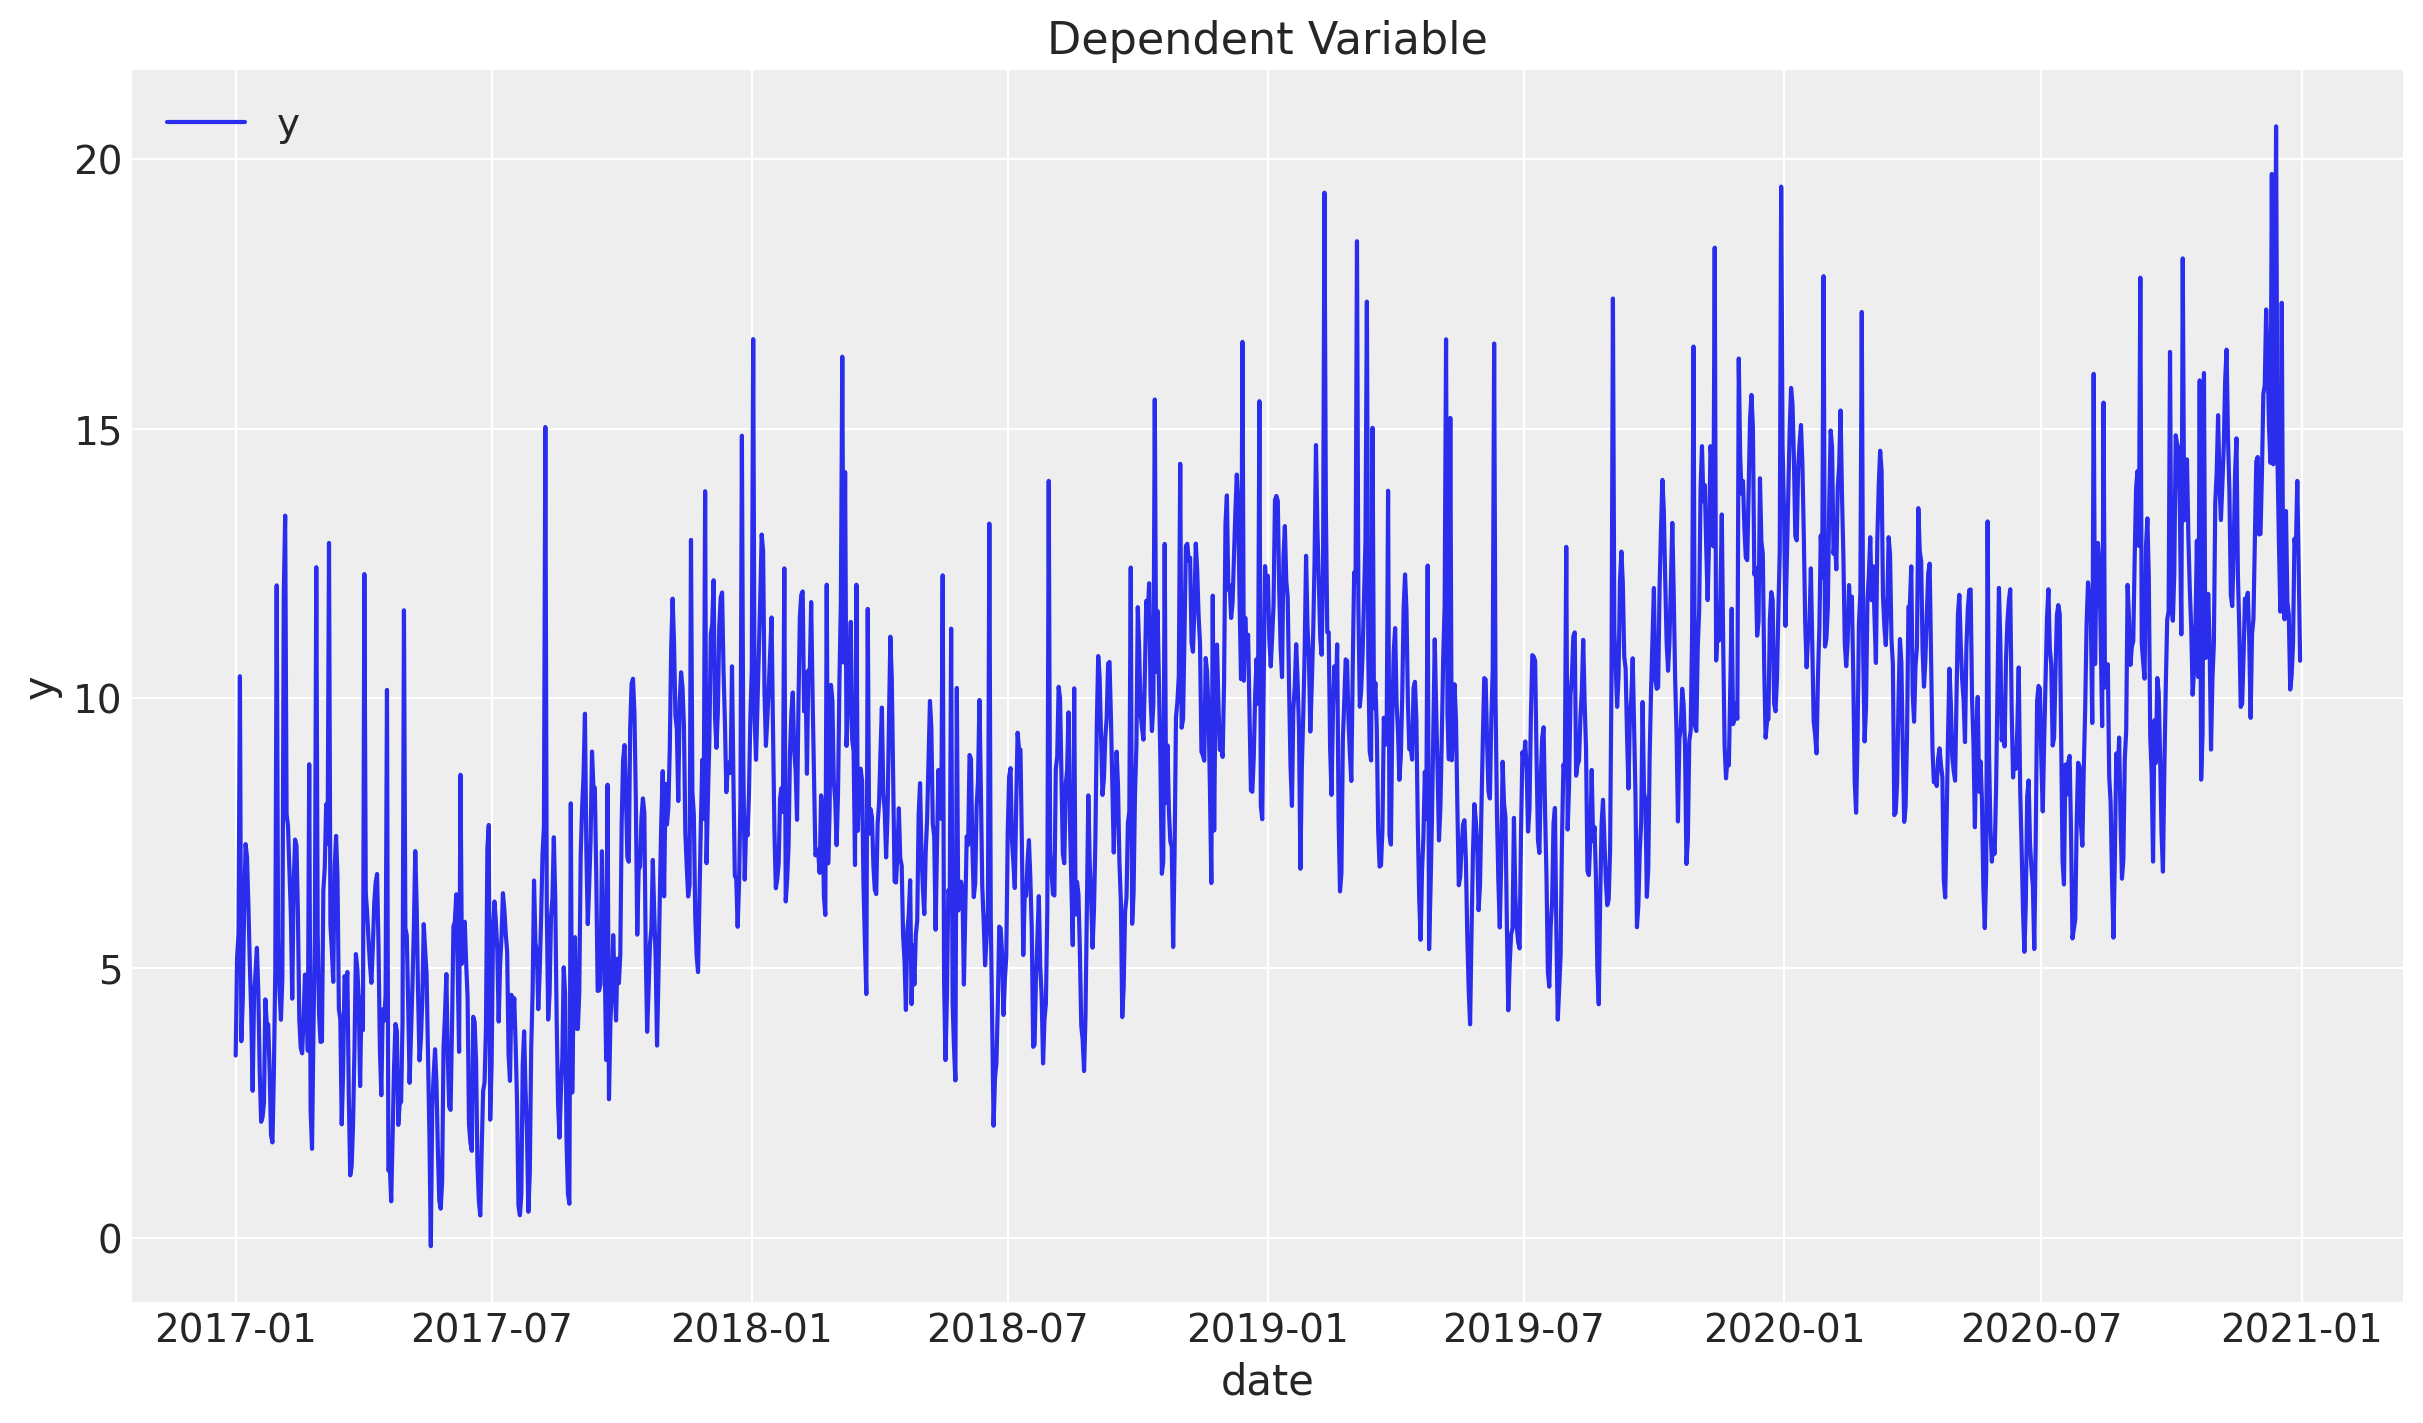

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Dependent Variable")

## Train - Test Split

We assume we have data until `2020-06-30` and we will predict six months ahead. We assume we have access to the `x` variable in advance (e.g. media spend plan). 

In [12]:
threshold_date = pd.to_datetime("2020-07-01")
mask = df["date"] < threshold_date

df_train = df[mask]
df_test = df[~mask]

[Text(0.5, 1.0, 'Dependent Variable')]

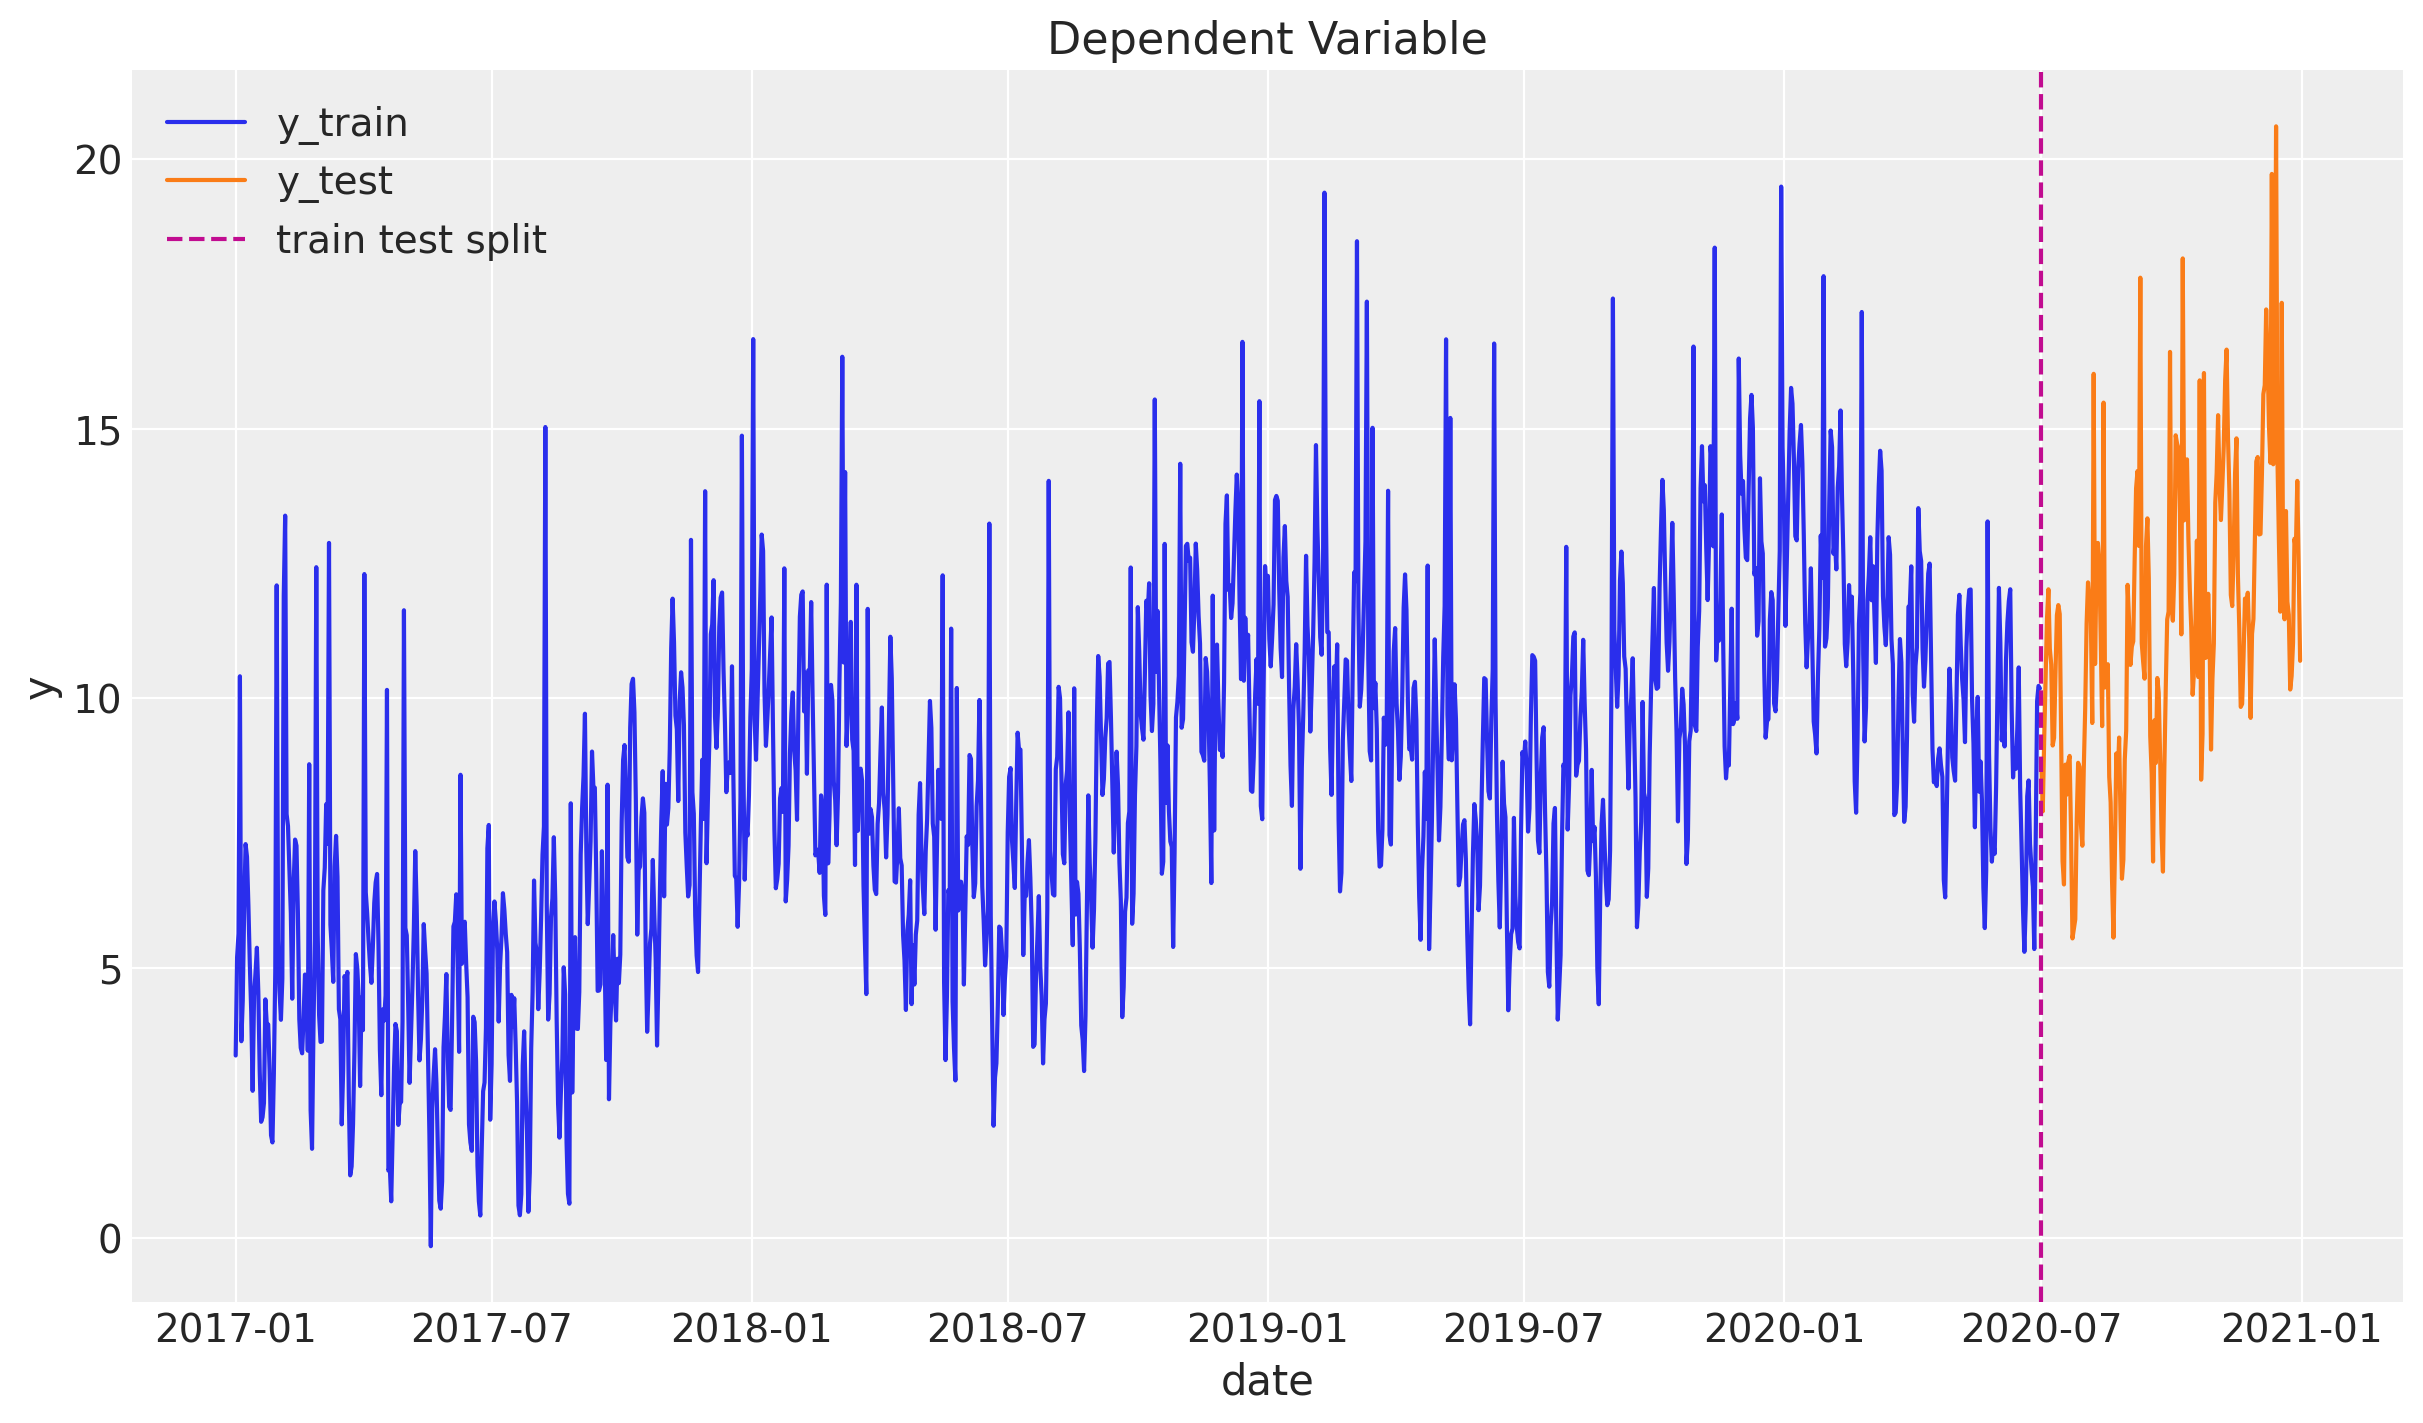

In [13]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y_train", data=df_train, ax=ax)
sns.lineplot(x="date", y="y", label="y_test", data=df_test, ax=ax)
ax.axvline(threshold_date, color="C3", linestyle="--", label="train test split")
ax.legend(loc="upper left")
ax.set(title="Dependent Variable")

## Time Series Exploratory Analysis

We are going to assume we do not know how the data was generated. We present a sample of techniques to extract the seasonality and estimate the effect of the `x` variable on `y`. There is no unique way to do this and we focus on using the intuition and common sense to extract the relevant features. Time series forecasting can be a very challenging problem. Spending time on exploring the data is always a good investment in order to generate meaningful models. 

**Warning:** We just use the training data in this step so that we do not leak information from the test set. 

### Smoothing

We begin the analysis by studying and visualize various level of smoothness using a [`gaussian_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html). You can think of it as a weighted centered moving average based on a normal distribution. In particular, the level of smoothness is controlled by the parameter `sigma` which represents the standard deviation.

[Text(0.5, 1.0, 'Dependent Variable - Smoothing'), Text(0, 0.5, 'y')]

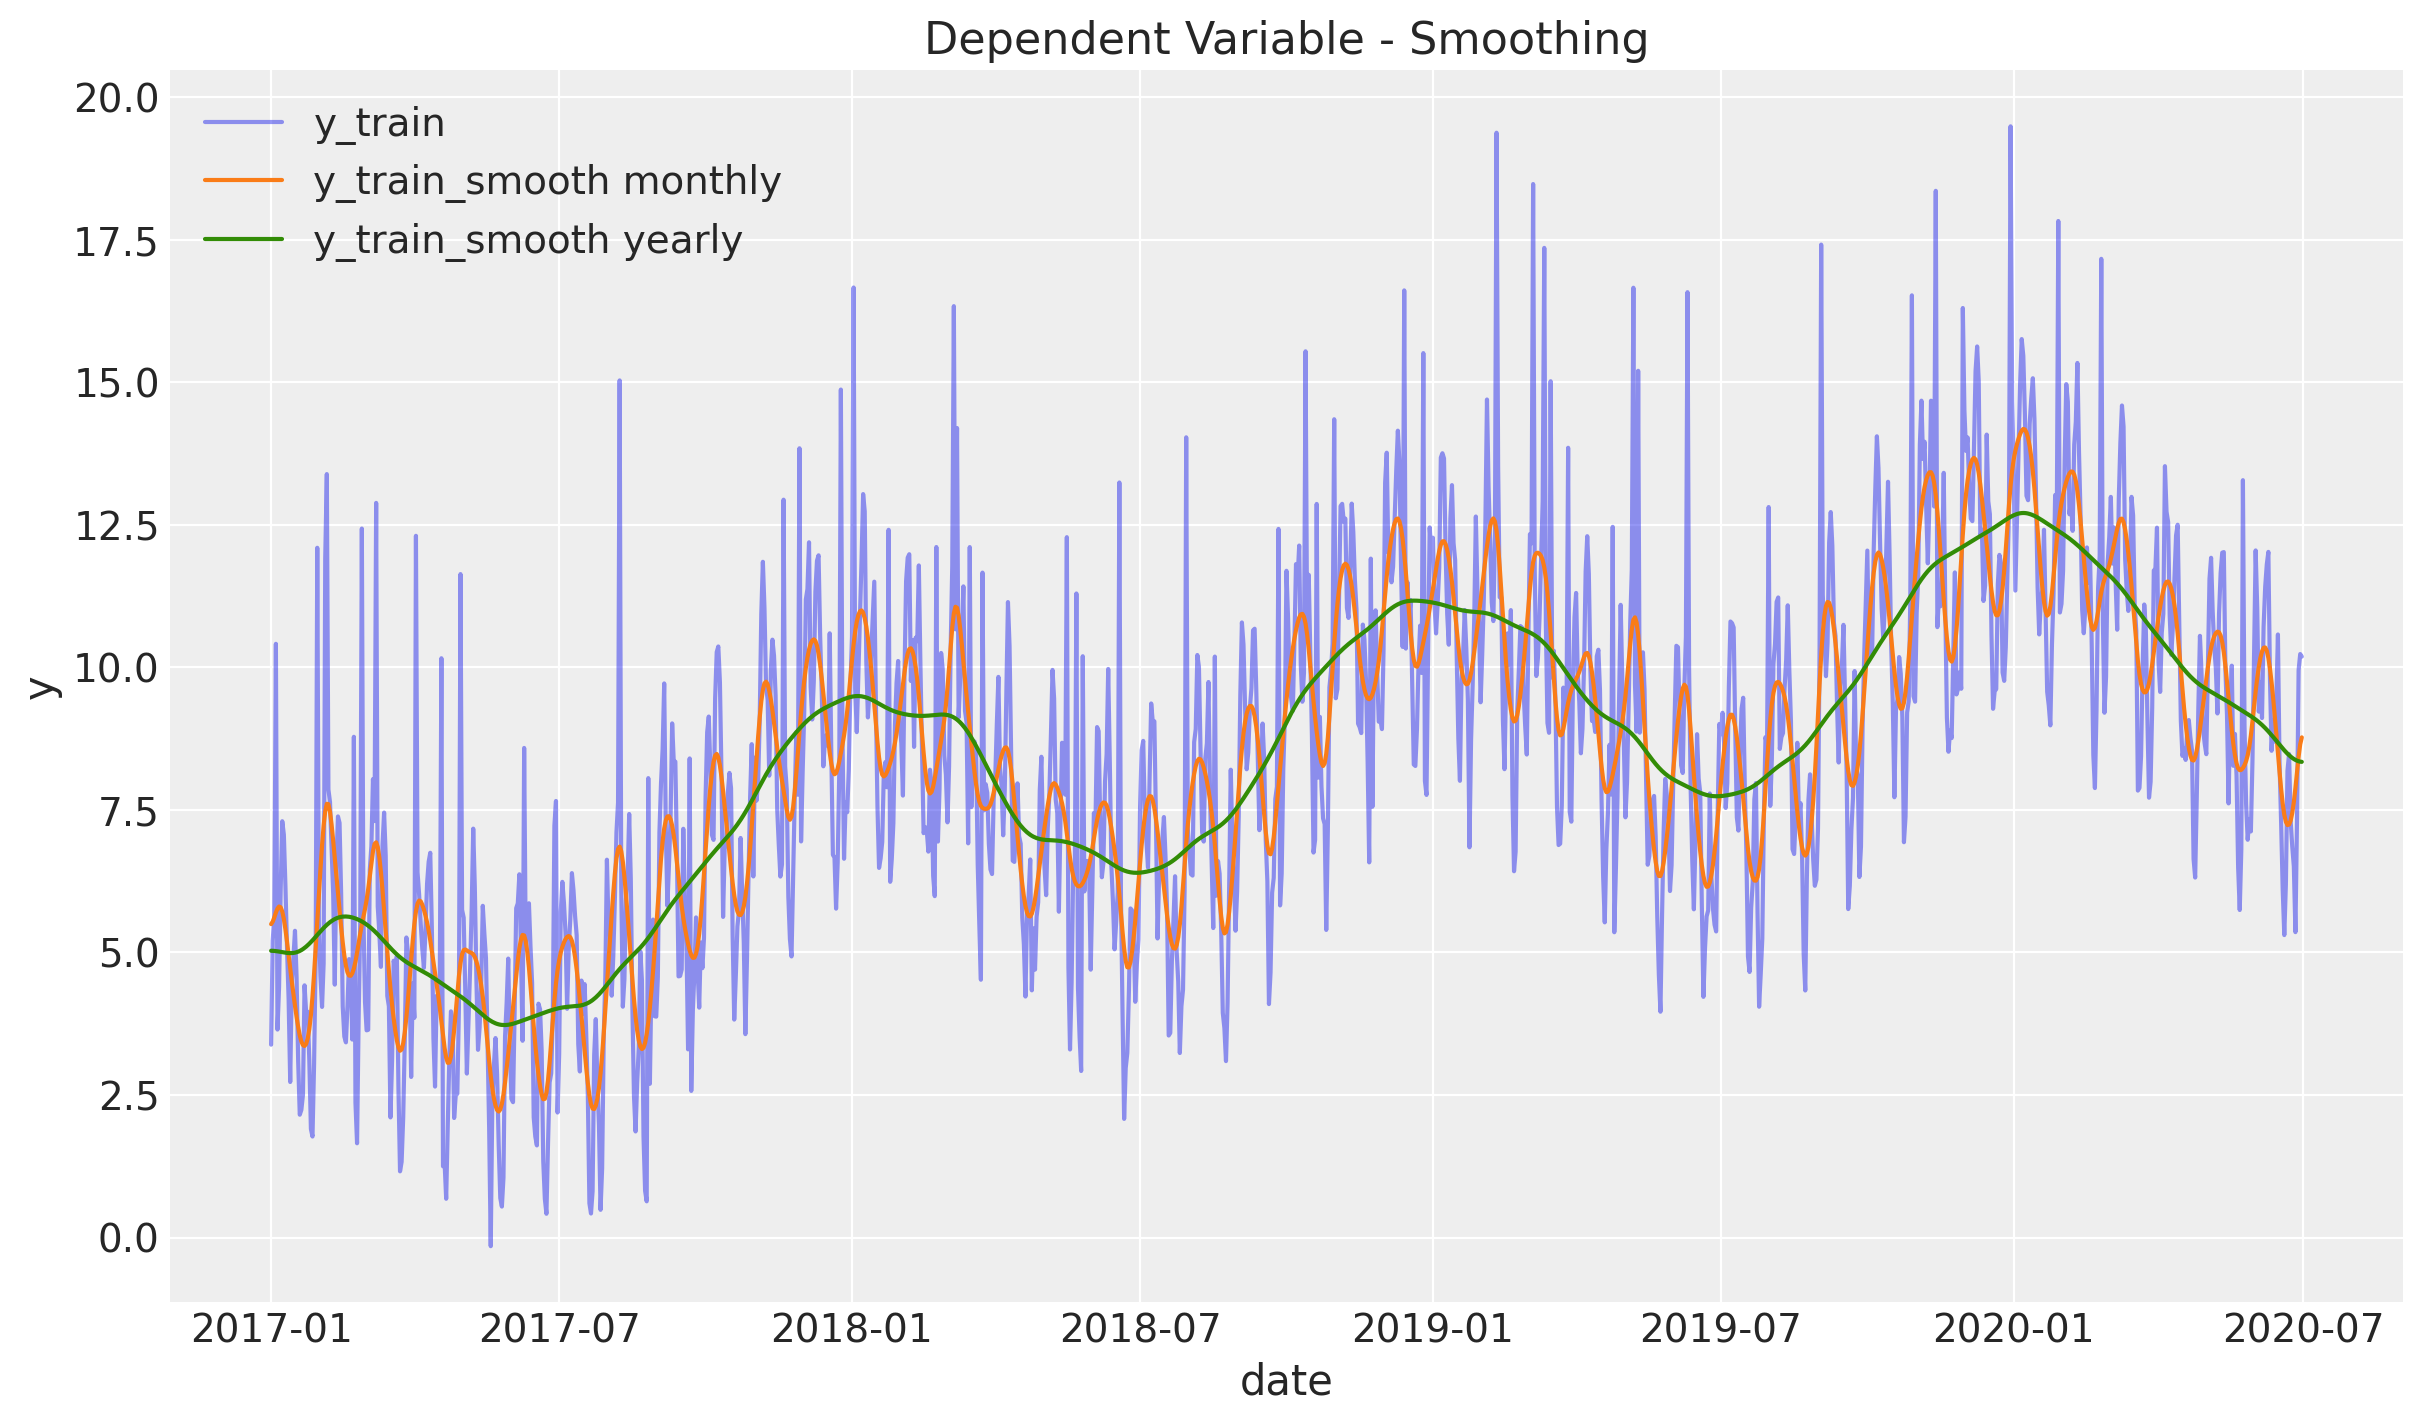

In [14]:
df_smooth = df_train.assign(
    y_smooth_1=lambda x: gaussian_filter(input=x["y"], sigma=3.5)
).assign(y_smooth_2=lambda x: gaussian_filter(input=x["y"], sigma=15))
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y_train", data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(
    x="date", y="y_smooth_1", label="y_train_smooth monthly", data=df_smooth, ax=ax
)
sns.lineplot(
    x="date", y="y_smooth_2", label="y_train_smooth yearly", data=df_smooth, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Dependent Variable - Smoothing", ylabel="y")

From this plot we see two clear seasonalities: yearly and monthly. The variable `y_train_smooth yearly` also includes a positive trend component, which does not look linear. 

To understand how to model the monthly seasonality we plot the mean of `y` over the day of the month. 

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_71423/1625365891.py:2: FutureWarning: The provided callable <function mean at 0x10dd7cc20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_train.groupby("day_of_month").agg({"y": np.mean}).plot(ax=ax)


[Text(0.5, 1.0, 'Day of the month mean')]

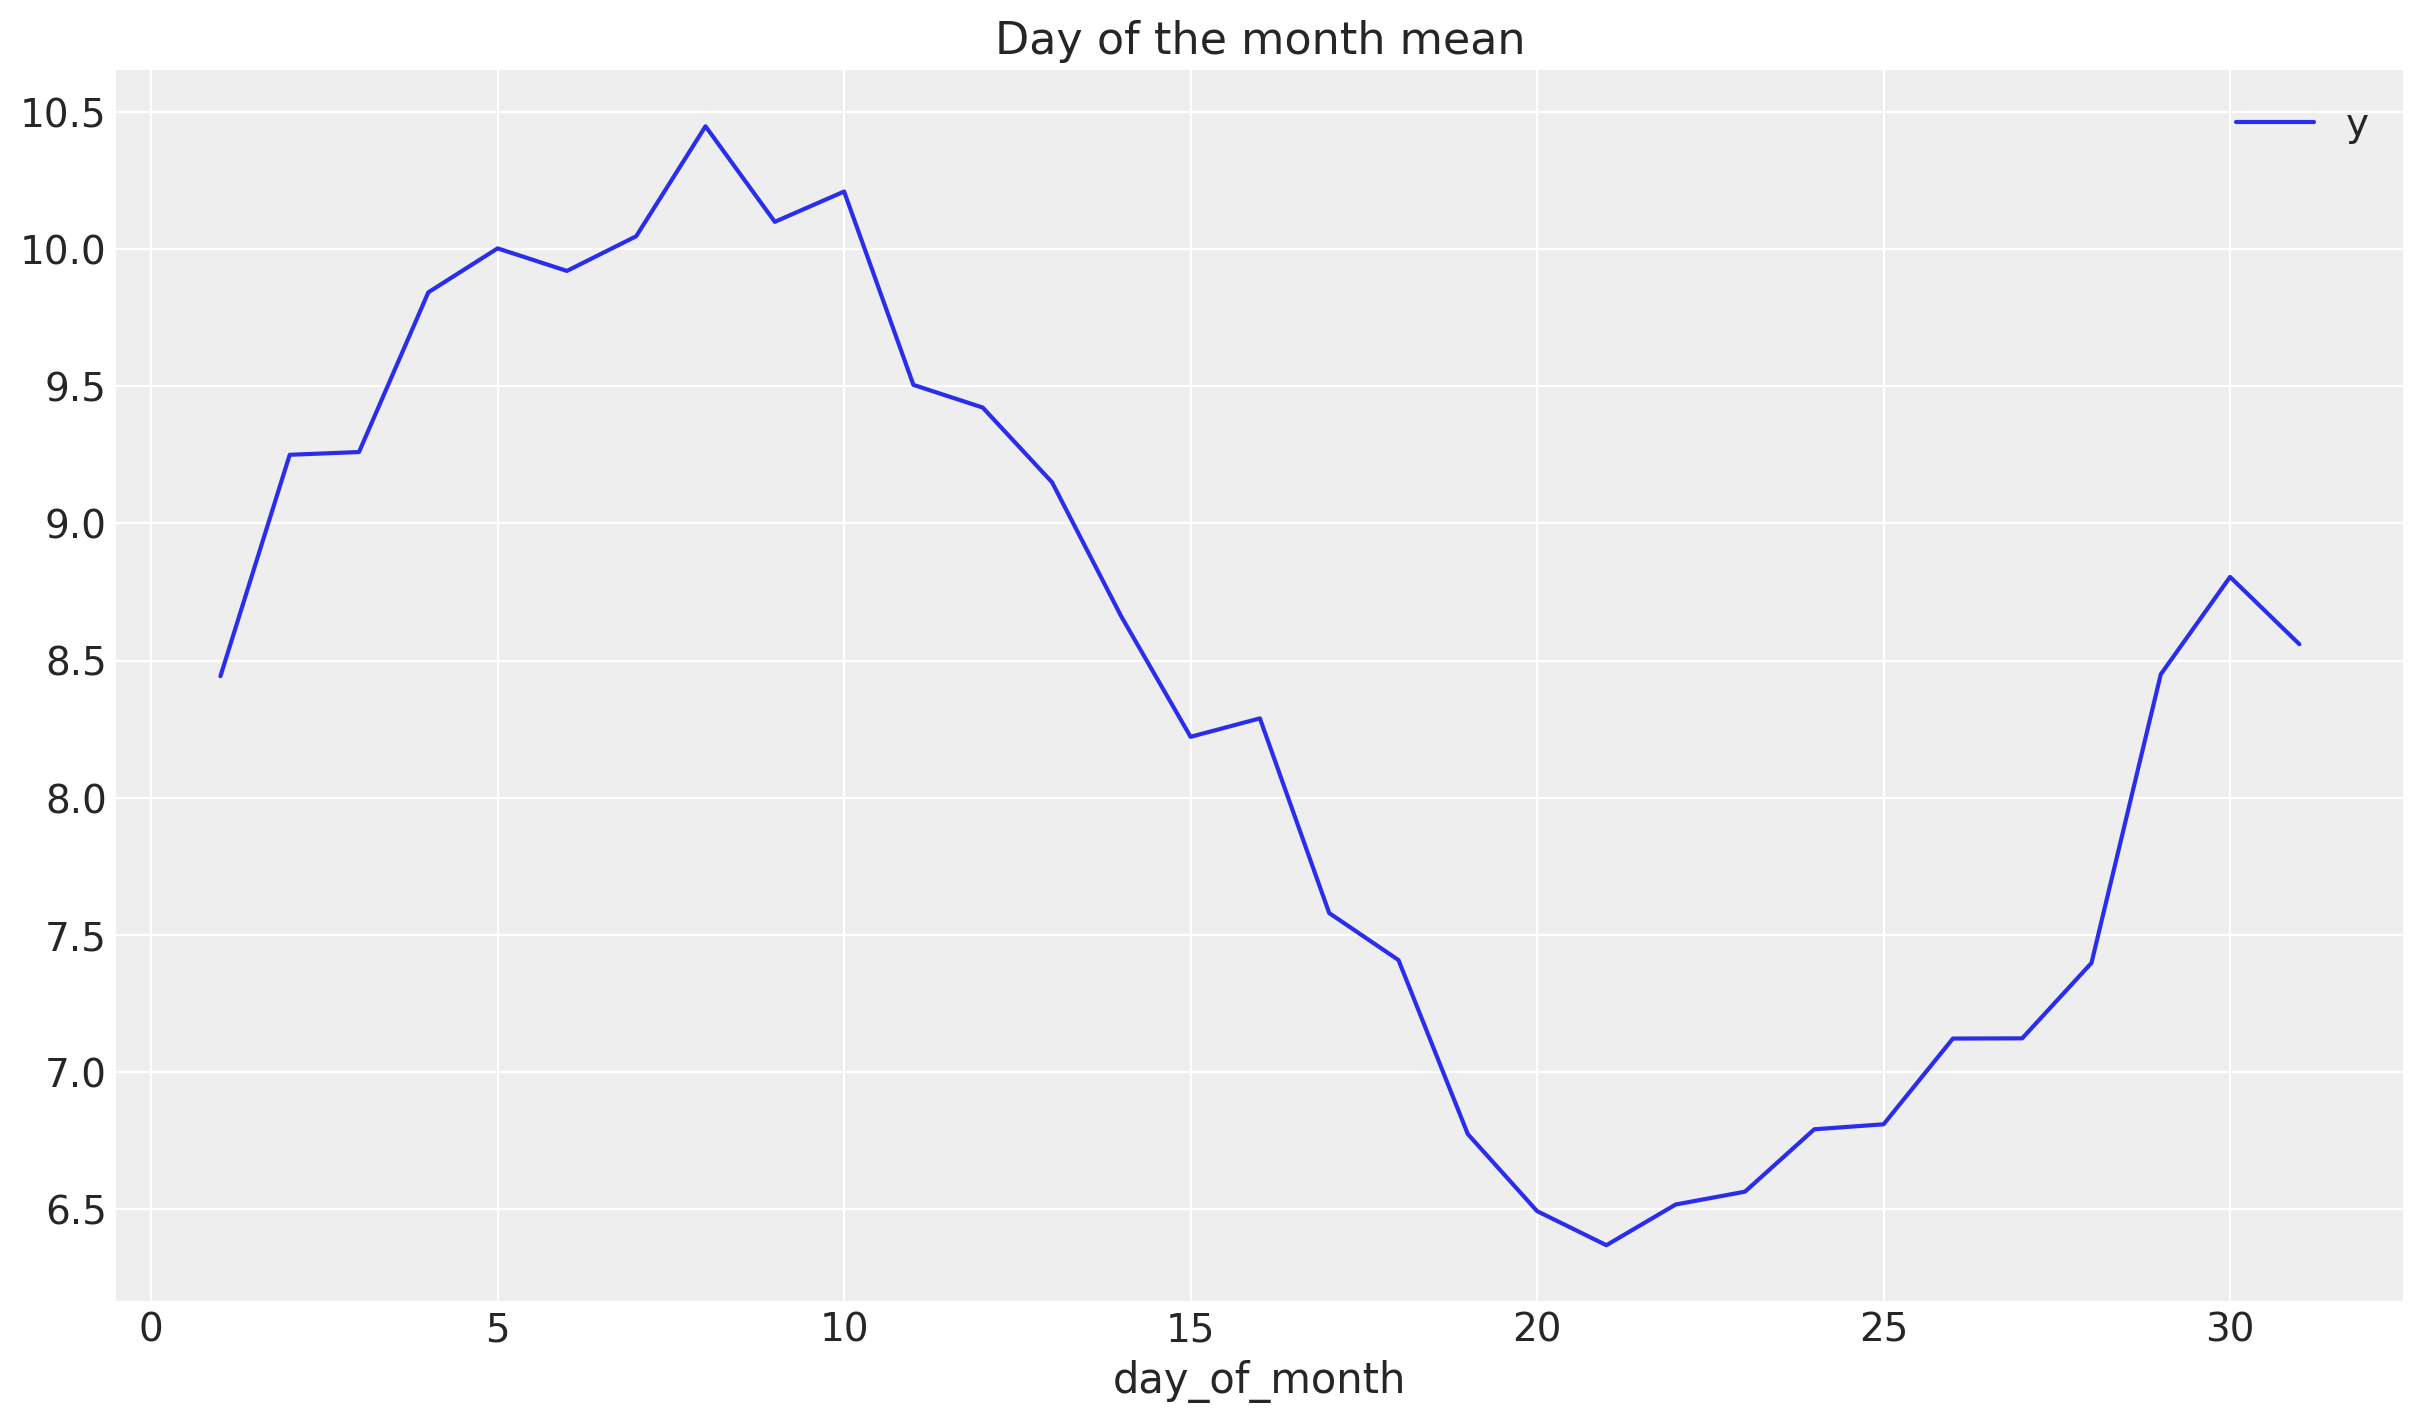

In [15]:
fig, ax = plt.subplots()
df_train.groupby("day_of_month").agg({"y": np.mean}).plot(ax=ax)
ax.set(title="Day of the month mean")

This shows a good first approximation is to model this component via a cyclic variable of the form $z\longmapsto \sin(z)$.

### Remove yearly and monthly seasonality

Let us remove these two seasonal components:

[Text(0.5, 1.0, 'y no year & month seasonality')]

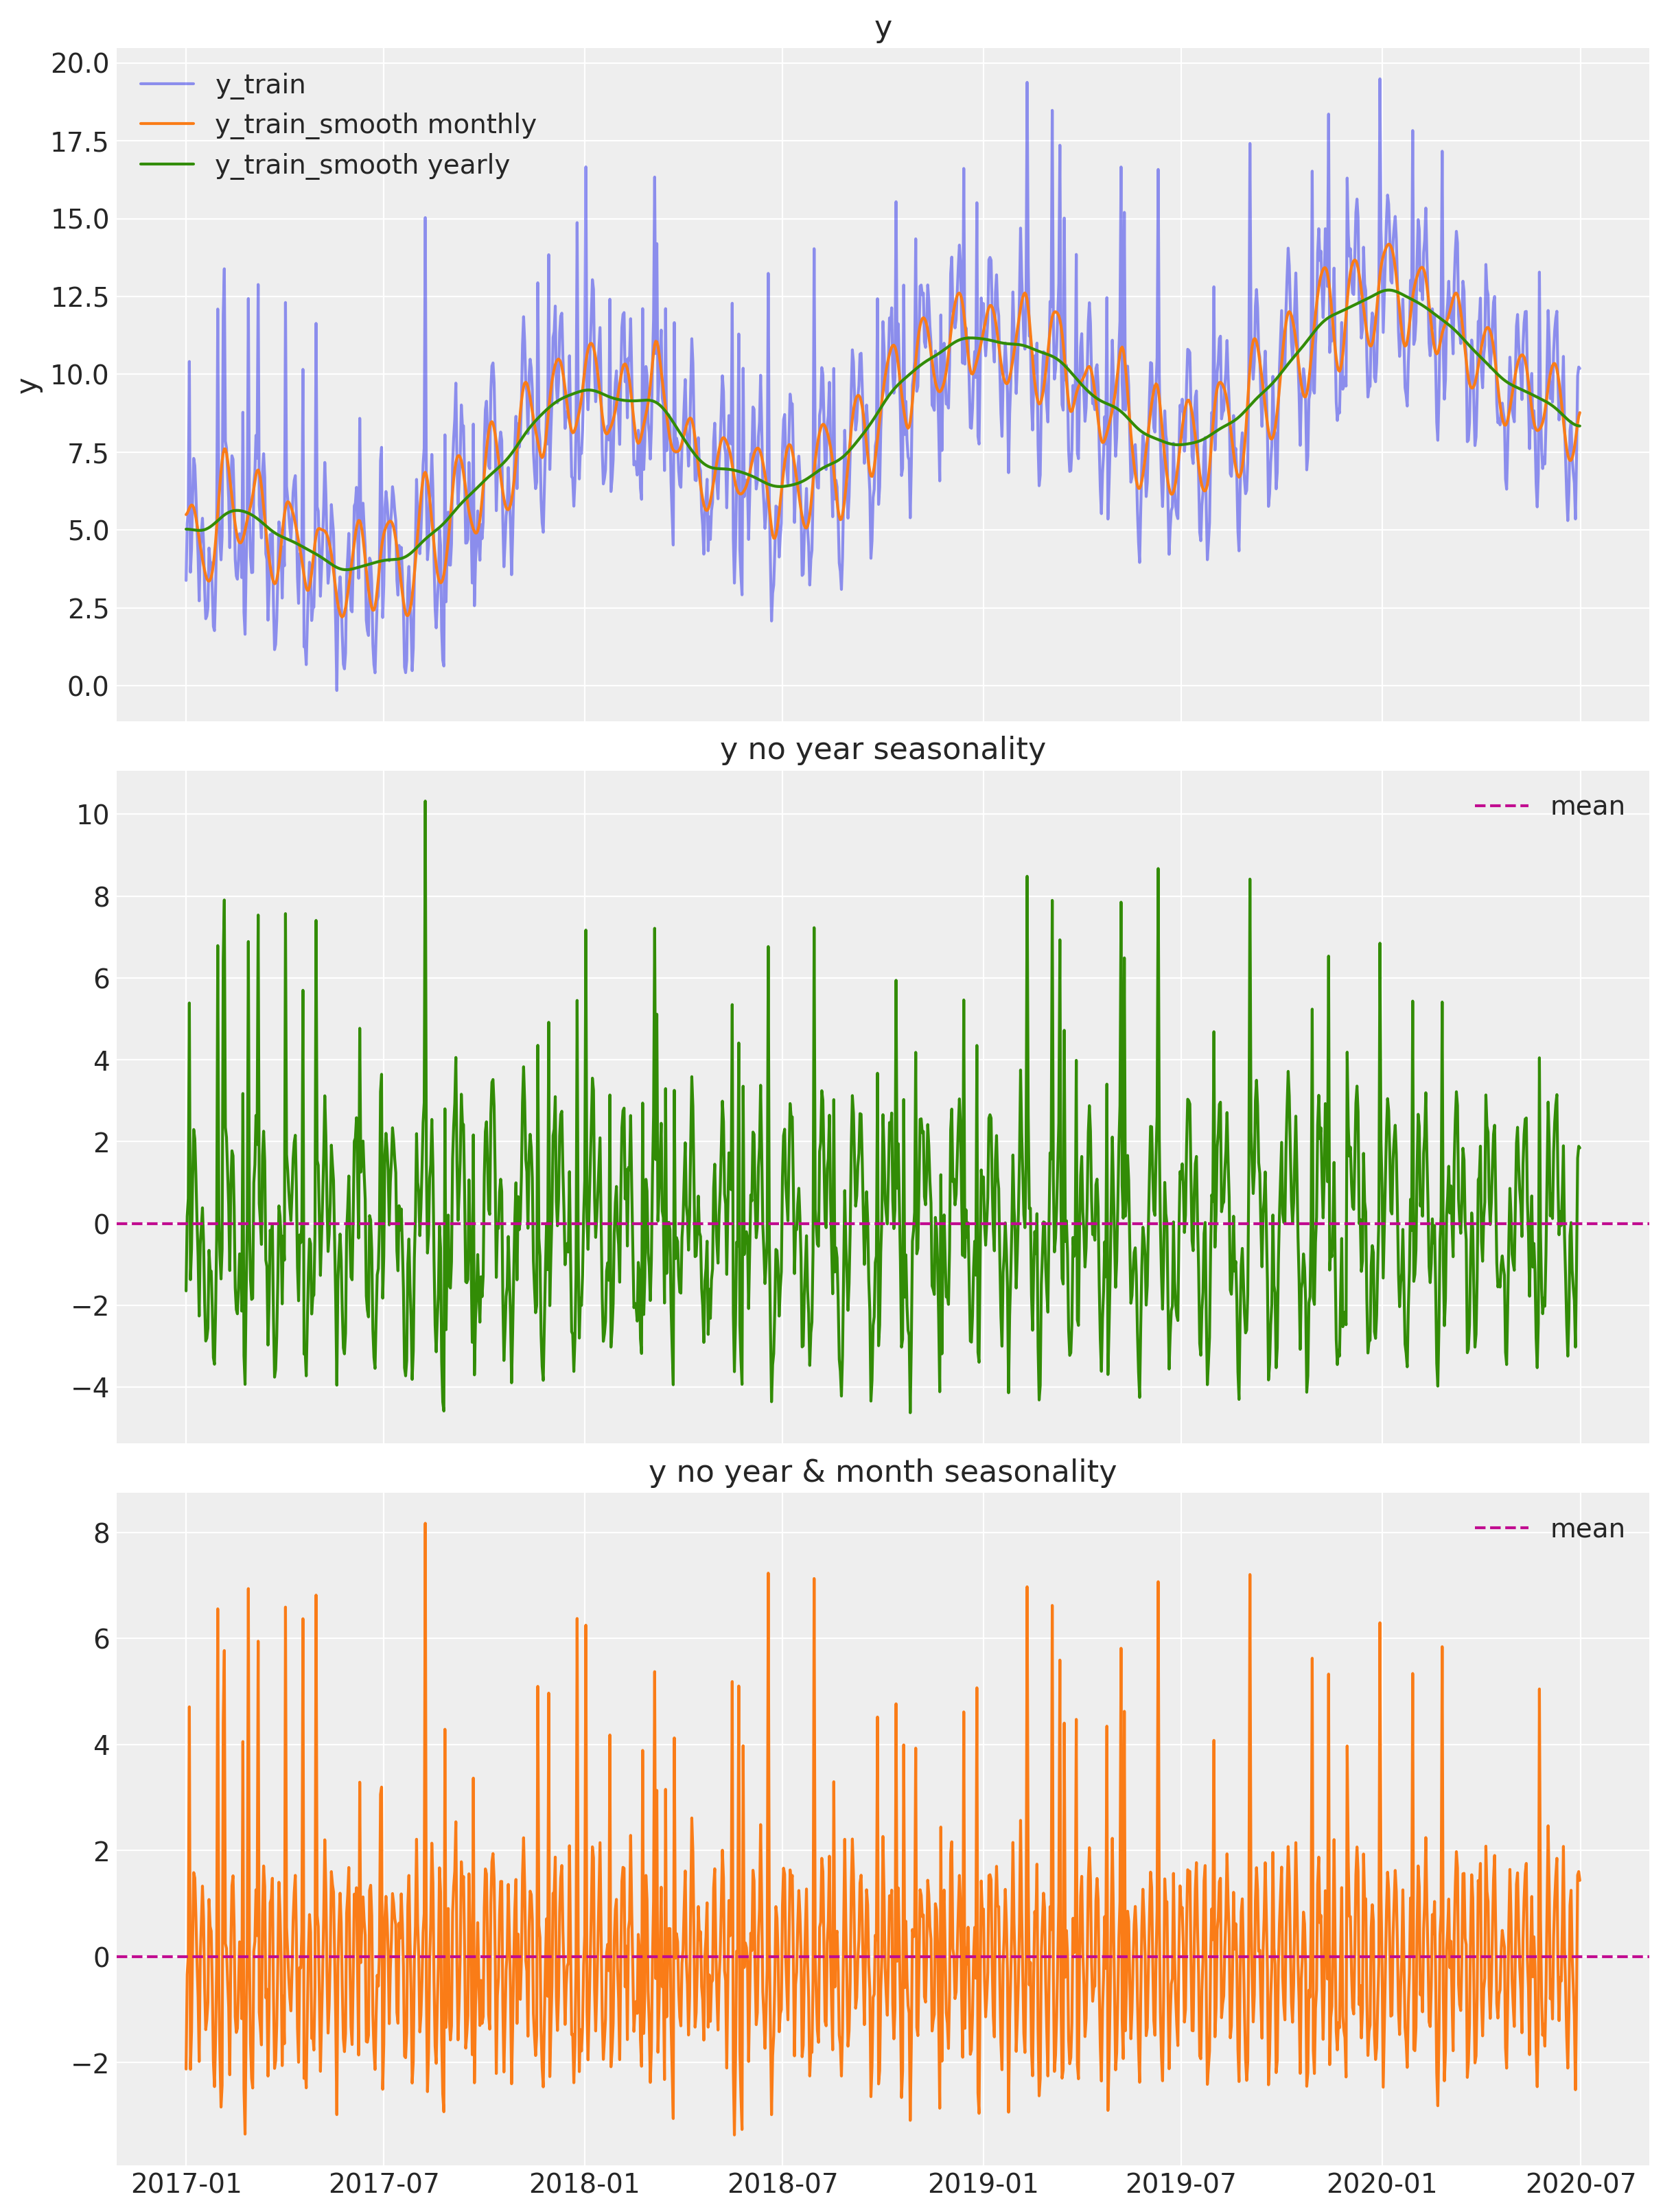

In [16]:
# Remove yearly seasonality.
y_no_year_season = df_smooth["y"] - df_smooth["y_smooth_2"]
# Remove monthly seasonality.
y_no_year_month_season = y_no_year_season - gaussian_filter(
    input=y_no_year_season, sigma=3.5
)

# Plot components.
fig, ax = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 16), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="y", label="y_train", data=df_smooth, alpha=0.5, ax=ax[0])
sns.lineplot(
    x="date", y="y_smooth_1", label="y_train_smooth monthly", data=df_smooth, ax=ax[0]
)
sns.lineplot(
    x="date", y="y_smooth_2", label="y_train_smooth yearly", data=df_smooth, ax=ax[0]
)
ax[0].set(title="y")

ax[1].plot(df_smooth["date"], y_no_year_season, c="C2")
ax[1].axhline(y_no_year_season.mean(), color="C3", linestyle="--", label="mean")
ax[1].legend()
ax[1].set(title="y no year seasonality")

ax[2].plot(df_smooth["date"], y_no_year_month_season, c="C1")
ax[2].axhline(y_no_year_month_season.mean(), color="C3", linestyle="--", label="mean")
ax[2].legend()
ax[2].set(title="y no year & month seasonality")

### AC and PAC

Let us now compute the autocorrelation and partial-autocorrelation of the remainder component.

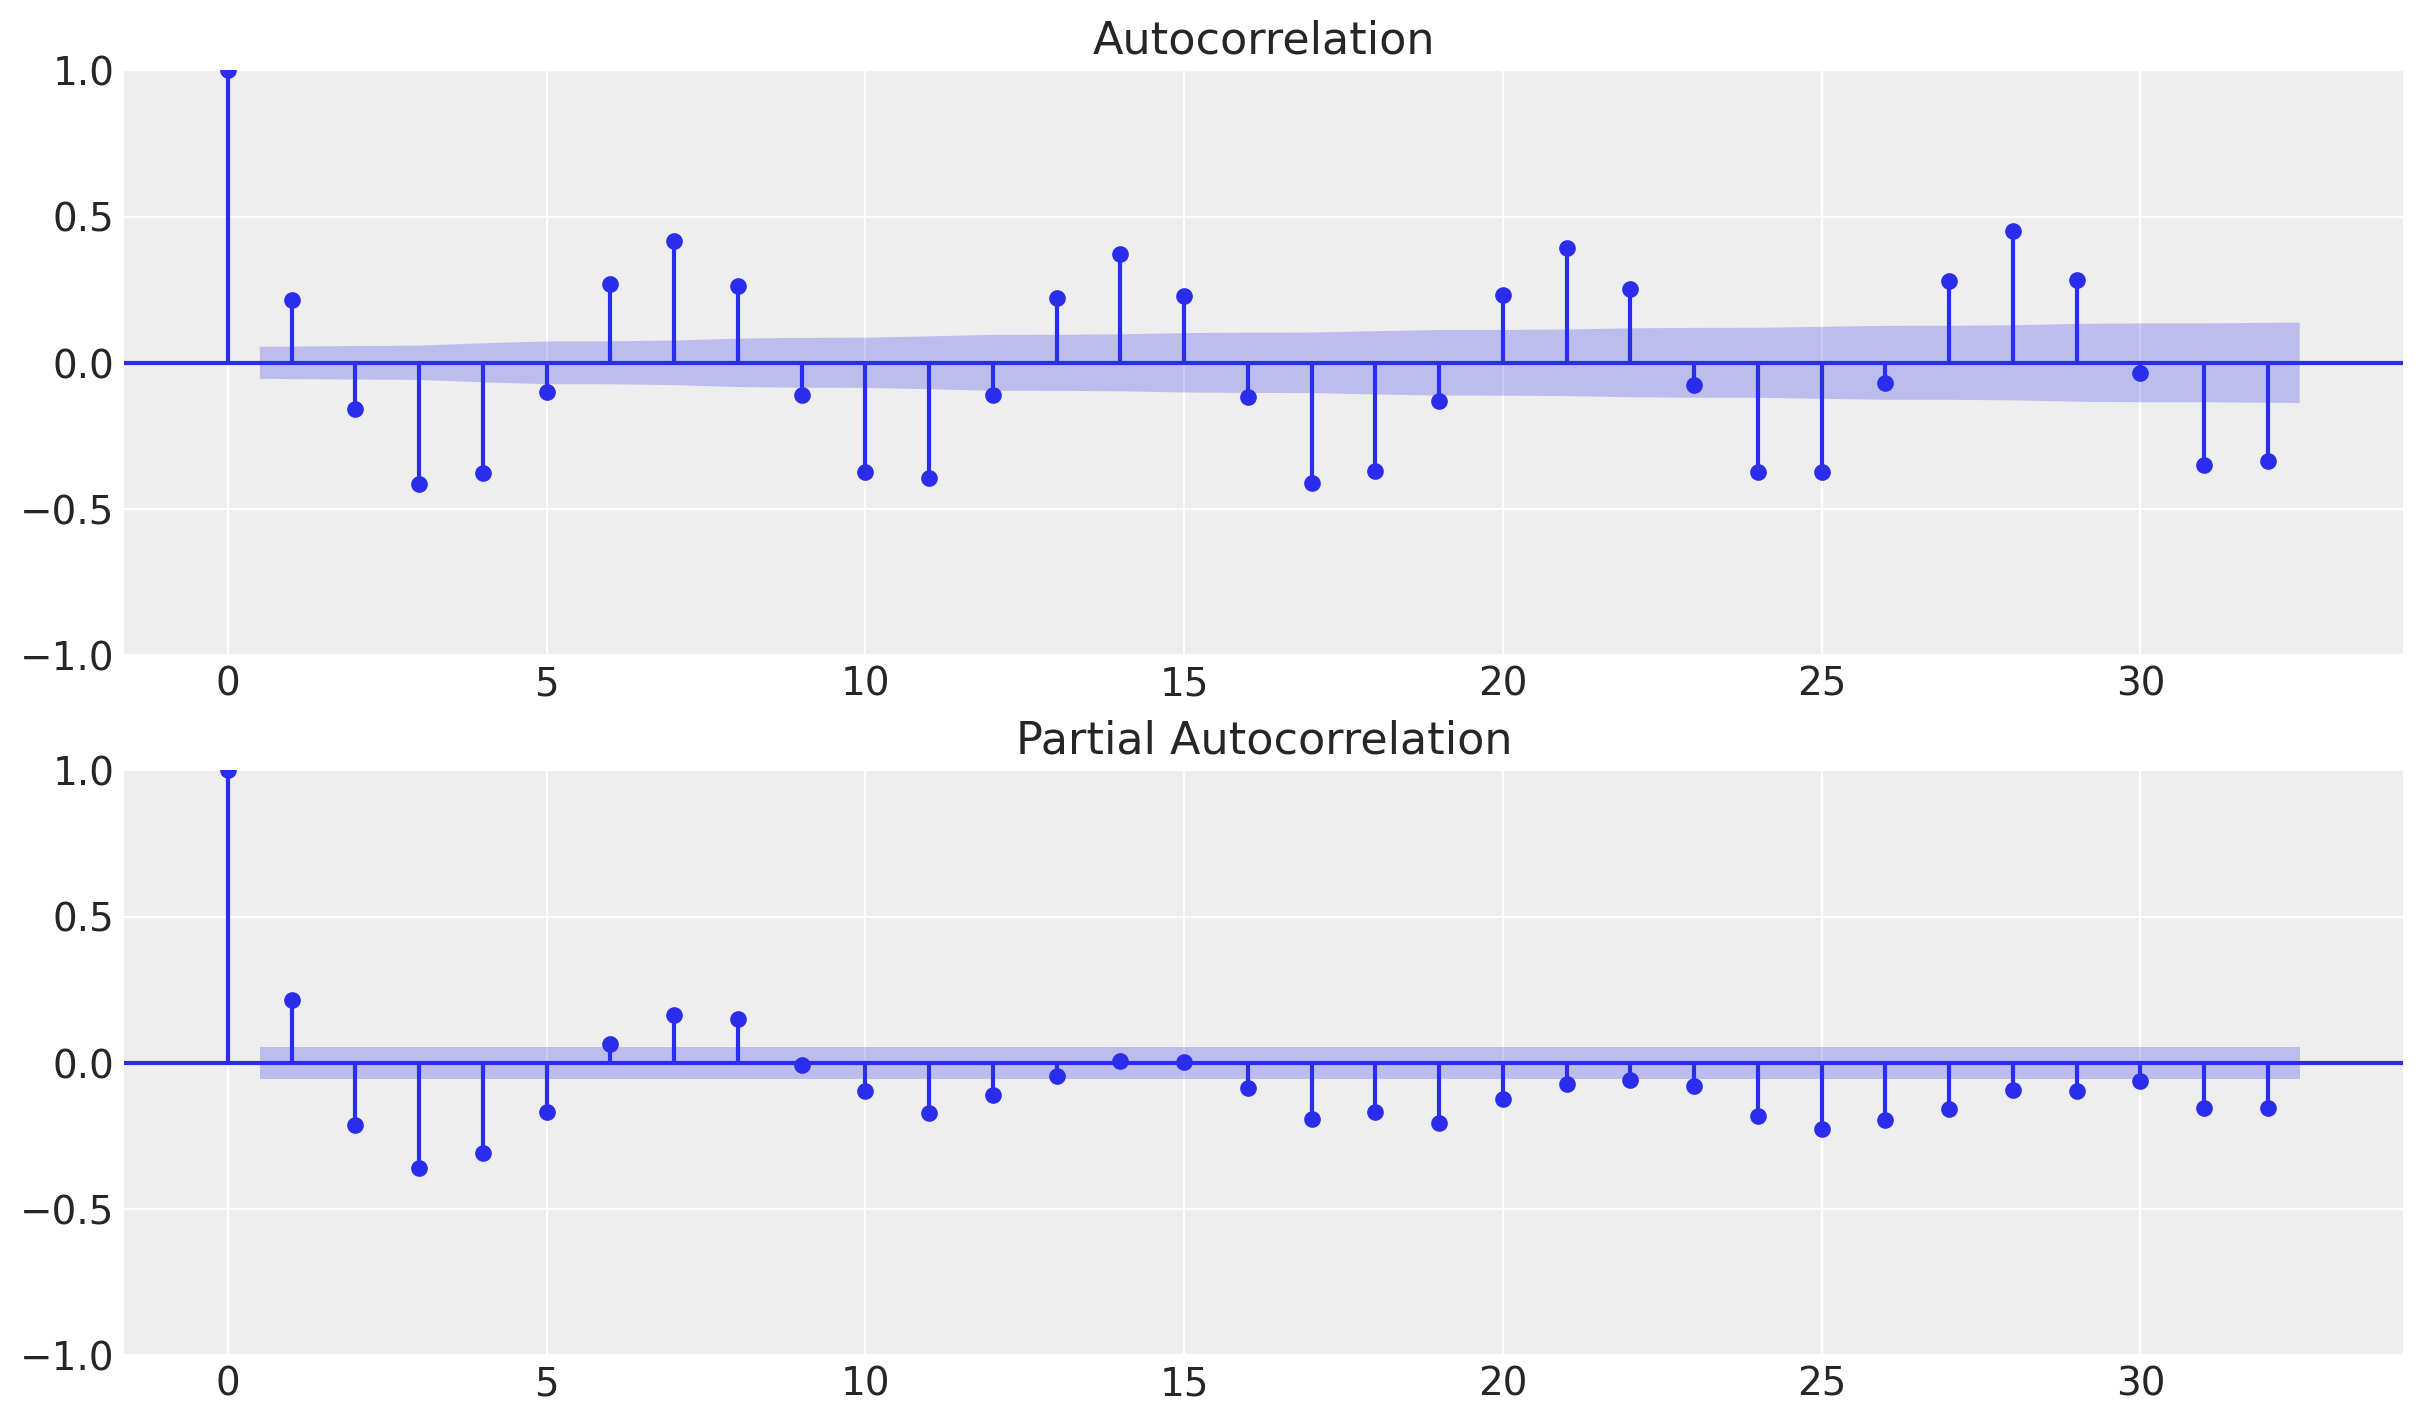

In [17]:
fig, ax = plt.subplots(2, 1)
_ = plot_acf(x=y_no_year_month_season, ax=ax[0])
_ = plot_pacf(x=y_no_year_month_season, ax=ax[1])

From the autocorrelation plot we observe a clear seasonality component at lag 7. Moreover, looking into the shape of the plot we can also see that the encoding is cyclical.

### Correlations

We want to see whether there is a linear effect of `x` on `y`. A first good indication can be obtained by looking into correlations. Naively, one would  simply compute:

In [18]:
np.corrcoef(df_train["y"], df_train["x"])[0, 1]

0.34364604482253697

However, this correlation does not reflect the potential relation of `x` on `y` since we have a clear positive trend and seasonality components. A more meaningful indication is the correlation:

In [19]:
np.corrcoef(y_no_year_month_season, df_train["x"])[0, 1]

0.6635134779159232

Note that we still have not removed the 7-day (weekly) seasonality. This of course has an effect on this correlation. To see this let us consider the scatter plot:

[Text(0.5, 1.0, 'y_no_year_month_season vs x'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y_no_year_month_season')]

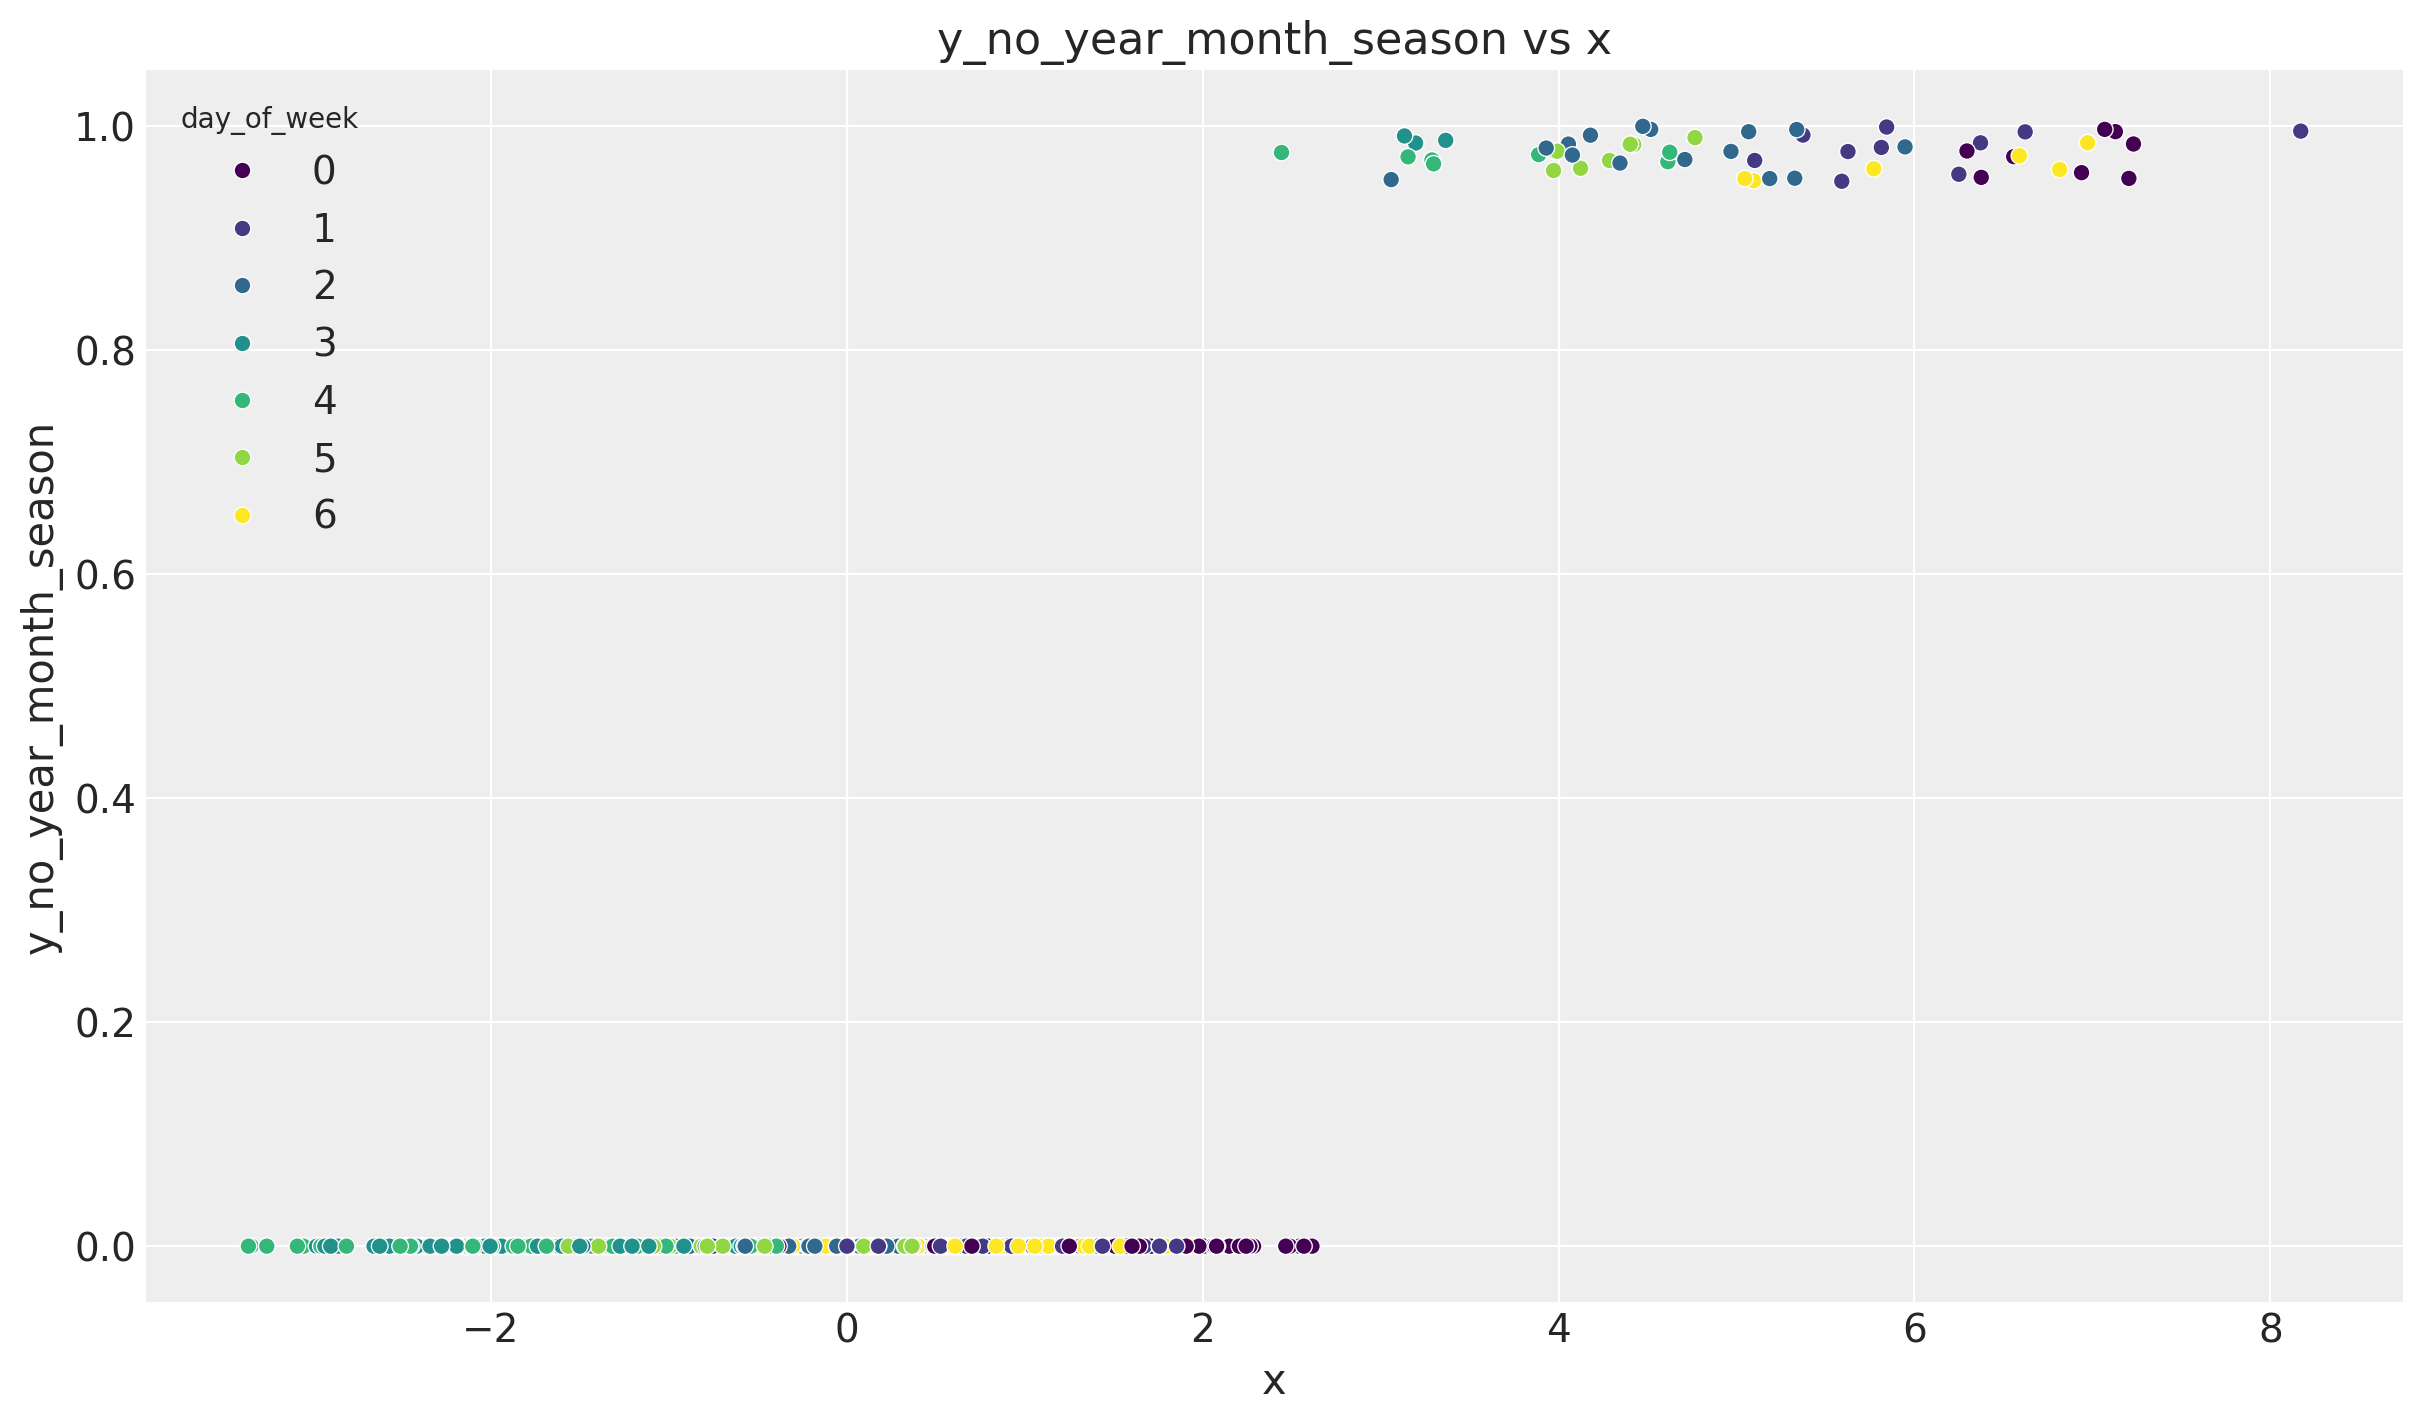

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=y_no_year_month_season,
    y=df_train["x"],
    hue=df["day_of_week"],
    palette="viridis",
    ax=ax,
)

ax.set(title="y_no_year_month_season vs x", xlabel="x", ylabel="y_no_year_month_season")

We indeed see we have clear clusters on each level of `x` corresponding to each day of the week. 

One way of removing this seasonality is via a linear regression model. We use a one-hot encoding for the day of the week variable.

**Remark:** As we have seen before a cyclical encoding might be a better choice. Nevertheless, given how the data was generated, we want to test the one-hot encoding approach. 

In [21]:
# Prepare model data frame.
dow_df = df_train[["day_of_week"]].copy()
dow_df["y_no_year_month_season"] = y_no_year_month_season
# One-hot encoding of the day of the week.
dow_dummies = pd.get_dummies(dow_df["day_of_week"], drop_first=True)
dow_dummies.columns = ["d" + str(i) for i in dow_dummies.columns]
dow_df = pd.concat([dow_df, dow_dummies], axis=1)
dow_df.head()

day_of_week  y_no_year_month_season     d1     d2     d3     d4     d5  \
0            6               -2.120053  False  False  False  False  False   
1            0               -0.341049  False  False  False  False  False   
2            1                0.020675   True  False  False  False  False   
3            2                4.709669  False   True  False  False  False   
4            3               -2.124617  False  False   True  False  False   

      d6  
0   True  
1  False  
2  False  
3  False  
4  False

Next, we fit the linear model.

In [22]:
dow_mod = smf.ols(
    formula="y_no_year_month_season ~  d1 + d2 + d3 + d4 + d5 + d6", data=dow_df
)

dow_res = dow_mod.fit()

print(dow_res.summary())

                              OLS Regression Results                              
Dep. Variable:     y_no_year_month_season   R-squared:                       0.425
Model:                                OLS   Adj. R-squared:                  0.423
Method:                     Least Squares   F-statistic:                     156.6
Date:                    Thu, 09 Nov 2023   Prob (F-statistic):          6.44e-149
Time:                            10:51:28   Log-Likelihood:                -2103.6
No. Observations:                    1277   AIC:                             4221.
Df Residuals:                        1270   BIC:                             4257.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

We now compute the correlation of the regressor `x` with the model residuals:

In [23]:
np.corrcoef(dow_res.resid, df_train["x"])[0, 1]

0.8502148605418938

The correlation increased significantly. 

### Regressor Effect

A common question in time series analysis is to estimate the effect (ROI) of a specific external regressor (e.g. what is the ROI of media spend on sales?) For this specific case, given the correlation above, we can estimate this for `x` running a linear model on the residuals of the `dow_model`.

In [24]:
x_df = df_train[["x"]].copy()
x_df["dow_model_resid"] = dow_res.resid

x_mod = smf.ols(formula="dow_model_resid ~ x", data=x_df)

x_res = x_mod.fit()

print(x_res.summary())

                            OLS Regression Results                            
Dep. Variable:        dow_model_resid   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     3326.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:51:28   Log-Likelihood:                -1284.2
No. Observations:                1277   AIC:                             2572.
Df Residuals:                    1275   BIC:                             2583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2309      0.019    -12.182      0.0

The estimates effect is then:

In [25]:
x_res.params["x"]

5.301793890986457

Recall that the *true* effect is 5.0.

### Periodogram

There is another way to extract seasonality patterns: using a [periodogram](https://en.wikipedia.org/wiki/Periodogram) to estimate the [spectral density](https://en.wikipedia.org/wiki/Spectral_density) of a signal.

[Text(0.5, 1.0, 'Power Spectral Density')]

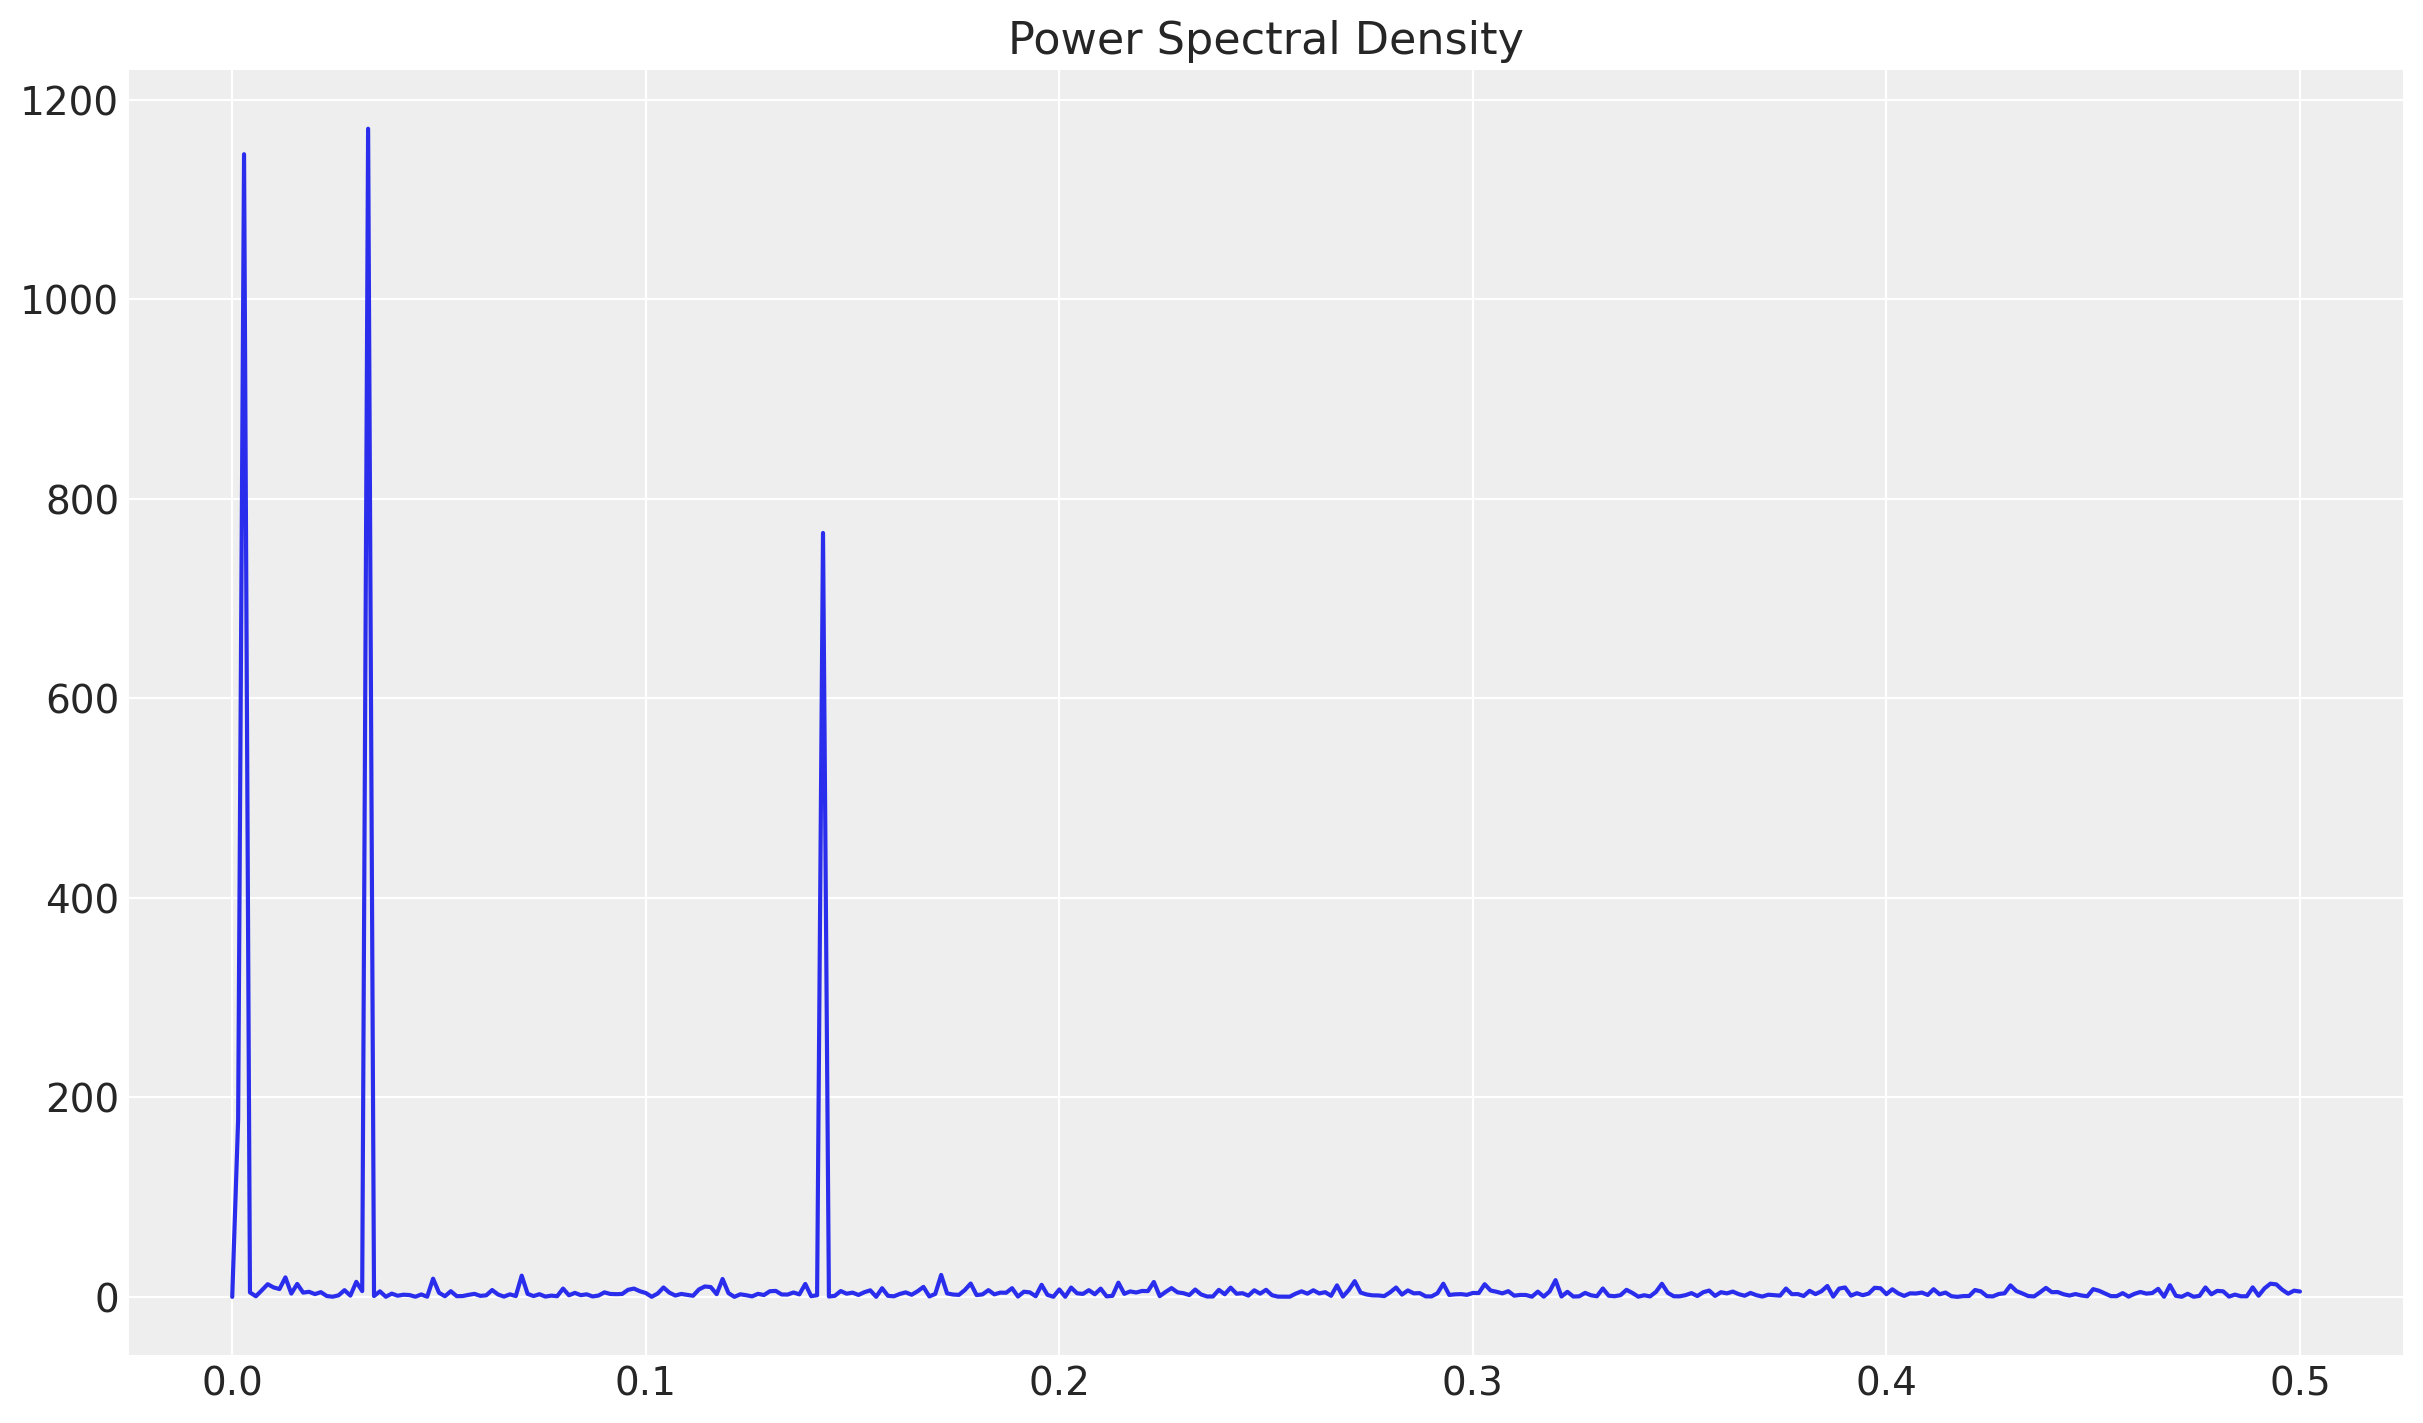

In [26]:
f, Pxx_den = signal.periodogram(x=df_train["y"], detrend="linear", nfft=int(7e2))

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title="Power Spectral Density")

Each of these peaks represent the seasonal components. To compute the associated frequency wee need to compute their multiplicative inverse. 

In [27]:
# Sort to get the peak values.
sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {"sort_freq": f[sort_freq_index], "Pxx_den": Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days=lambda x: 1 / x["sort_freq"]).head(5)

sort_freq      Pxx_den        days
0   0.032857  1171.129150   30.434783
1   0.002857  1145.587036  350.000000
2   0.142857   765.873230    7.000000
3   0.001429   178.147018  700.000000
4   0.171429    22.012793    5.833333

The first three values correspond to `days` = 30, 350 and 7. Which correspond to monthly, yearly and weekly seasonality. 

### Time Series Decomposition

[`statsmodels`](https://www.statsmodels.org/stable/index.html) has an inbuilt decomposition function using moving averages. Let us use it to estimate the effect of the external regressor (which we already know it should the residual component).

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_71423/2951417355.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


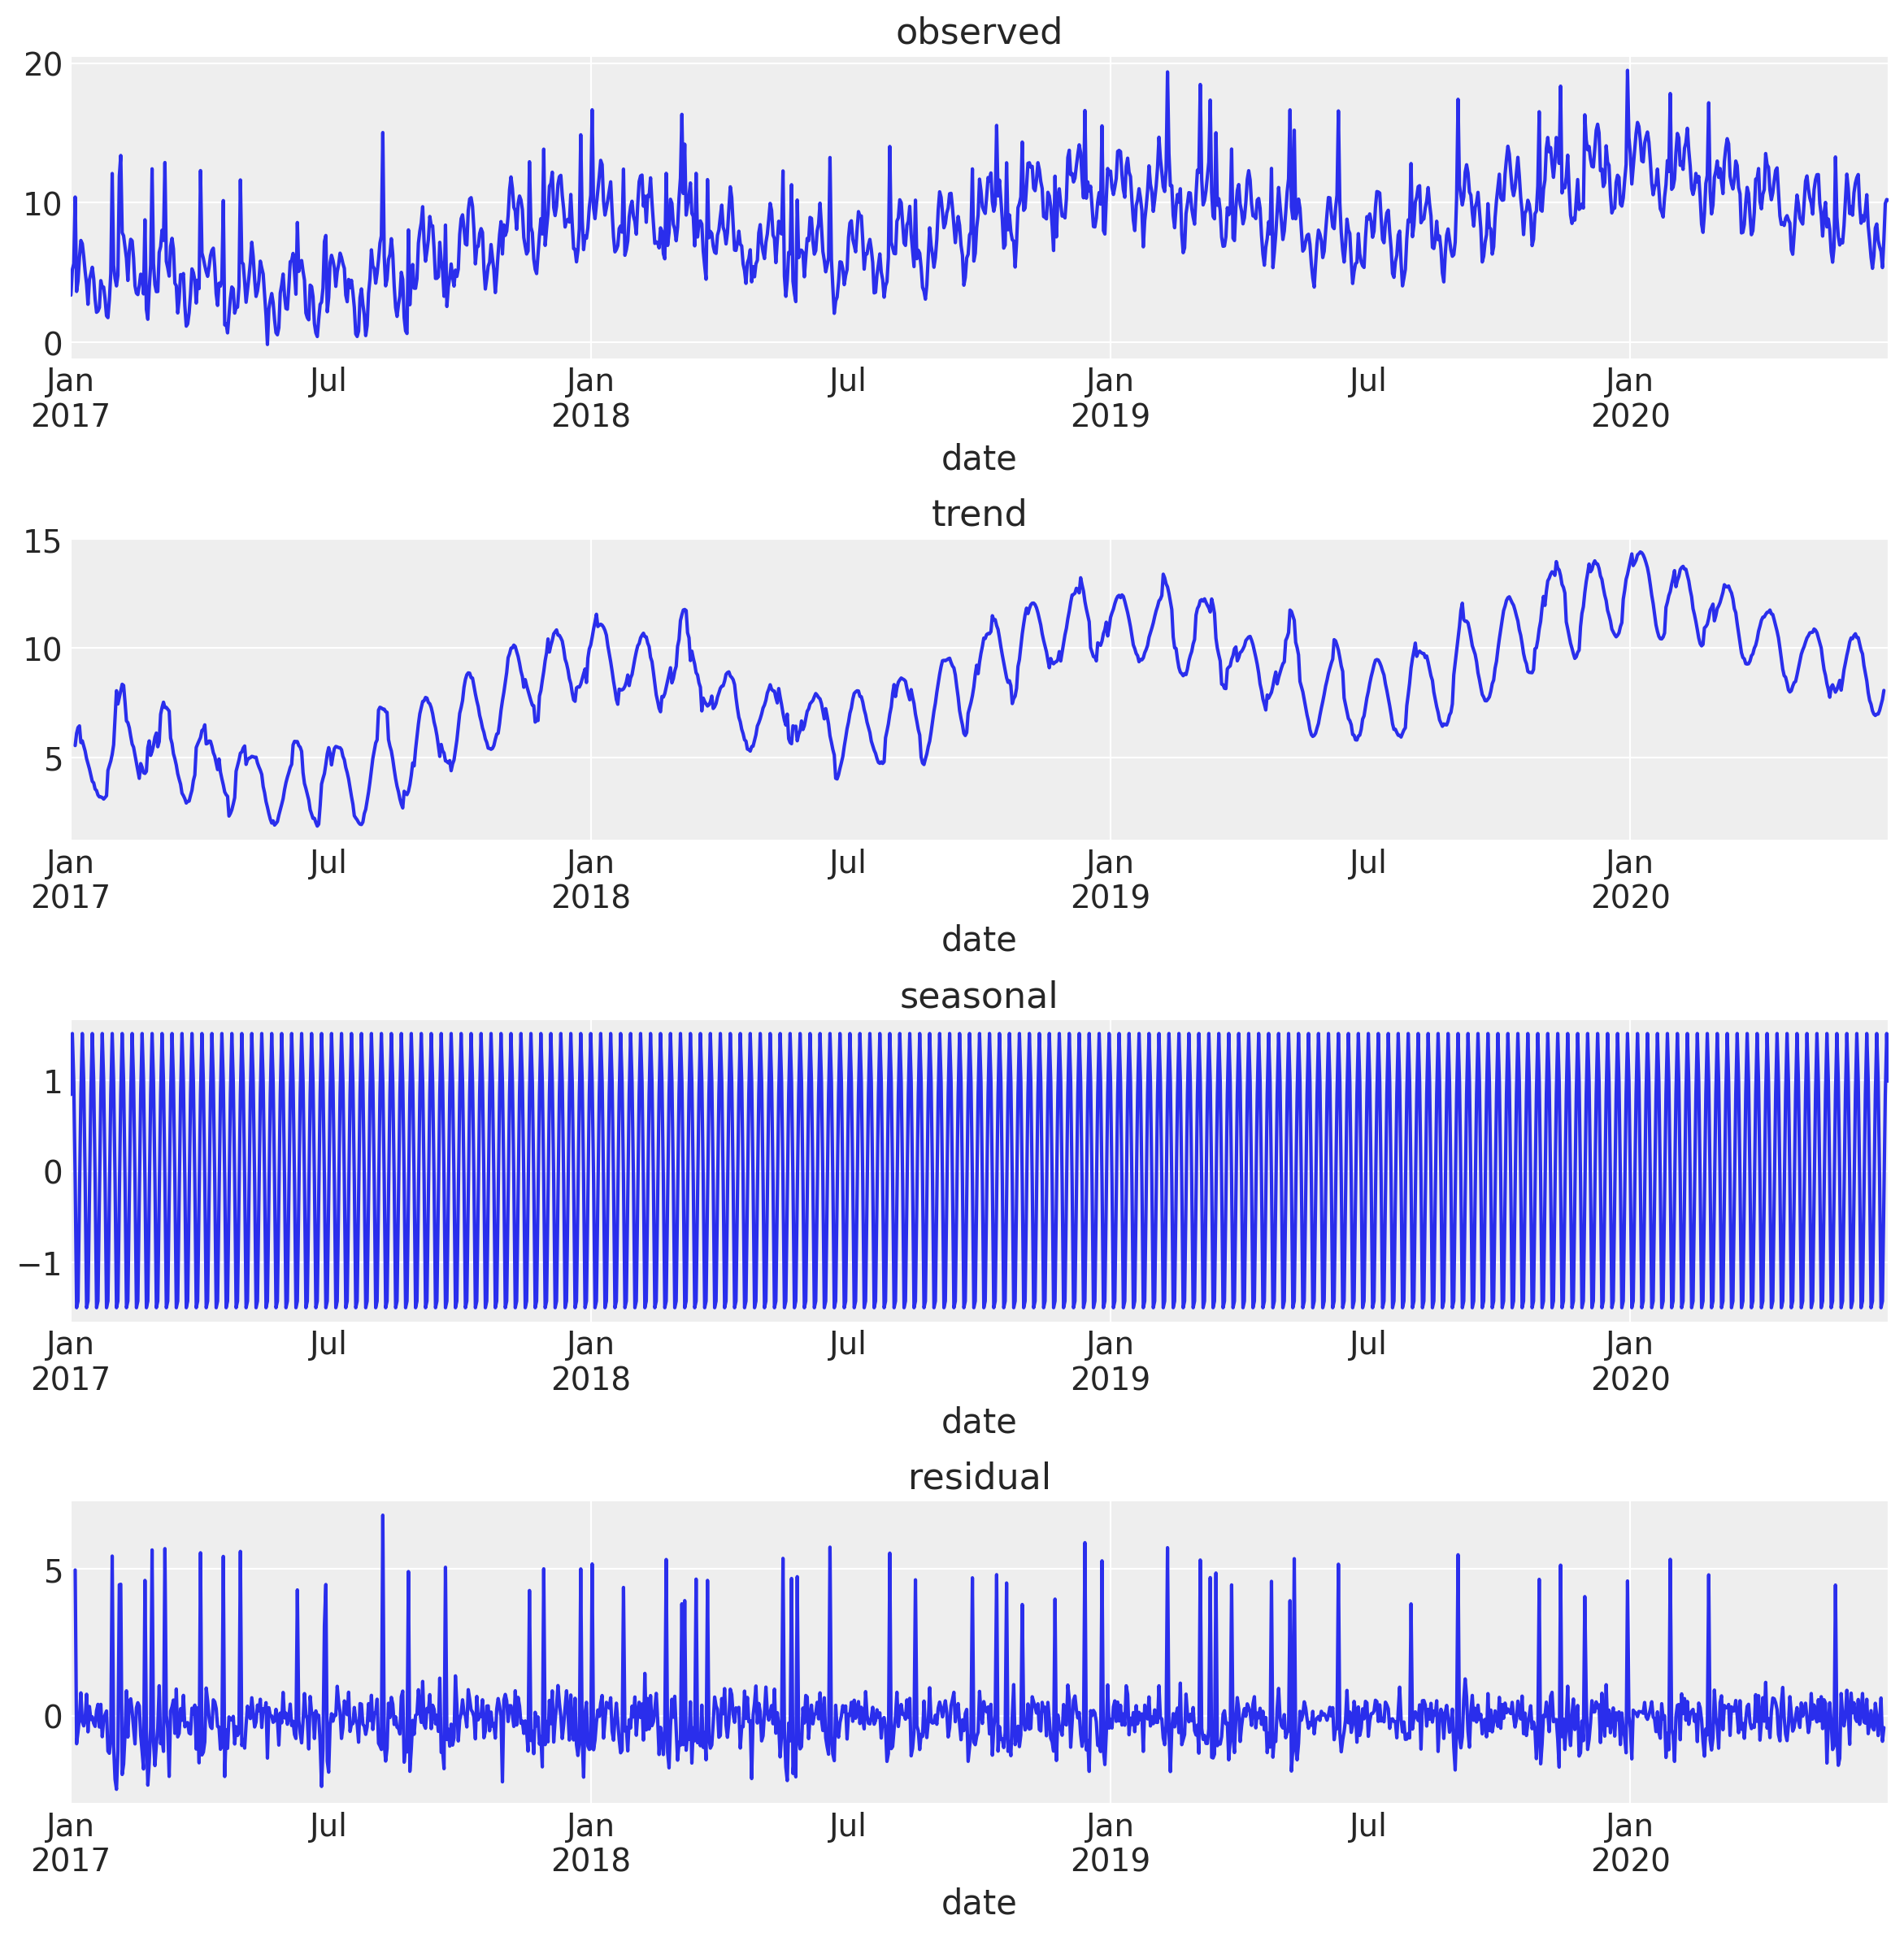

In [28]:
decomposition_obj = seasonal_decompose(
    x=df_train[["date", "y"]].set_index("date"), model="additive"
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title="observed")
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title="trend")
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title="seasonal")
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title="residual")
plt.tight_layout()

Note that the trend component also includes the monthly and yearly seasonality. This might not always be desired. You can of course use the smoothing technique presented above or keep decomposing the resulting trend by specifying the `period` parameter in the `seasonal_decompose` function.

- Correlation

In [29]:
# We remove the first and last 3 entries as they are np.nan coming
# from the moving average method.
np.corrcoef(decomposition_obj.resid[3:-3], df_train["x"][3:-3])[0, 1]

0.8533497914653861

- Effect Estimation

In [30]:
x_df["decomposition_resid"] = decomposition_obj.resid.values

x_mod2 = smf.ols(formula="decomposition_resid ~ x", data=x_df[3:-3])

x_res2 = x_mod2.fit()

print(x_res2.summary())

                             OLS Regression Results                            
Dep. Variable:     decomposition_resid   R-squared:                       0.728
Model:                             OLS   Adj. R-squared:                  0.728
Method:                  Least Squares   F-statistic:                     3400.
Date:                 Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                         10:51:31   Log-Likelihood:                -1242.5
No. Observations:                 1271   AIC:                             2489.
Df Residuals:                     1269   BIC:                             2499.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2265      0.018    -12.25

We get similar results as above. 

**Remarks:**
- In real life applications the effects of external regressors might include lags. A correlation analysis with lags needs to be done before modeling. 
- Also, linear relations might serve as a good first approximation. Nevertheless, going into non-linear relations might improve the model significantly. Two concrete methods which appear often is to model via [adstock effect](https://en.wikipedia.org/wiki/Advertising_adstock) and [generalized additive models](https://en.wikipedia.org/wiki/Generalized_additive_model). 

## Define Model

Based on the previous analysis we have identified the main components of our time series:

- A `local_linear_trend` 

- Seasonality:

    - `month_of_year` 
    - `day_of_week` 
    - `day_of_month` 
    
- External regressor `x_var`.

We define each of these components separately in order to build the sts-model using TensorFlow Probability. 

In [31]:
# Local linear trend.
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train["y"],
    name="local_linear_trend",
)

# We need to pre-define the number of days in each month.
num_days_per_month = np.array(
    [
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],  # year with leap day.
    ]
)

# Define month of year seasonal variable.
month_of_year = tfp.sts.Seasonal(
    num_seasons=12, num_steps_per_season=num_days_per_month, name="month_of_year"
)

# Define day of week as seasonal variable.
day_of_week = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=1,
    observed_time_series=df_train["y"],
    name="day_of_week",
)

# Create cyclic variable for day of the month.
design_matrix_day_of_month = tf.reshape(
    np.sin(2 * np.pi * df["day_of_month"] / df["daysinmonth"]).values.astype(
        np.float32
    ),
    (-1, 1),
)

# Define day of the month as an external regressor.
# We do not encode it as seasonal as the number of steps is not uniform.
day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix_day_of_month, name="day_of_month"
)

# Define external regressor component.
# We use the whole data set (df) as we expect to have these values in the future.
design_matrix_x_var = tf.reshape(df["x"].values, (-1, 1))

x_var = tfp.sts.LinearRegression(design_matrix=design_matrix_x_var, name="x_var")

Now we build the model:

In [32]:
model_components = [
    local_linear_trend,
    month_of_year,
    day_of_week,
    day_of_month,
    x_var,
]

toy_model = tfp.sts.Sum(components=model_components, observed_time_series=df_train["y"])

Let us see the model parameters and their priors:

In [33]:
for p in toy_model.parameters:
    print("-" * 140)
    print(f"Parameter: {p.name}")
    print(f"Prior: {str(p.prior)}")

--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: observation_noise_scale
Prior: tfp.distributions.LogNormal("LogNormal", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_level_scale
Prior: tfp.distributions.LogNormal("level_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_slope_scale
Prior: tfp.distributions.LogNormal("slope_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: mon

## Model Fit

### Variational Inference (Short Intro)

We follow the strategy of the TensorFlow Probability [use cases](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) and fit the model using variational inference. I find the article [Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf) very good for an introduction to the subject. The main idea of variational inference is to use optimization methods to minimize the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) divergence in order to approximate a conditional density within a family of specified parameter densities $\mathfrak{D}$. Specifically, assume we are given observed variables $x$ (i.e. data) and let $z$ be a set of latent variables with joint density $p(x, z)$. We are interested in  computing the conditional density

$$
p(z|x) = \frac{p(x, z)}{p(x)}, \quad\text{where} \quad p(x)=\int p(x, z) dz. 
$$

This last integral (known as the *evidence*) is in general very hard to compute. The main idea of variational inference is to solve the optimization problem

$$
q^{*}(z)=\min_{q \in \mathfrak{D}} \text{KL}(q(z)||p(z|x)), 
$$

where 

$$
\begin{align}
\text{KL}(q(z)||p(z|x)) =& \text{E}[\log(q(z))] - \text{E}[\log(p(z|x))] \\
=& \text{E}[\log(q(z))] - \text{E}[\log(p(z,x))] - \text{E}[\log(p(x))] \\
=& \text{E}[\log(q(z))] - \text{E}[\log(p(z,x))] - \log(p(x)
\end{align}
$$

is the Kullback-Leibler (KL) divergence (the expected values are taken with respect to $q(z)$). Note that this quantity contains a term $\text{E}[\log(p(x))]$, which is hard to compute. *Because we cannot compute the KL, we optimize an alternative objective that is equivalent
to the KL up to an added constant*,

$$
\text{ELBO}(q) = \text{E}[\log(p(z, x))] - \text{E}[\log(q(z))]
$$

ELBO stands for *evidence lower bound*. 

**Remark:** Note that

$$
\text{ELBO}(q)= -\text{KL}(q(z)||p(z|x)) + \log(p(x))
$$

Moreover, it is easy to see that 

$$
\text{ELBO}(q)= \text{E}[\log(p(x|z)]-\text{KL}(q(z)||p(x))
$$

The first term is the expected likelihood and the second term is the negative divergence between the variational density and the prior.

For more details and enlightening comments, please refer to the article mentioned above (from which this short introduction was taken from). 

### Variational Inference in TensorFlow Probability

First we build the variational surrogate posteriors, which consist of independent normal distributions with two trainable hyper-parameters `loc` and `scale` for each parameter in the model. That is, $\mathfrak{D}$ above consists of normal distributions.

In [34]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=toy_model, seed=seed
)

Let us sample from the prior distributions and plot the corresponding densities:

In [35]:
q_prior_samples = variational_posteriors.sample(1000)

Text(0.5, 1.02, 'PRIOR DISTRIBUTIONS')

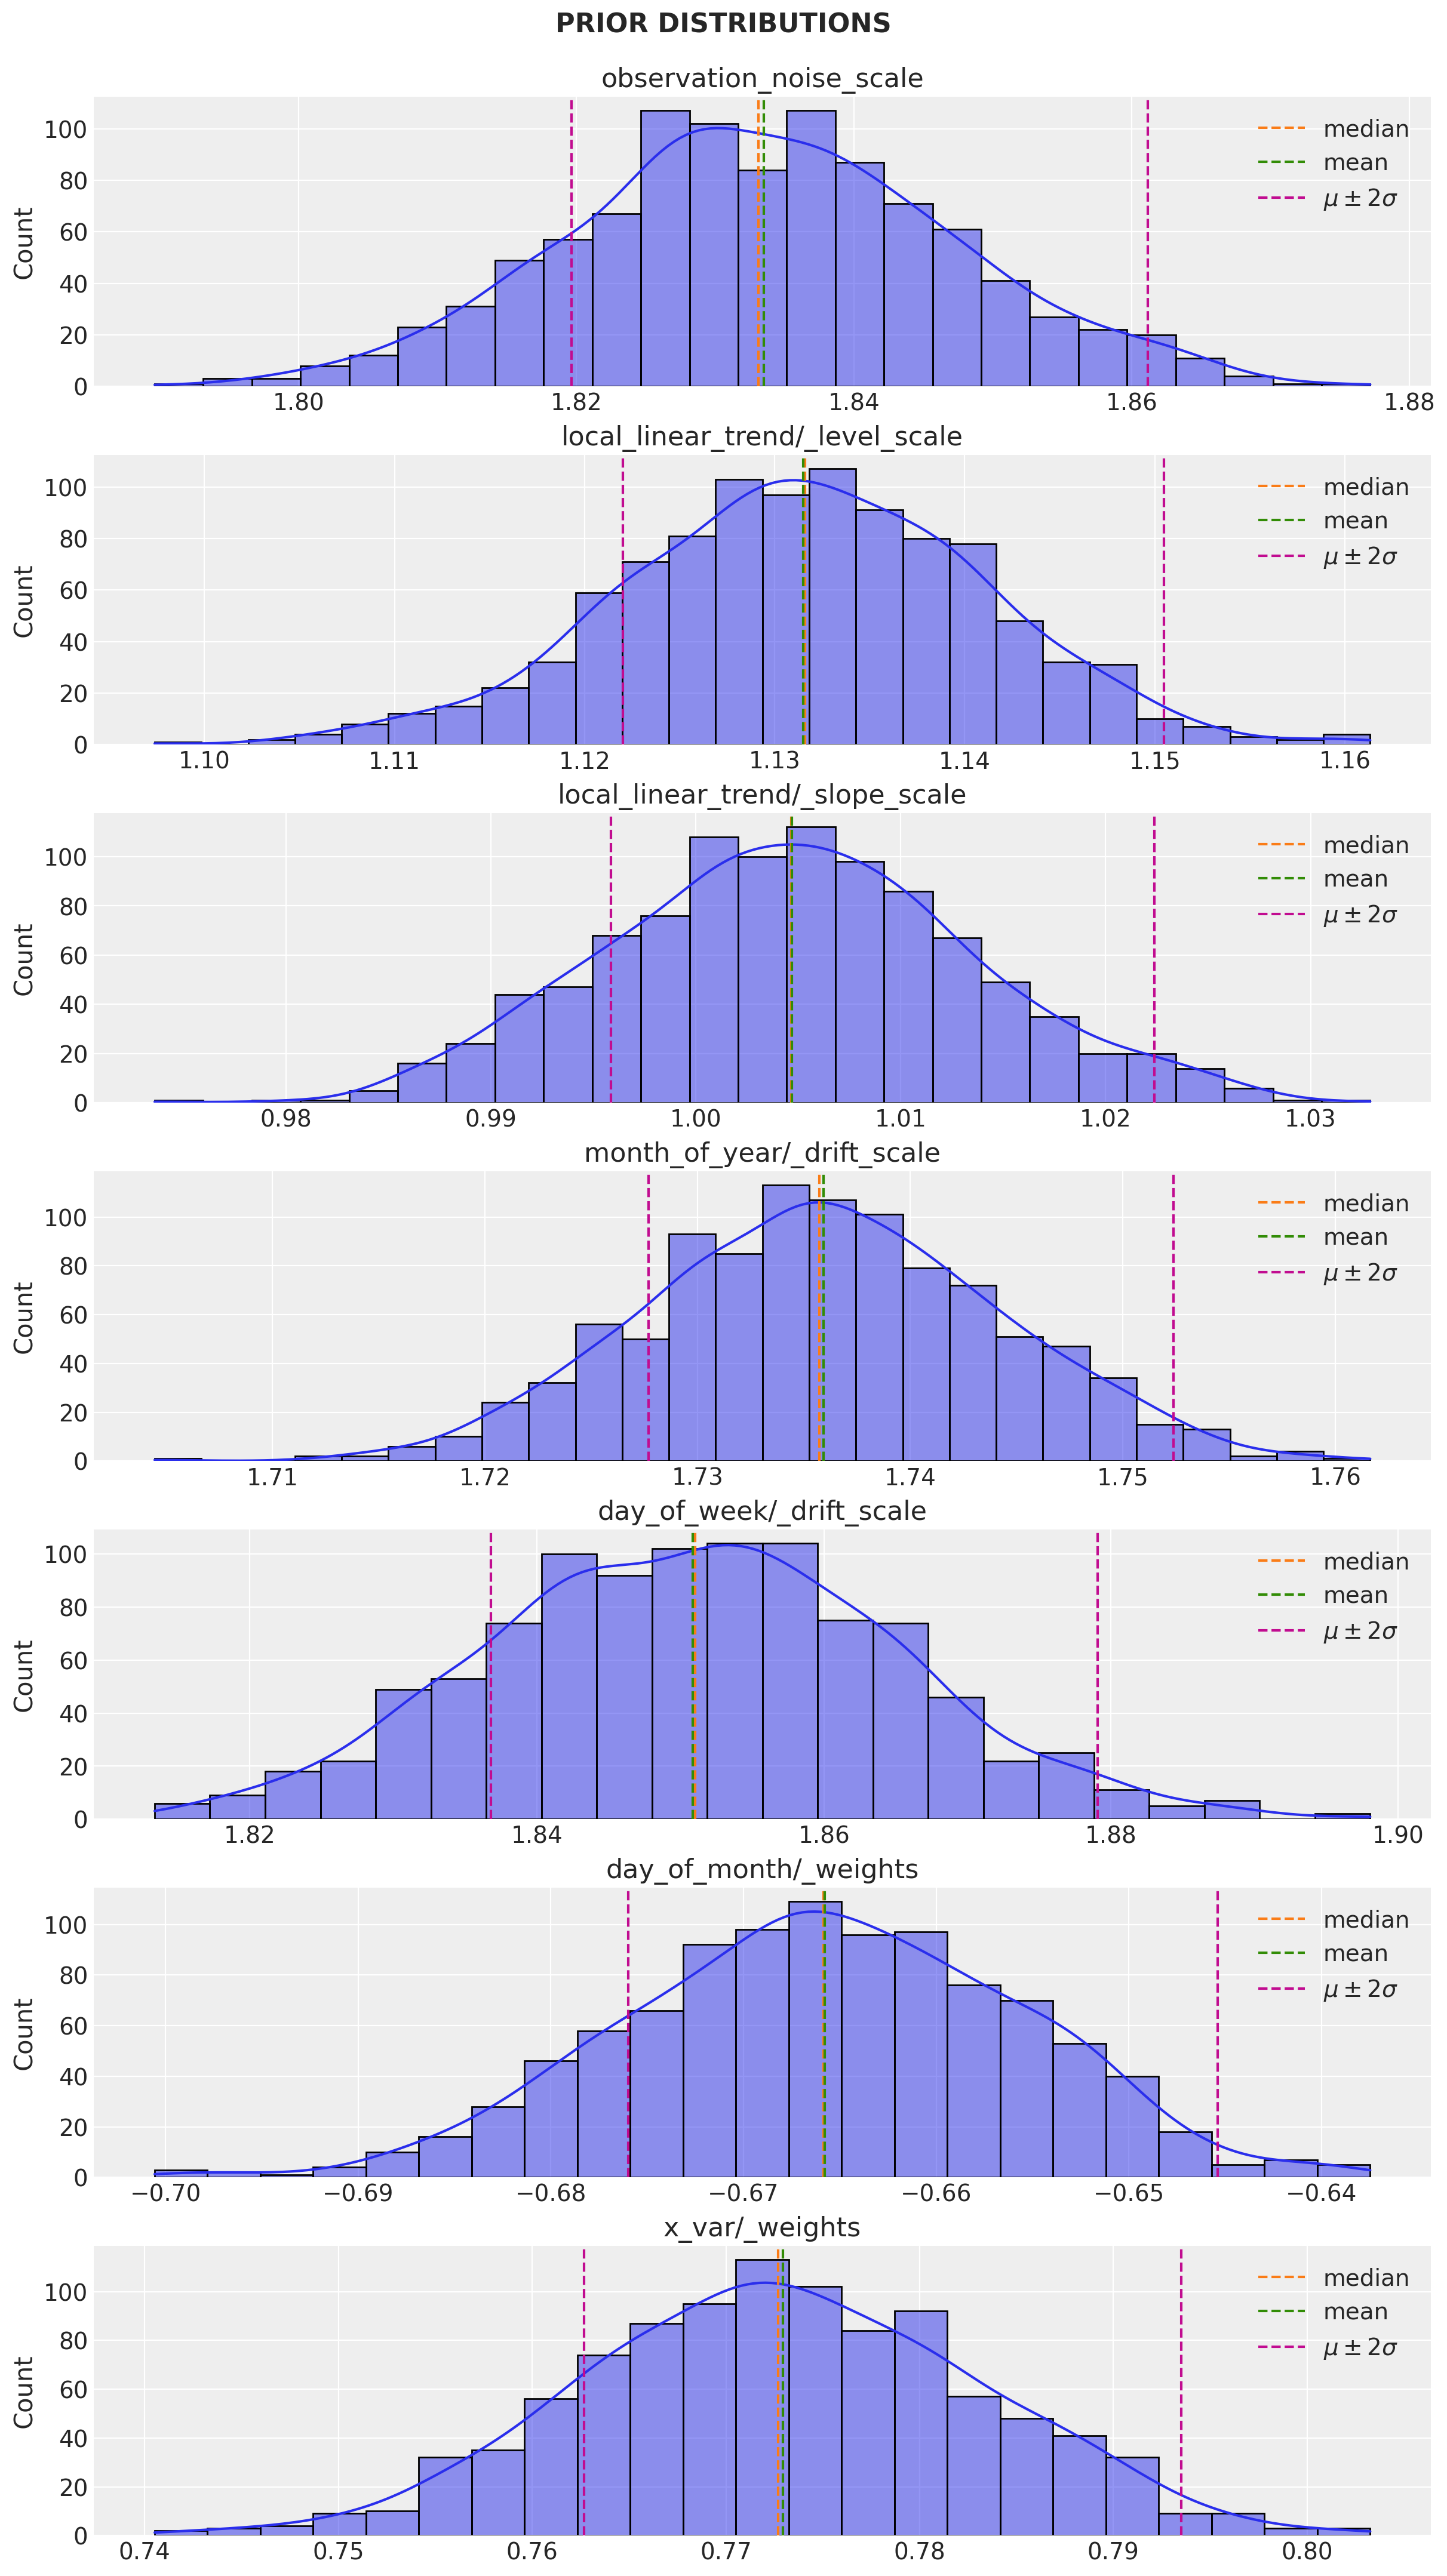

In [36]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(
    nrows=num_parameters,
    ncols=1,
    figsize=(12, 21),
    sharex=False,
    sharey=False,
    layout="constrained",
)

for i, param in enumerate(toy_model.parameters):
    param_mean = np.mean(q_prior_samples[param.name], axis=0)
    param_median = np.median(q_prior_samples[param.name], axis=0)
    param_std = np.std(q_prior_samples[param.name], axis=0)

    sns.histplot(x=q_prior_samples[param.name].numpy().flatten(), kde=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x=param_median, color="C1", linestyle="--", label="median")
    ax[i].axvline(x=param_mean, color="C2", linestyle="--", label="mean")
    ax[i].axvline(
        x=param_mean + 2 * param_std,
        color="C3",
        linestyle="--",
        label=r"$\mu \pm 2\sigma$",
    )
    ax[i].axvline(x=param_mean - param_std, color="C3", linestyle="--")
    ax[i].legend()

fig.suptitle("PRIOR DISTRIBUTIONS", fontweight="bold", fontsize=16, y=1.02)

Next we run the optimization procedure.

In [37]:
num_variational_steps = 500

# Set optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)


# Using fit_surrogate_posterior to build and optimize
# the variational loss function.
@tf.function(experimental_compile=True)
def train():
    # Build the joint density.
    target_log_prob_fn = toy_model.joint_distribution(
        observed_time_series=df_train["y"]
    ).log_prob

    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=seed,
    )


# Run optimization.
elbo_loss_curve = train()

2023-11-09 10:52:02.753009: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:104] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
2023-11-09 10:52:15.952250: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Let us plot the `elbo_loss_curve`.

[Text(0.5, 1.0, 'ELBO Loss Curve'), Text(0.5, 0, 'iteration')]

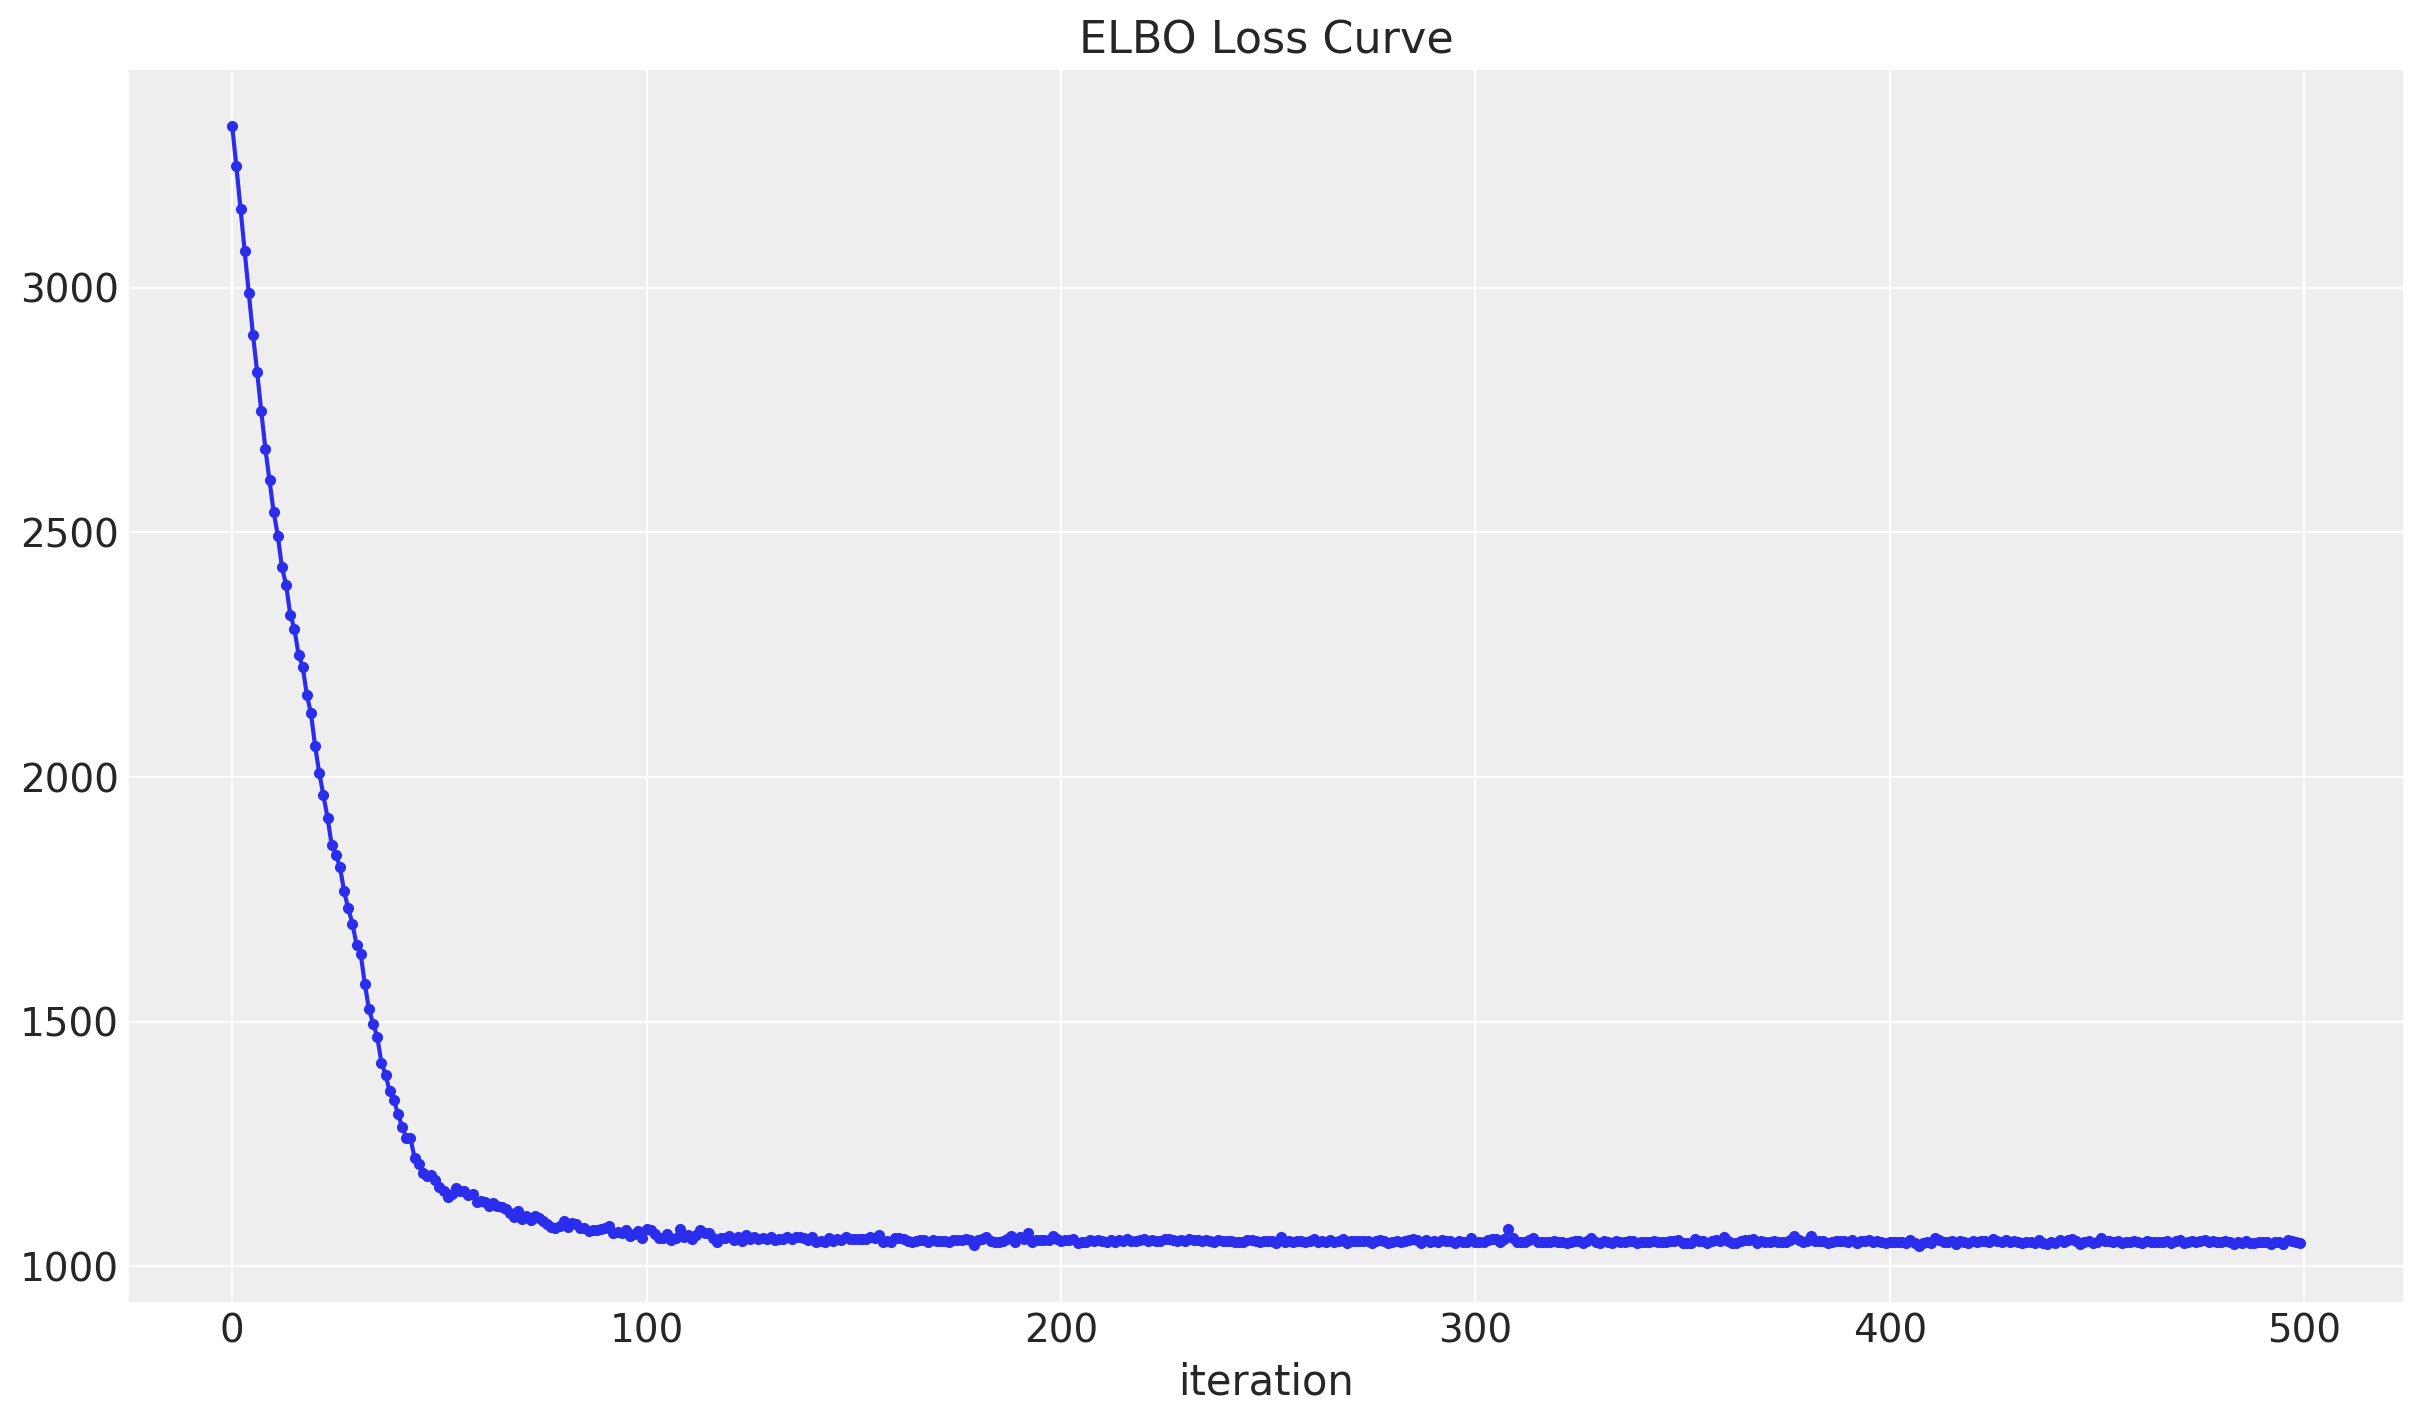

In [38]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker=".")
ax.set(title="ELBO Loss Curve", xlabel="iteration")

We see that a minimum has been reached. 

Now we sample from the variational posteriors obtained:

In [39]:
q_samples = variational_posteriors.sample(2_000)

Let us plot the parameter posterior distributions:

Text(0.5, 1.02, 'POSTERIOR DISTRIBUTIONS')

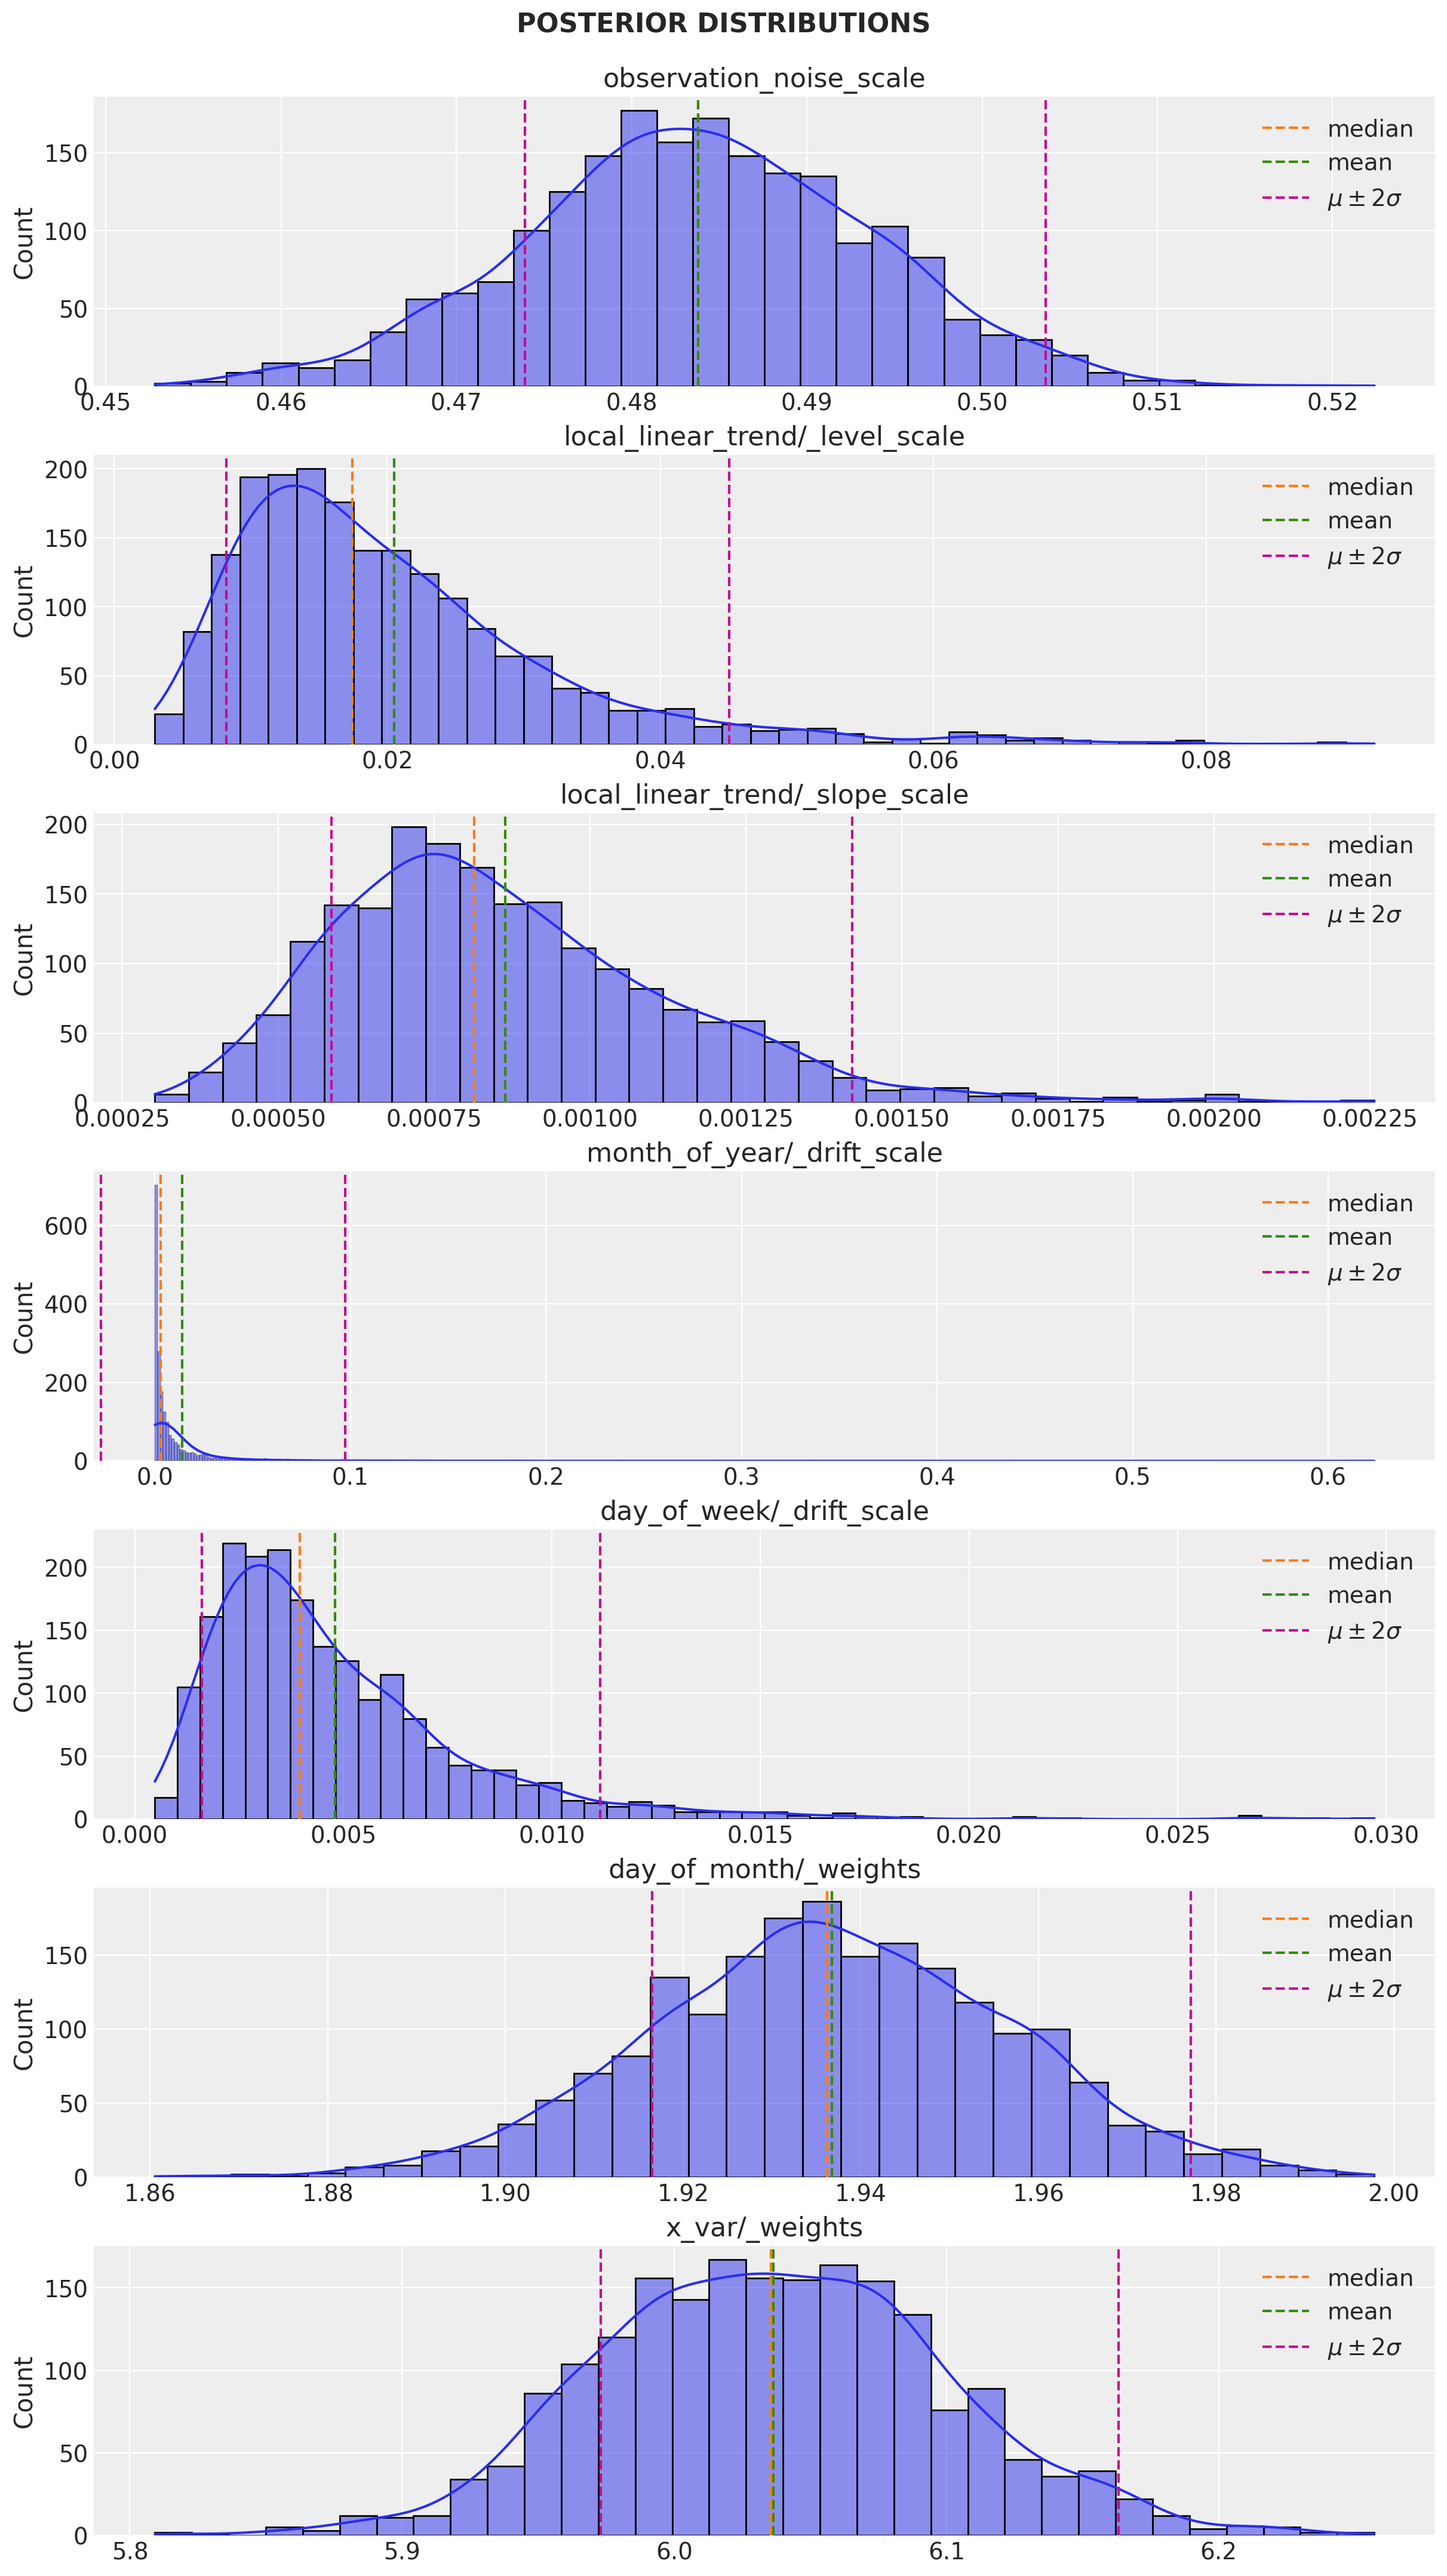

In [40]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(
    nrows=num_parameters,
    ncols=1,
    figsize=(12, 21),
    sharex=False,
    sharey=False,
    layout="constrained",
)

for i, param in enumerate(toy_model.parameters):
    param_mean = np.mean(q_samples[param.name], axis=0)
    param_median = np.median(q_samples[param.name], axis=0)
    param_std = np.std(q_samples[param.name], axis=0)

    sns.histplot(x=q_samples[param.name].numpy().flatten(), kde=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x=param_median, color="C1", linestyle="--", label="median")
    ax[i].axvline(x=param_mean, color="C2", linestyle="--", label="mean")
    ax[i].axvline(
        x=param_mean + 2 * param_std,
        color="C3",
        linestyle="--",
        label=r"$\mu \pm 2\sigma$",
    )
    ax[i].axvline(x=param_mean - param_std, color="C3", linestyle="--")
    ax[i].legend()

fig.suptitle("POSTERIOR DISTRIBUTIONS", fontweight="bold", fontsize=16, y=1.02)

In [41]:
# Get mean and std for each parameter.
print("Inferred parameters:")
for param in toy_model.parameters:
    print(
        "{}: {} +- {}".format(
            param.name,
            np.mean(q_samples[param.name], axis=0),
            np.std(q_samples[param.name], axis=0),
        )
    )

Inferred parameters:
observation_noise_scale: 0.48380982875823975 +- 0.009907073341310024
local_linear_trend/_level_scale: 0.020488305017352104 +- 0.012273477390408516
local_linear_trend/_slope_scale: 0.0008637713617645204 +- 0.0002781062794383615
month_of_year/_drift_scale: 0.01397763378918171 +- 0.0416092611849308
day_of_week/_drift_scale: 0.004796203691512346 +- 0.003183585125952959
day_of_month/_weights: [1.9367456] +- [0.02021505]
x_var/_weights: [6.036375] +- [0.06345121]


**Remark:** Observe that the estimated effect of the regressor `x` is around 6.

## Model Predictions

We now generate the forecast six months ahead. 

In [42]:
# Compute number of days in the last 6 months of 2020.
forecast_window = num_days_per_month[-1][6:13].sum().astype(np.int32)

# Get forecast distribution.
forecast_dist = tfp.sts.forecast(
    model=toy_model,
    observed_time_series=df_train["y"],
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window,
)

In [43]:
# Sample and compute mean and std.
num_samples = 1_000

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten(),
)

Next, we store the predictions on the `df_test` data frame.

In [44]:
df_test = df_test.assign(
    y_pred=forecast_mean,
    y_pred_std=forecast_scale,
    errors=lambda x: x["y"] - x["y_pred"],
)

Let us plot the predictions:

[Text(0.5, 1.0, 'STS Forecast')]

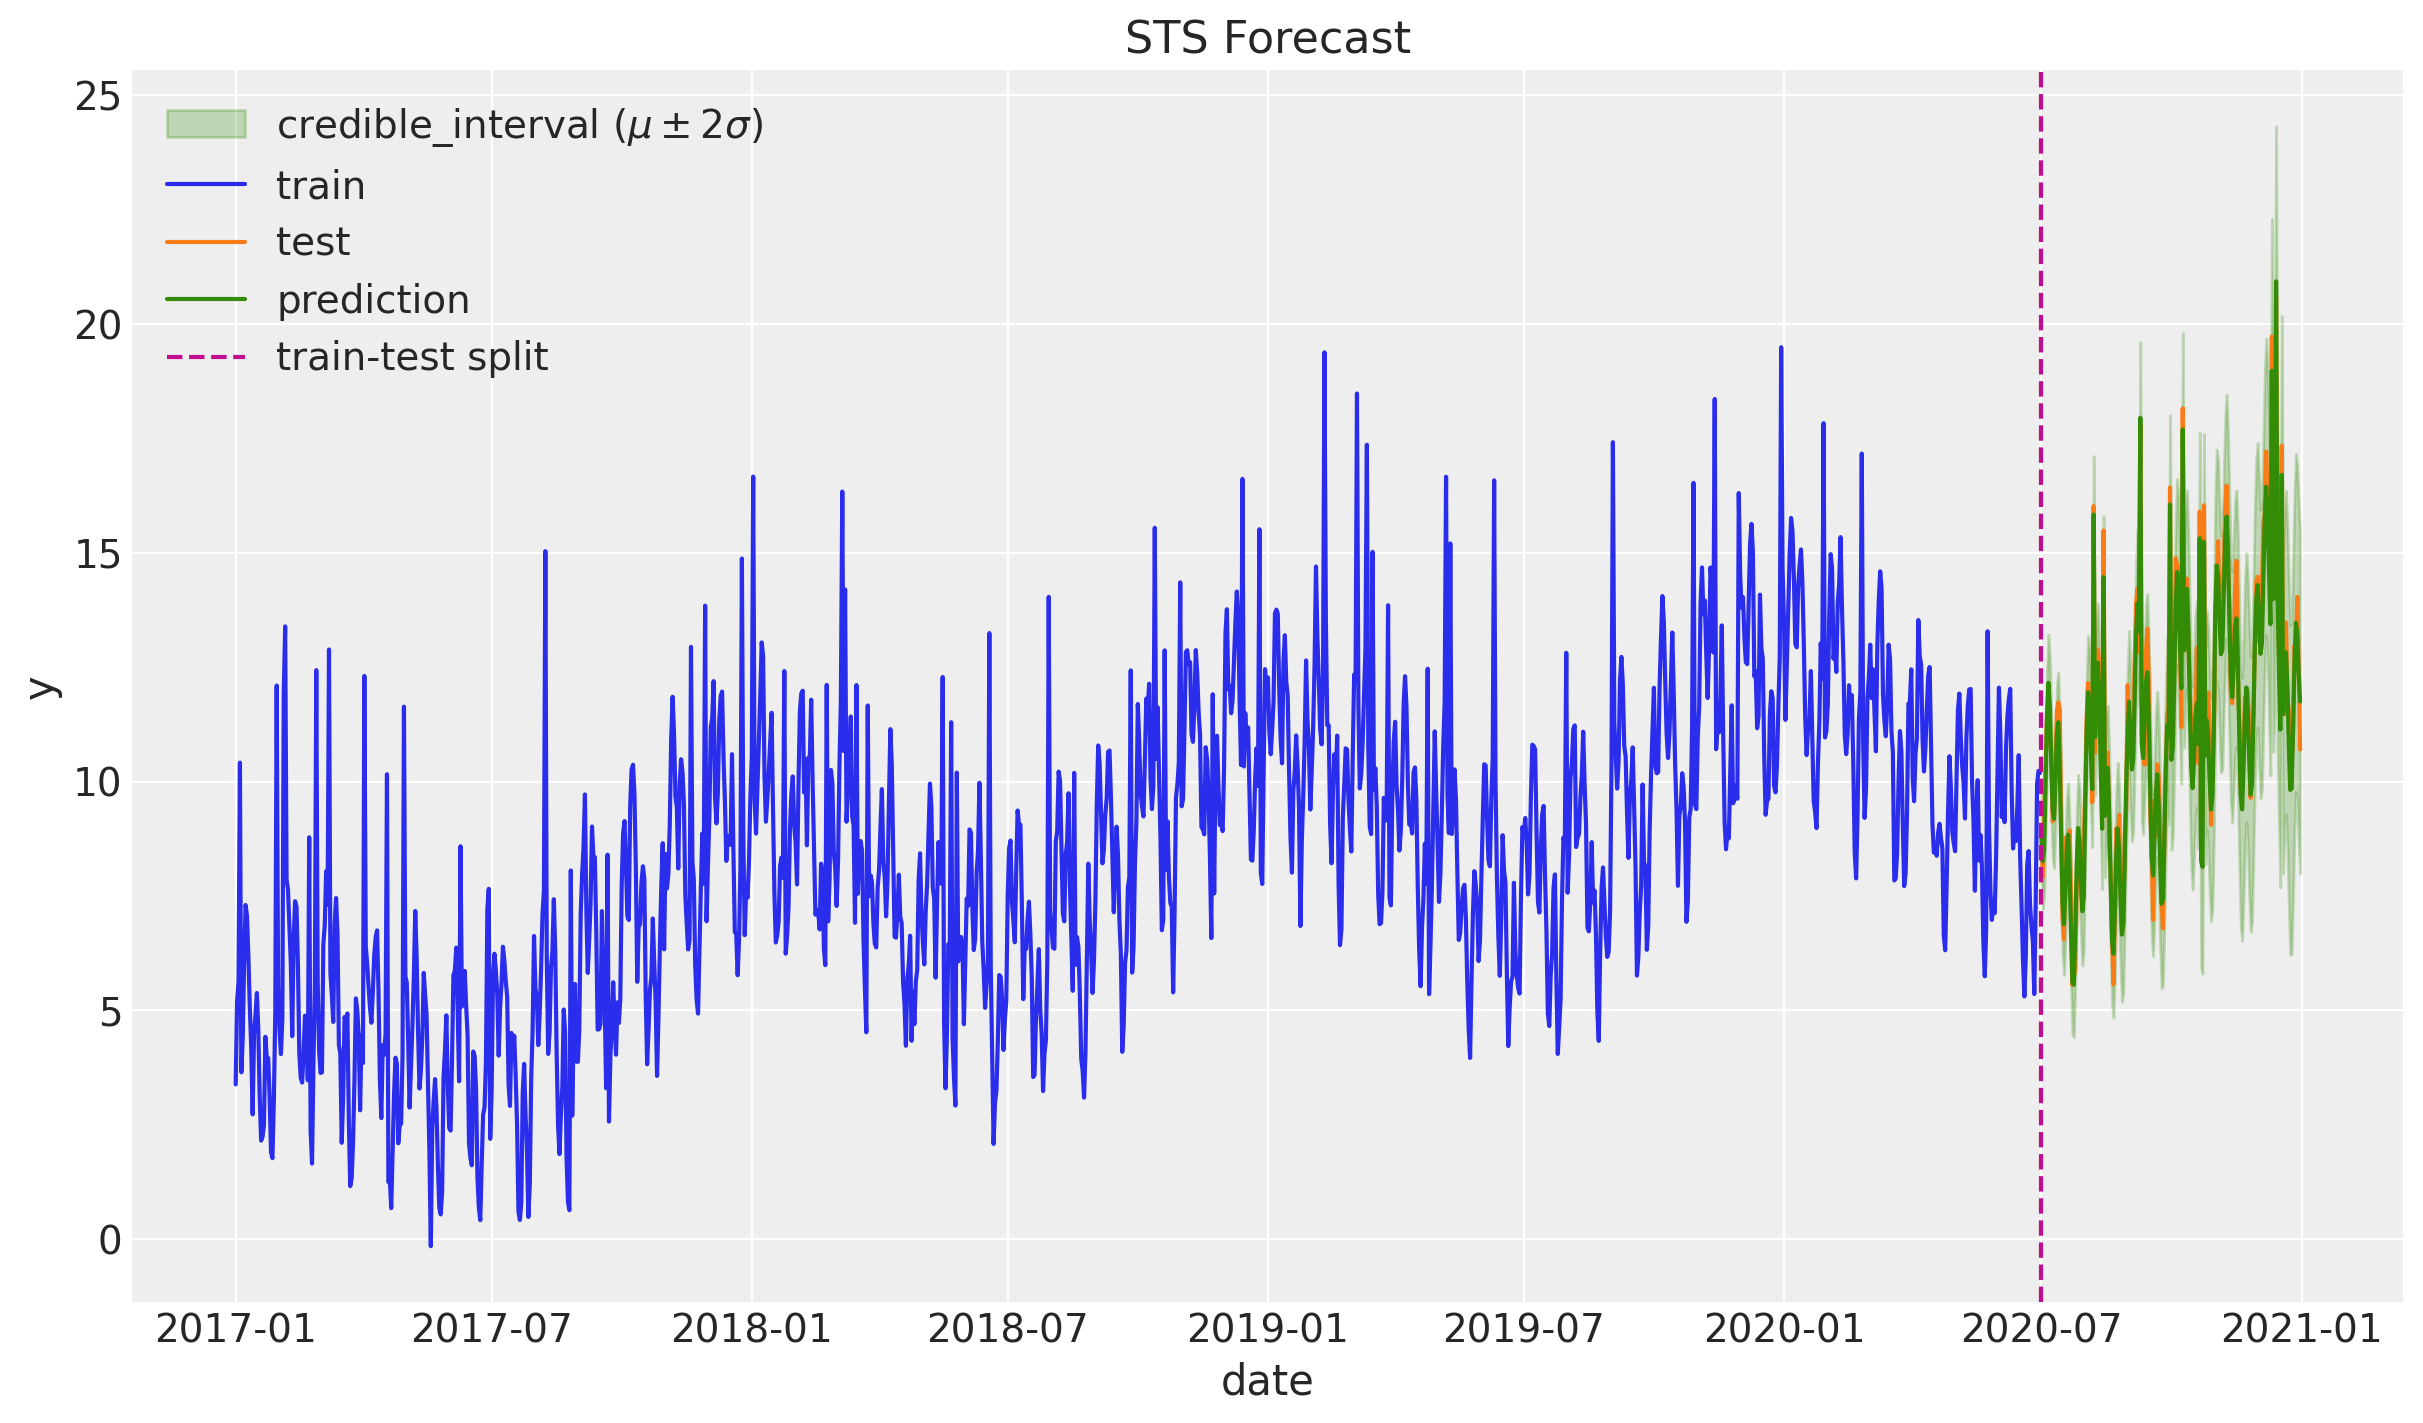

In [45]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test["date"],
    y1=df_test["y_pred"] - 2 * df_test["y_pred_std"],
    y2=df_test["y_pred"] + 2 * df_test["y_pred_std"],
    color="C2",
    alpha=0.25,
    label=r"credible_interval ($\mu \pm 2\sigma$)",
)

sns.lineplot(x="date", y="y", label="train", data=df_train, ax=ax)
sns.lineplot(x="date", y="y", label="test", data=df_test, ax=ax)
sns.lineplot(x="date", y="y_pred", label="prediction", data=df_test, ax=ax)
ax.axvline(x=threshold_date, color="C3", linestyle="--", label="train-test split")
ax.legend(loc="upper left")
ax.set(title="STS Forecast")

Zooming in:

[Text(0.5, 1.0, 'STS Forecast')]

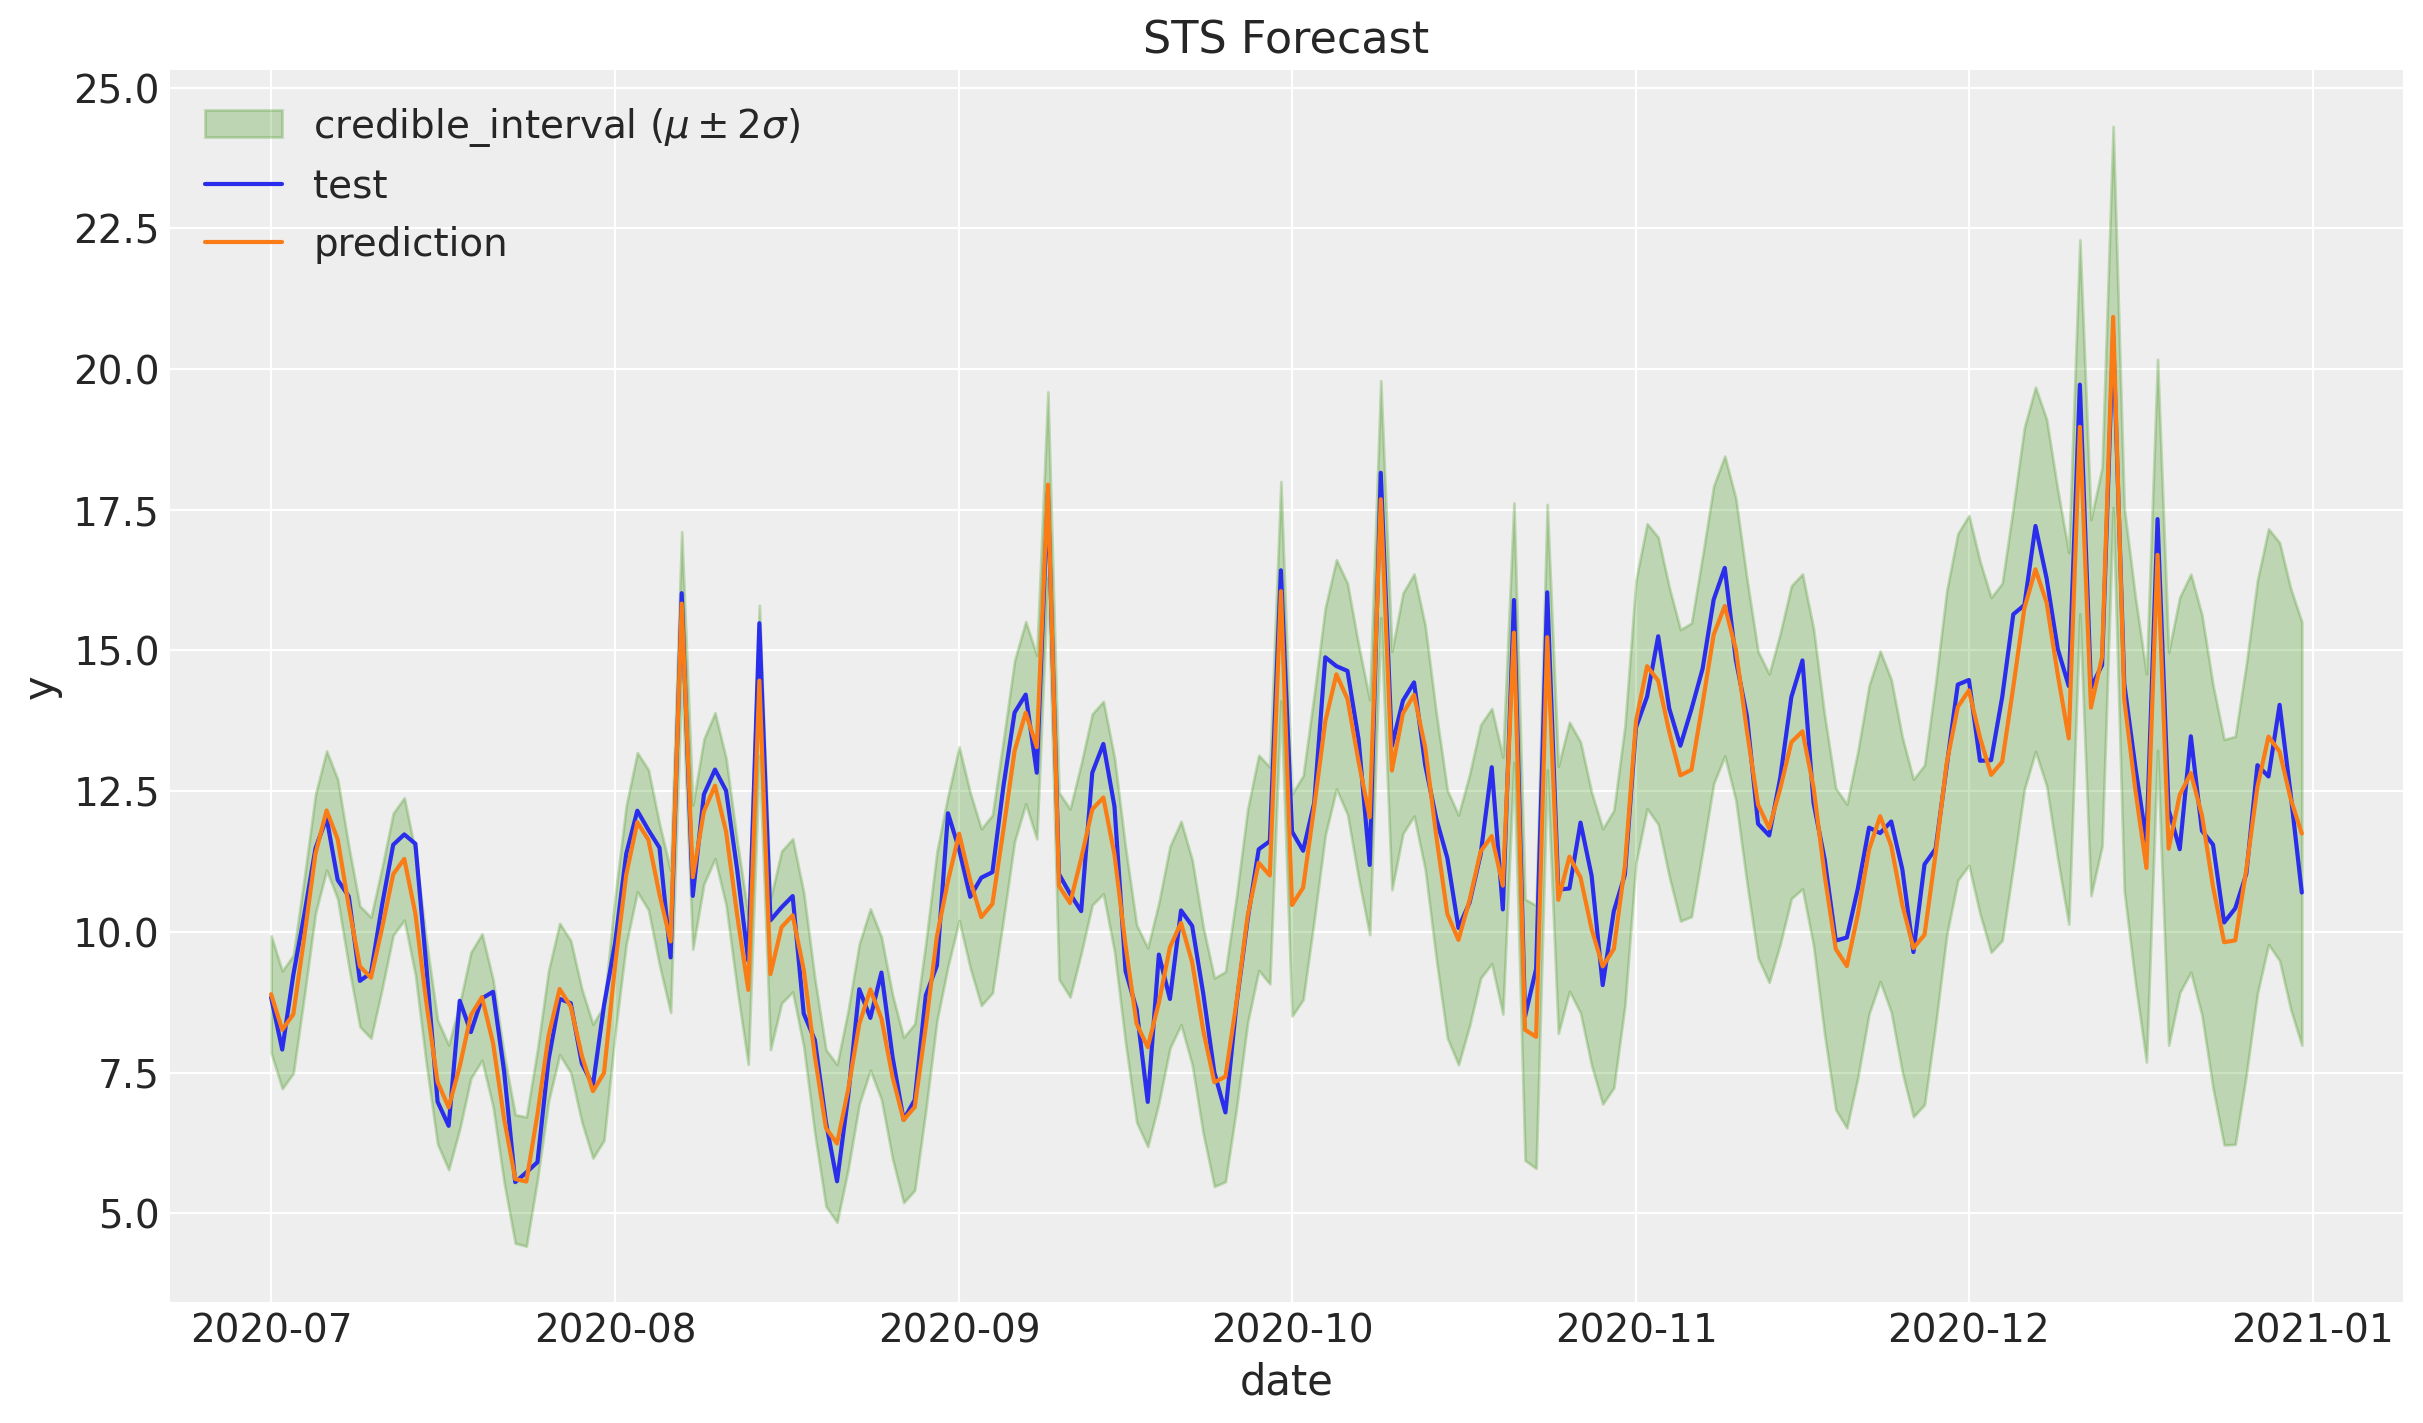

In [46]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test["date"],
    y1=df_test["y_pred"] - 2 * df_test["y_pred_std"],
    y2=df_test["y_pred"] + 2 * df_test["y_pred_std"],
    color="C2",
    alpha=0.25,
    label=r"credible_interval ($\mu \pm 2\sigma$)",
)
sns.lineplot(x="date", y="y", label="test", data=df_test, ax=ax)
sns.lineplot(x="date", y="y_pred", label="prediction", data=df_test, ax=ax)
ax.legend(loc="upper left")
ax.set(title="STS Forecast")

Let us see it as a scatter plot.

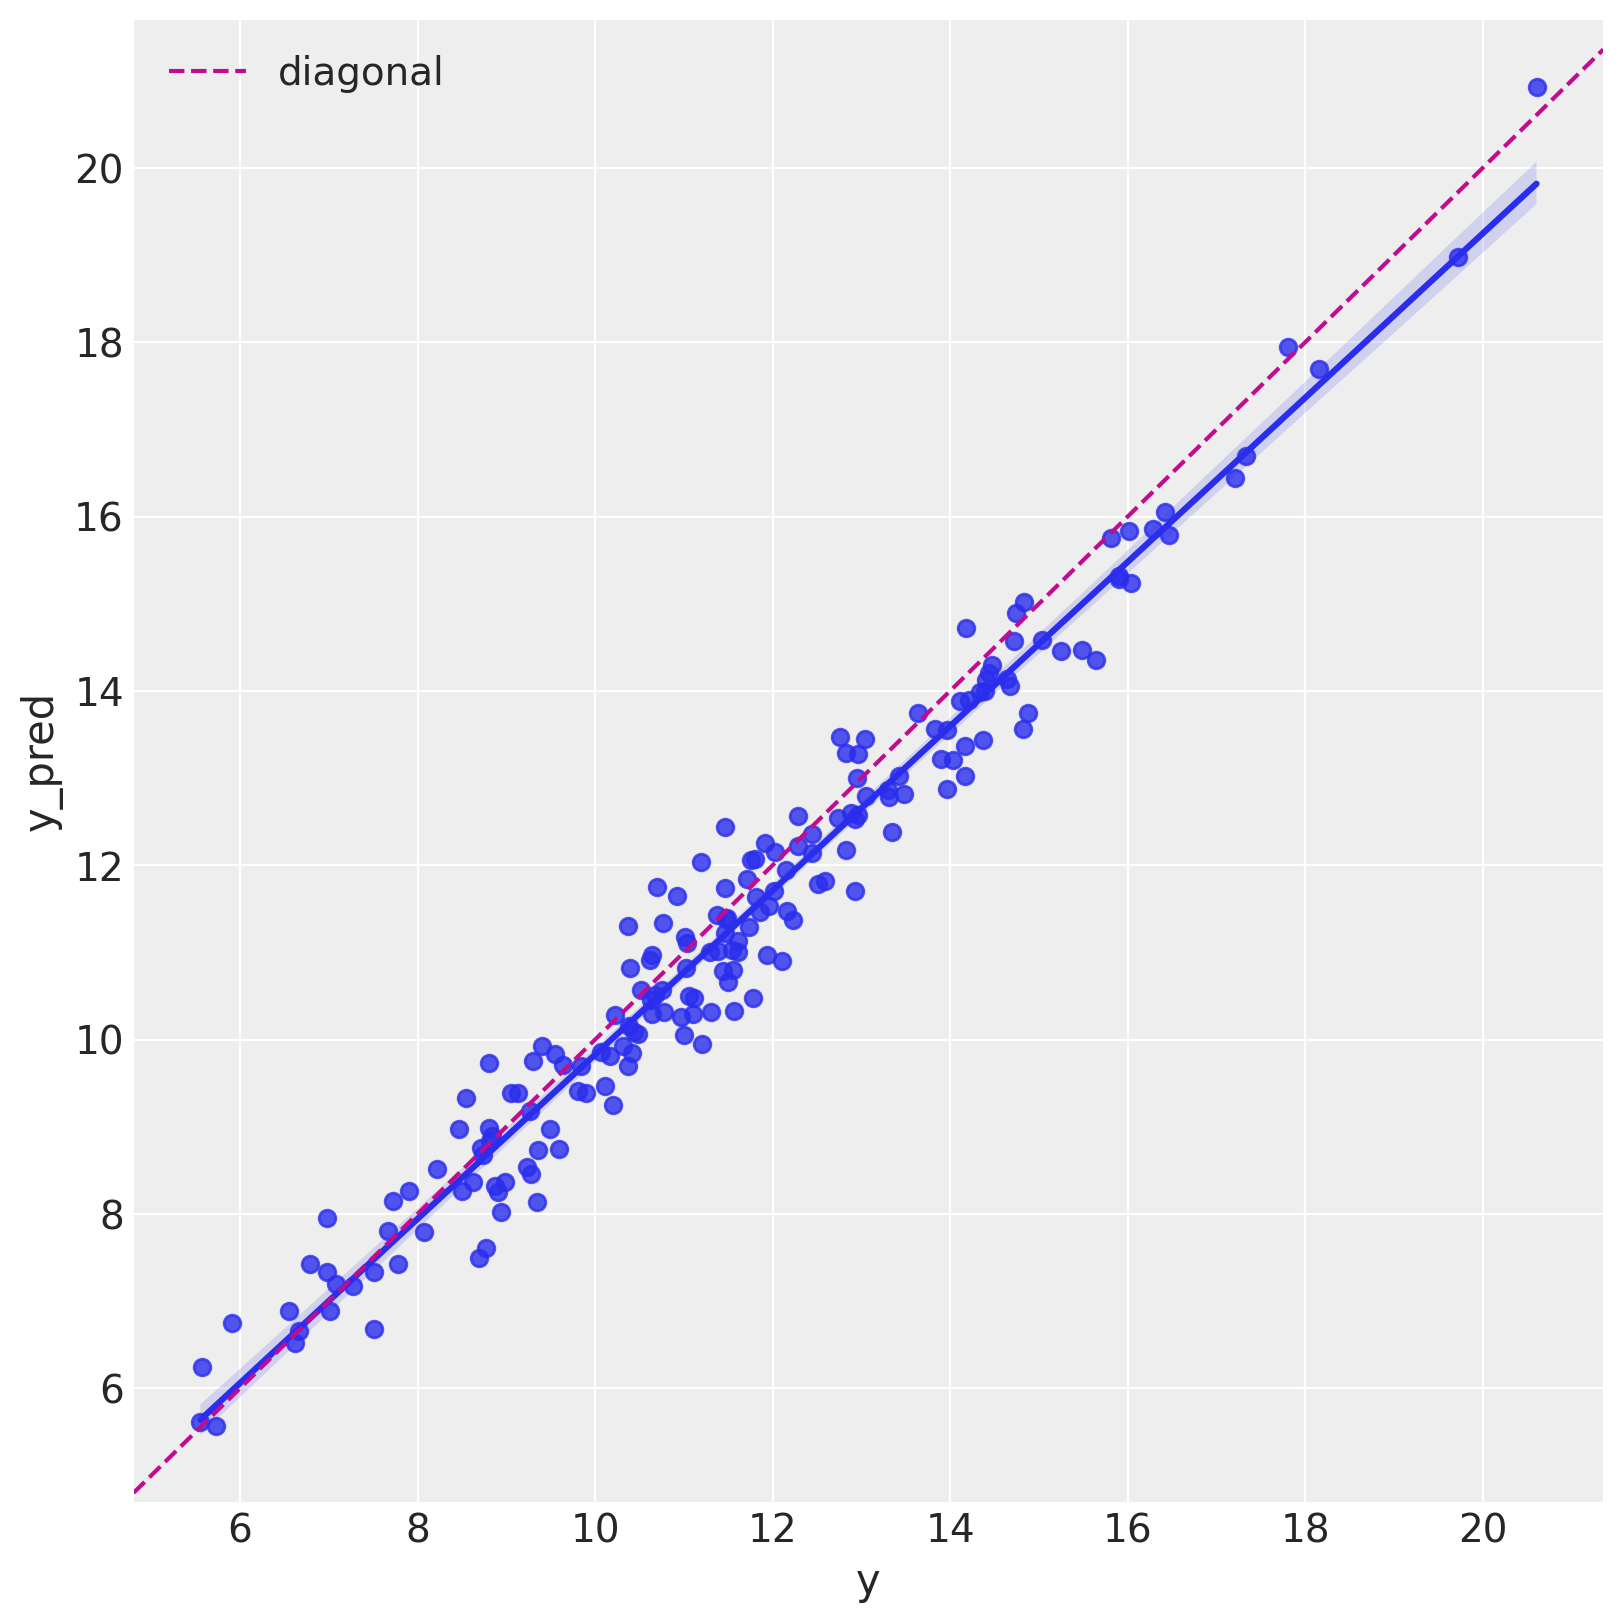

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x="y", y="y_pred", data=df_test, ax=ax)
ax.axline(xy1=(10, 10), slope=1, color="C3", linestyle="--", label="diagonal")
ax.legend()

## Error Analysis

It is important to emphasize that, for any modeling problem, getting the predictions is not the end of the story. It is very important to analyze the errors to understand where is the model not working as expected. 

- Distribution

[Text(0.5, 1.0, 'Model Errors (Test Set)')]

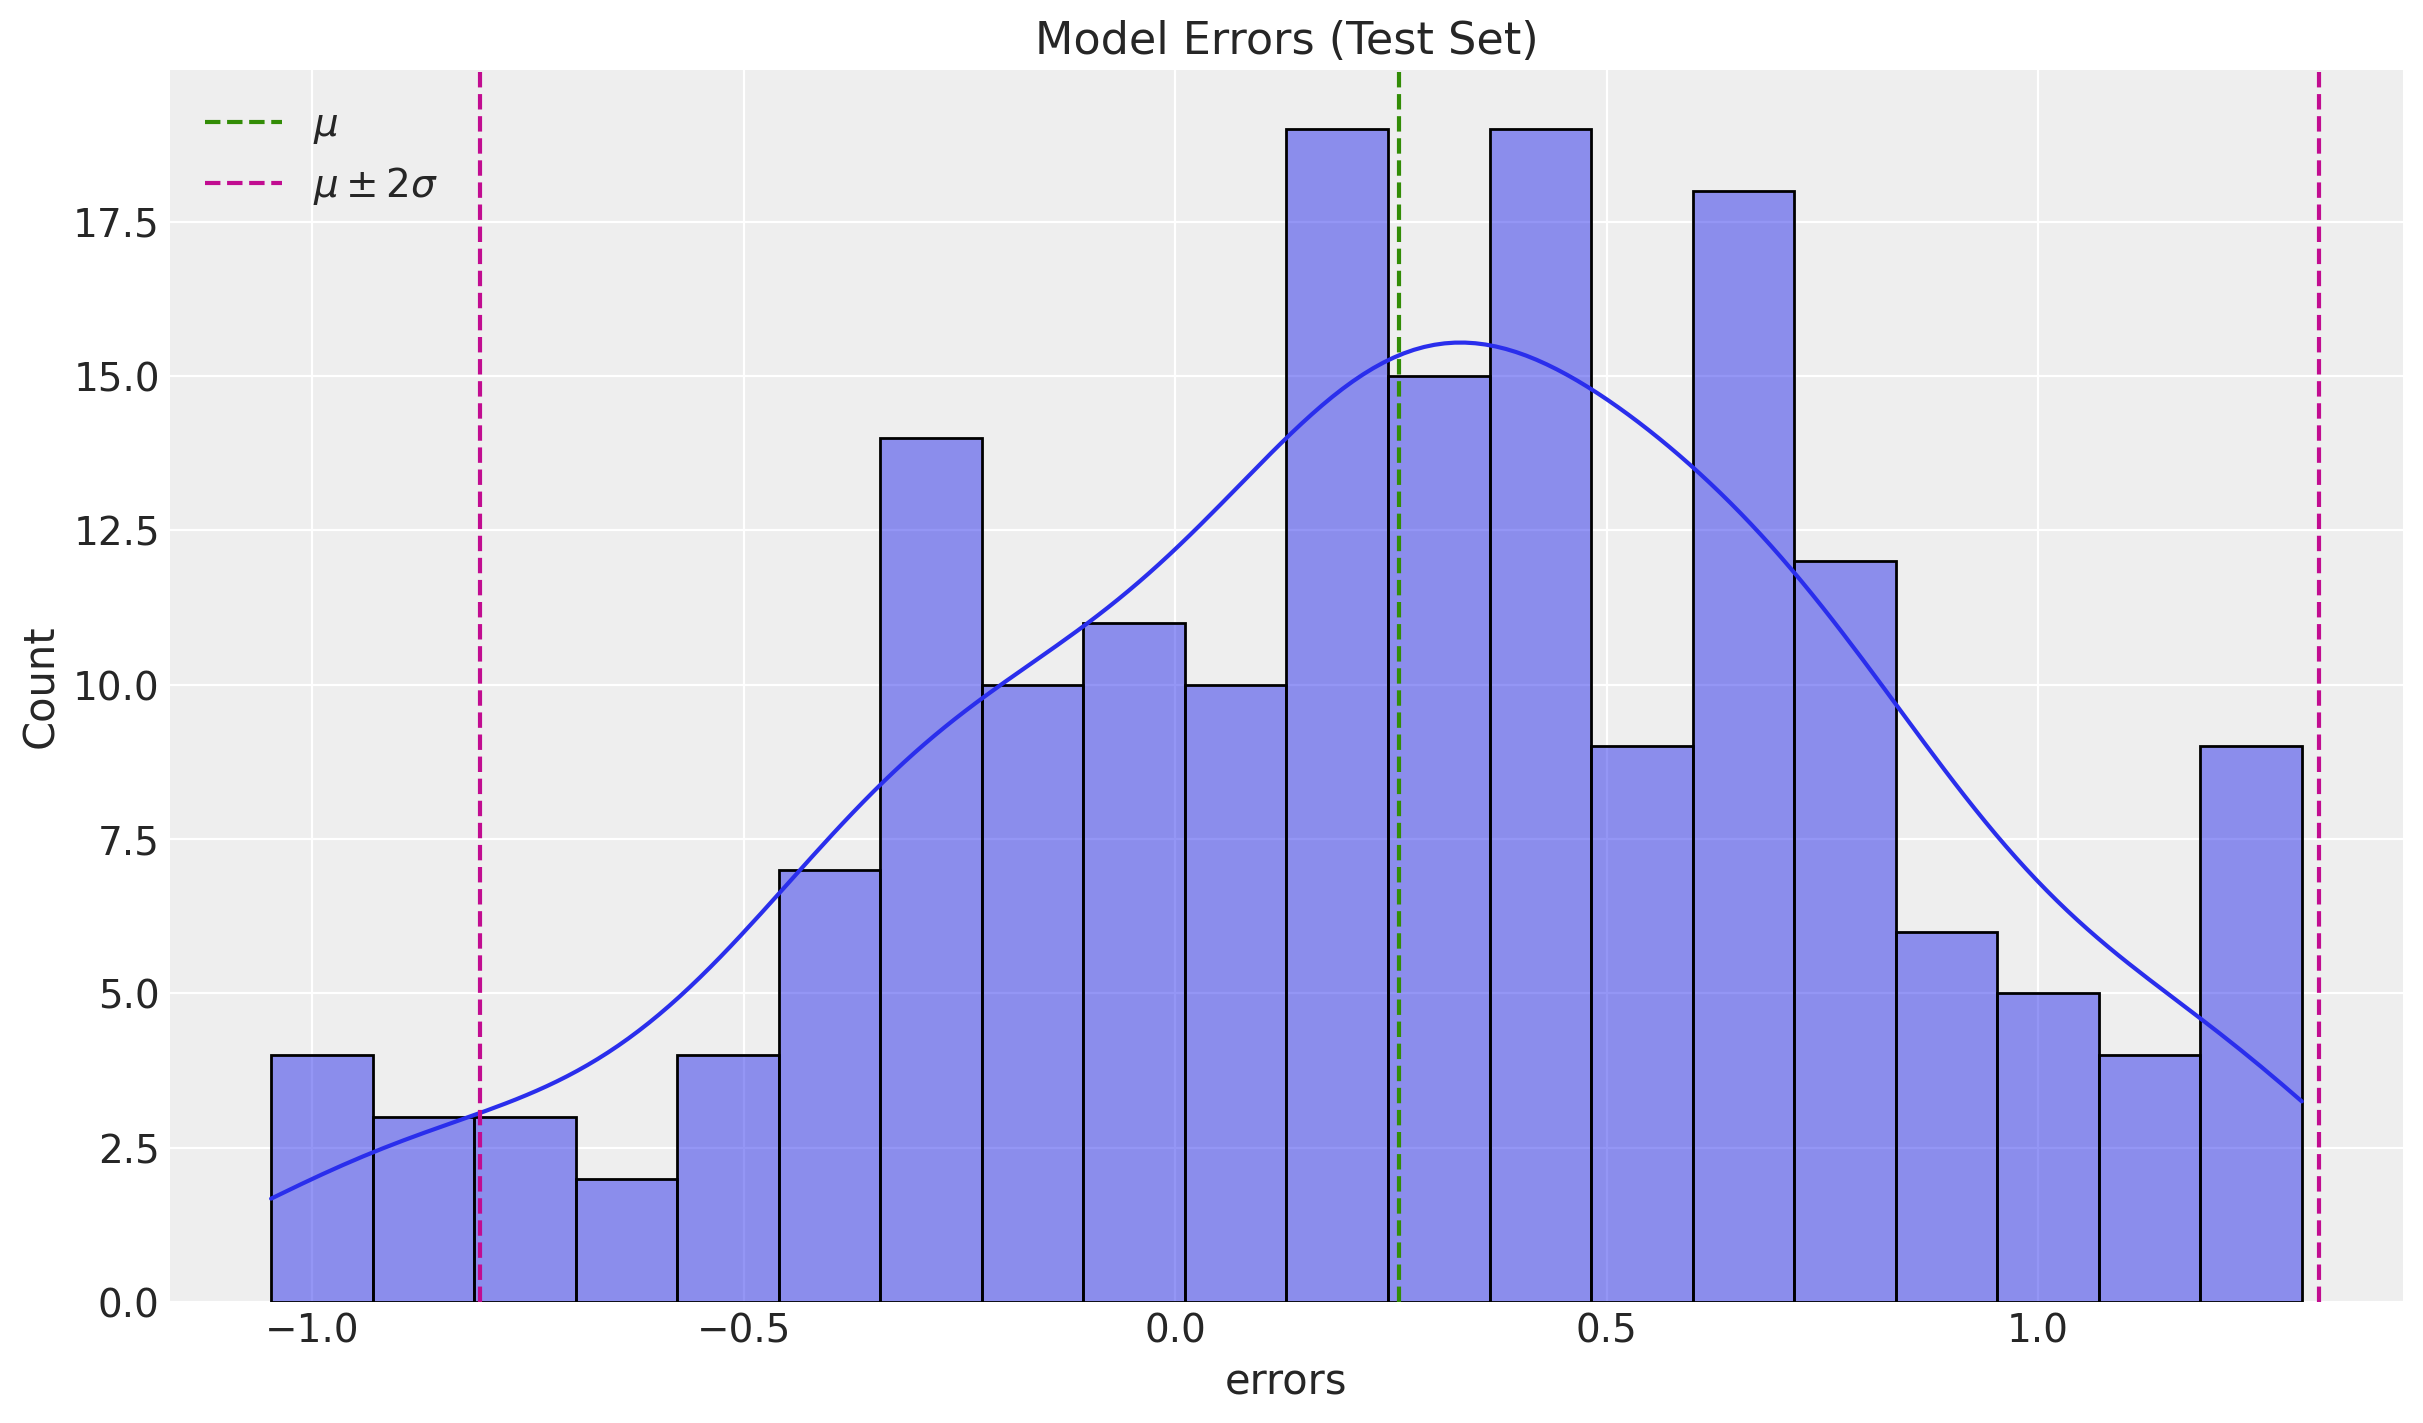

In [48]:
errors_mean = df_test["errors"].mean()
errors_std = df_test["errors"].std()

fig, ax = plt.subplots()

sns.histplot(x=df_test["errors"], bins=20, kde=True, ax=ax)
ax.axvline(x=errors_mean, color="C2", linestyle="--", label=r"$\mu$")
ax.axvline(
    x=errors_mean + 2 * errors_std,
    color="C3",
    linestyle="--",
    label=r"$\mu \pm 2\sigma$",
)
ax.axvline(x=errors_mean - 2 * errors_std, color="C3", linestyle="--")
ax.legend()
ax.set(title="Model Errors (Test Set)")

The errors look normally distributed and centered around zero. 

- Autocorrelation

[Text(0.5, 1.0, 'Model Errors (Test Set)')]

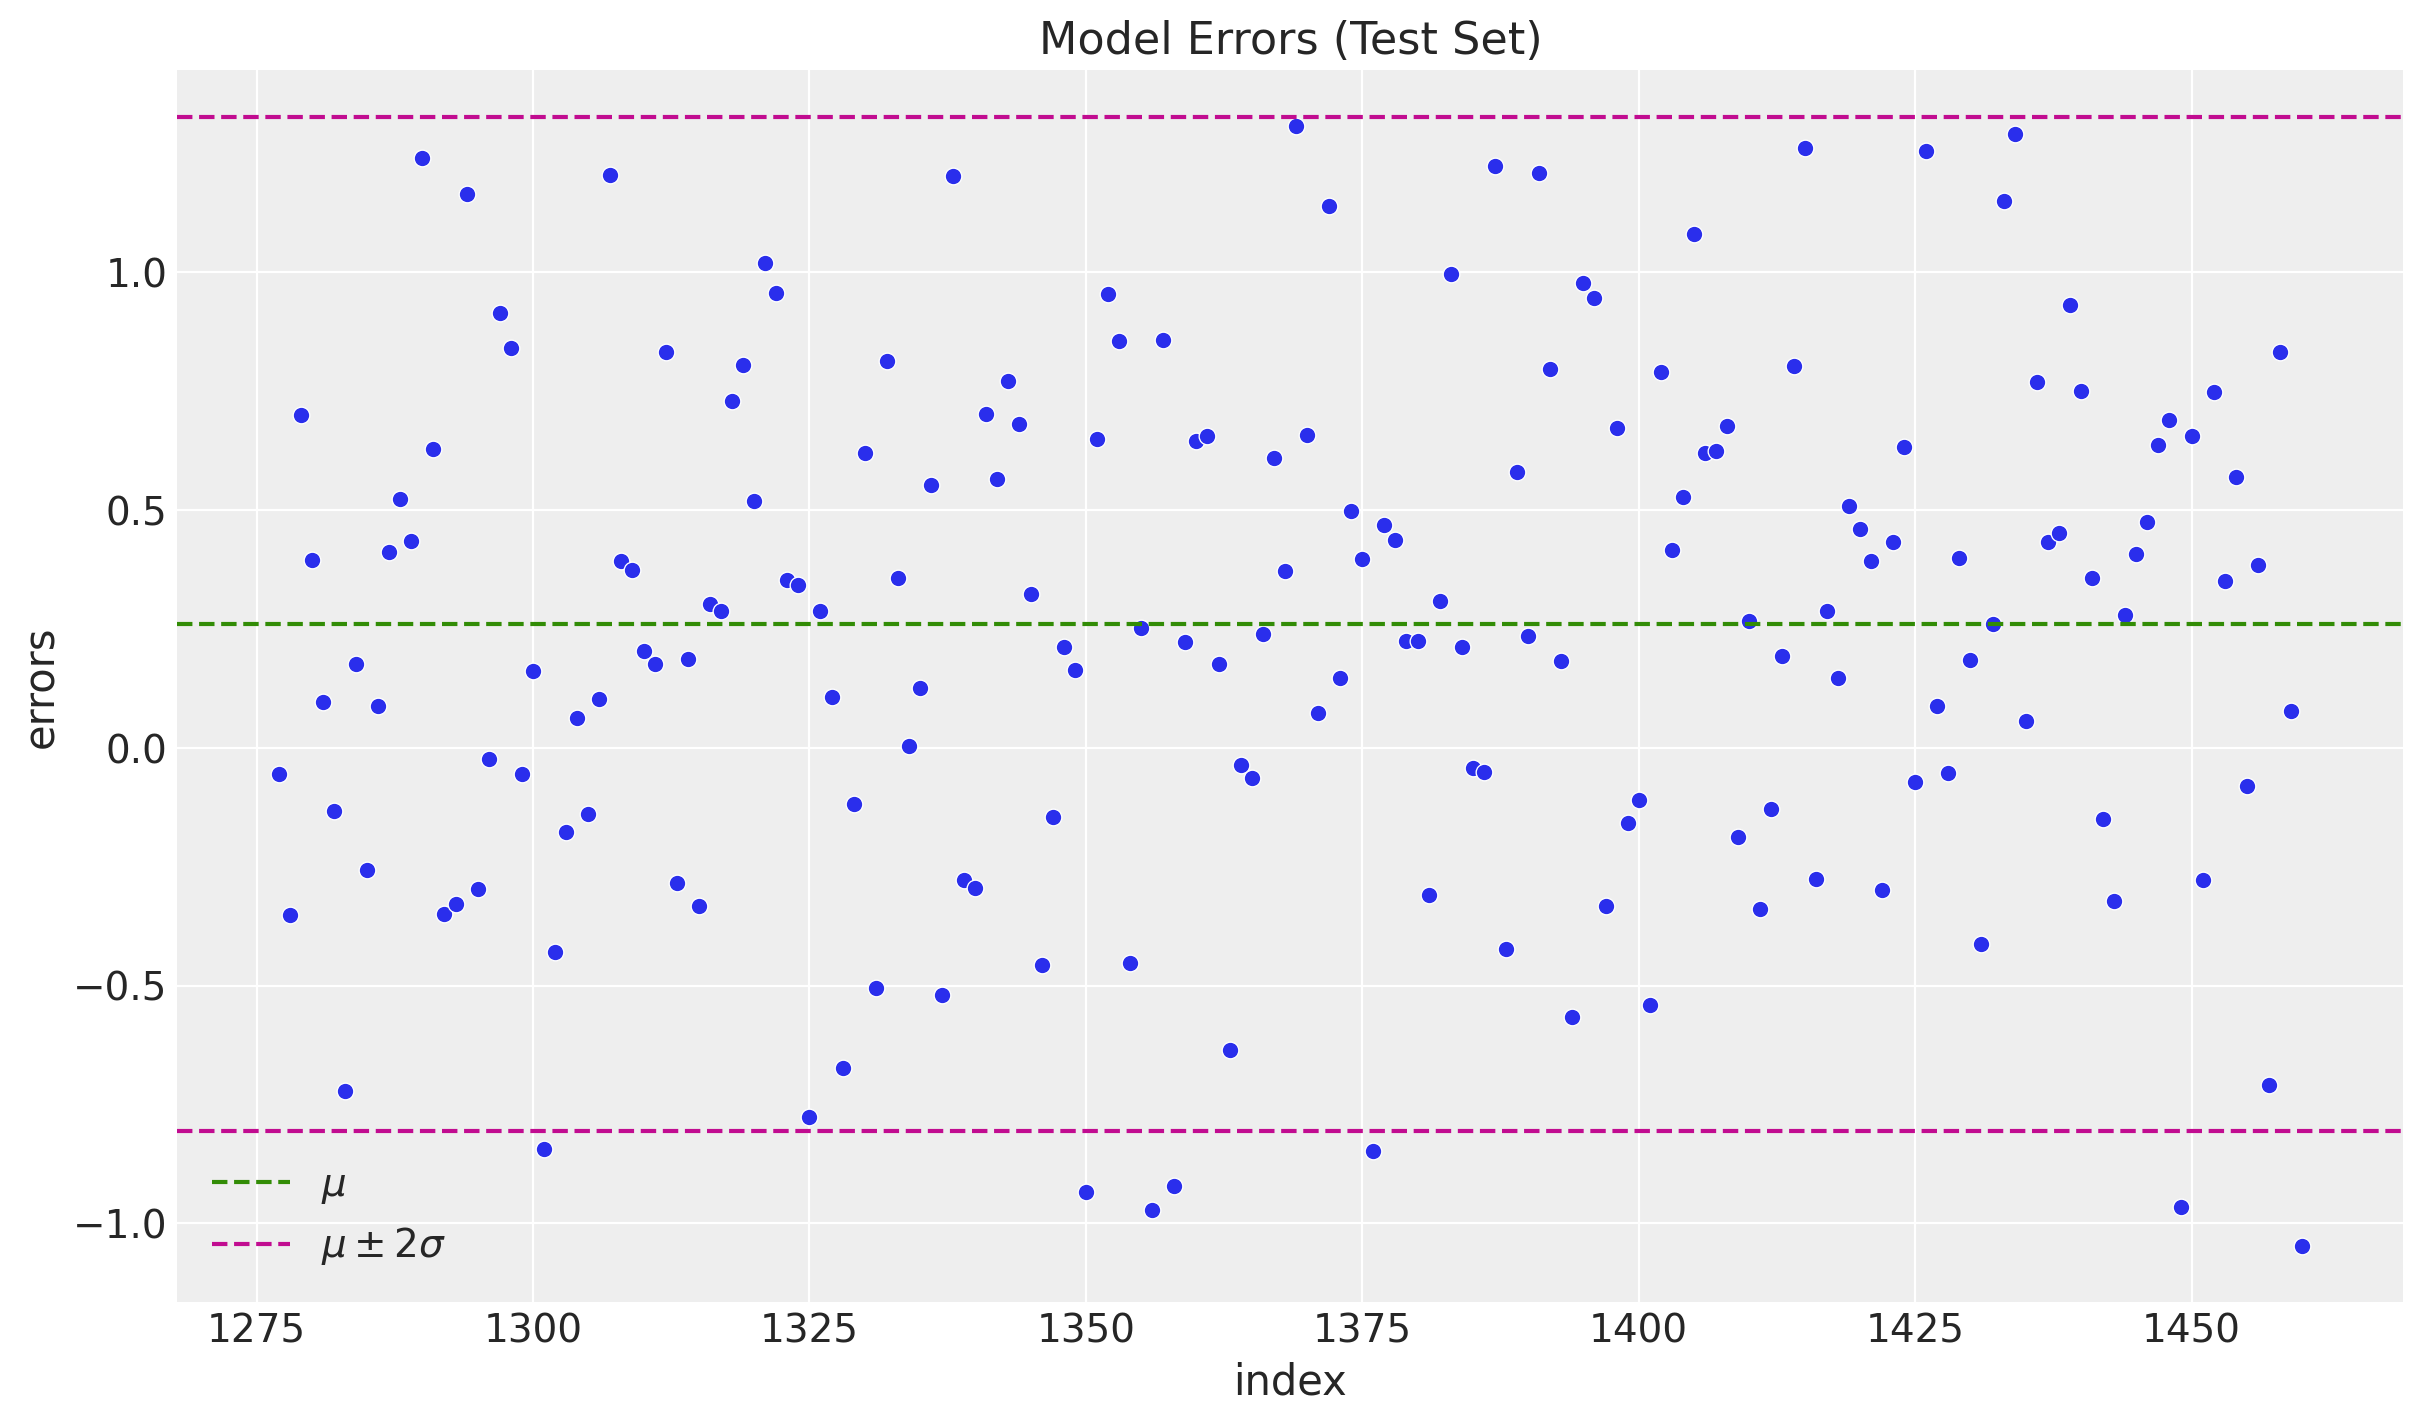

In [49]:
fig, ax = plt.subplots()

sns.scatterplot(x="index", y="errors", data=df_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color="C2", linestyle="--", label=r"$\mu$ ")
ax.axhline(
    y=errors_mean + 2 * errors_std,
    color="C3",
    linestyle="--",
    label=r"$\mu \pm 2\sigma$",
)
ax.axhline(y=errors_mean - 2 * errors_std, color="C3", linestyle="--")
ax.legend()
ax.set(title="Model Errors (Test Set)")

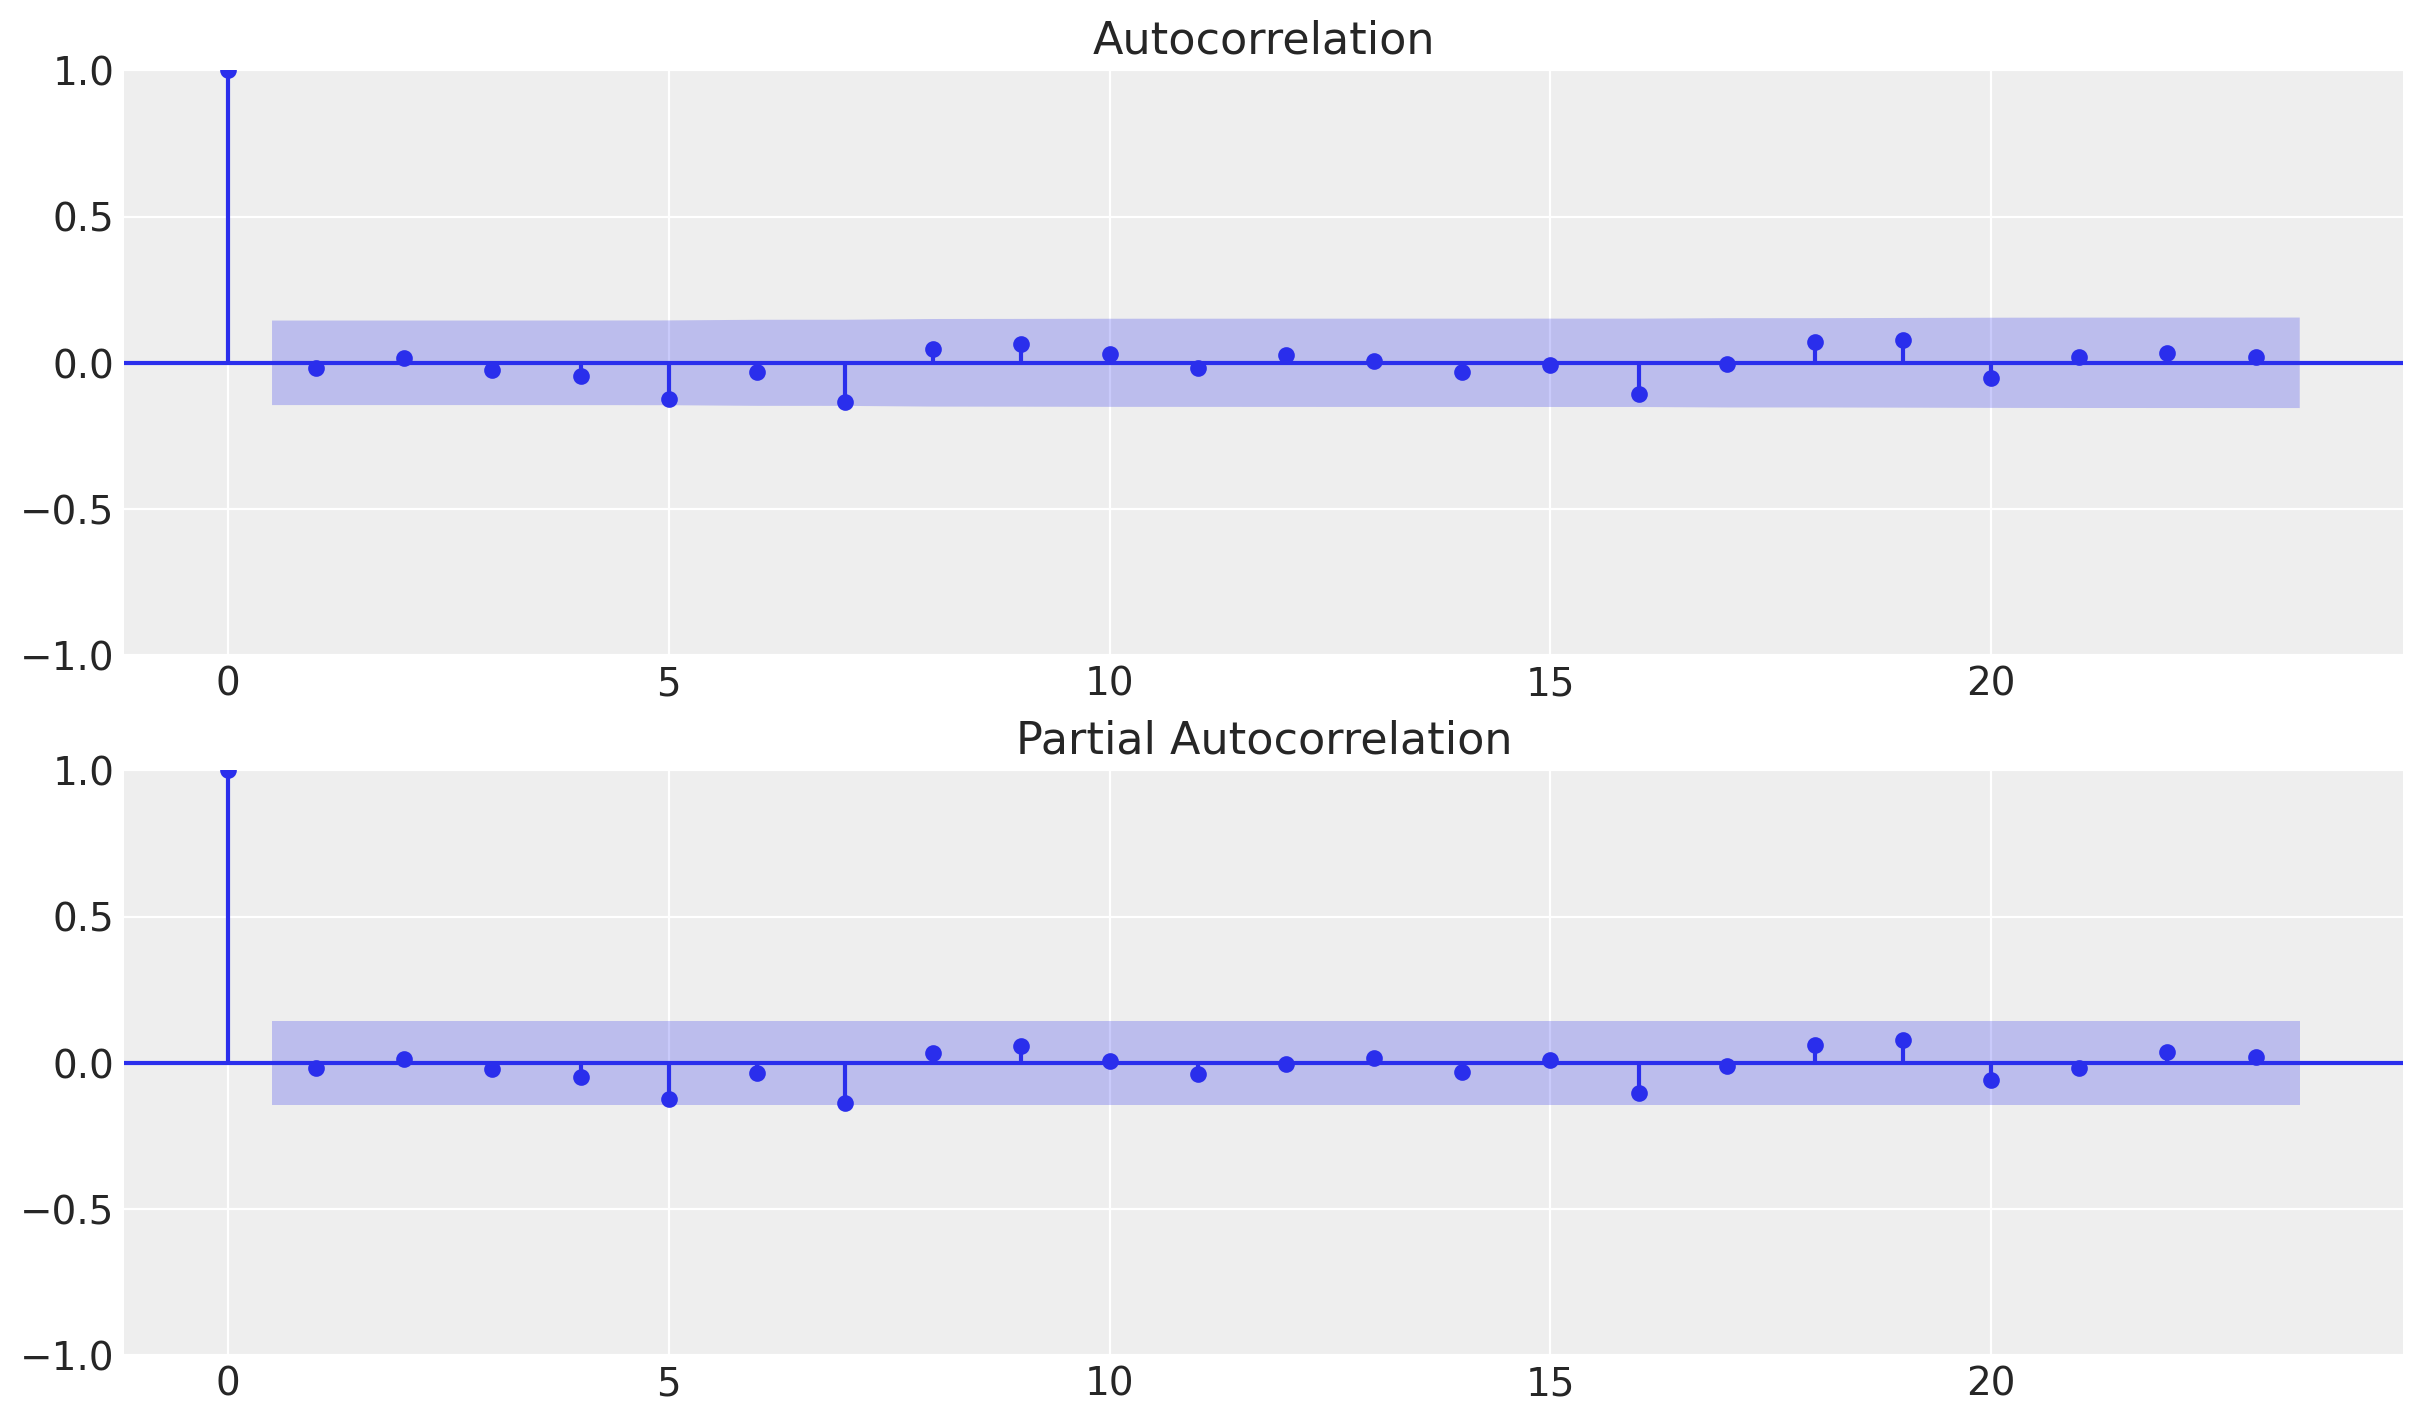

In [50]:
fig, ax = plt.subplots(2, 1)
_ = plot_acf(x=df_test["errors"], ax=ax[0])
_ = plot_pacf(x=df_test["errors"], ax=ax[1])

We do not see any significant (partial) autocorrelation nor patterns on the errors. They look independent and normally distributed around zero. 

## Model Fit Decomposition

Finally, let us see the individual model components.

In [51]:
component_dists = tfp.sts.decompose_by_component(
    model=toy_model, observed_time_series=df_train["y"], parameter_samples=q_samples
)

In [52]:
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()},
)

Text(0.5, 1.02, 'Model Components')

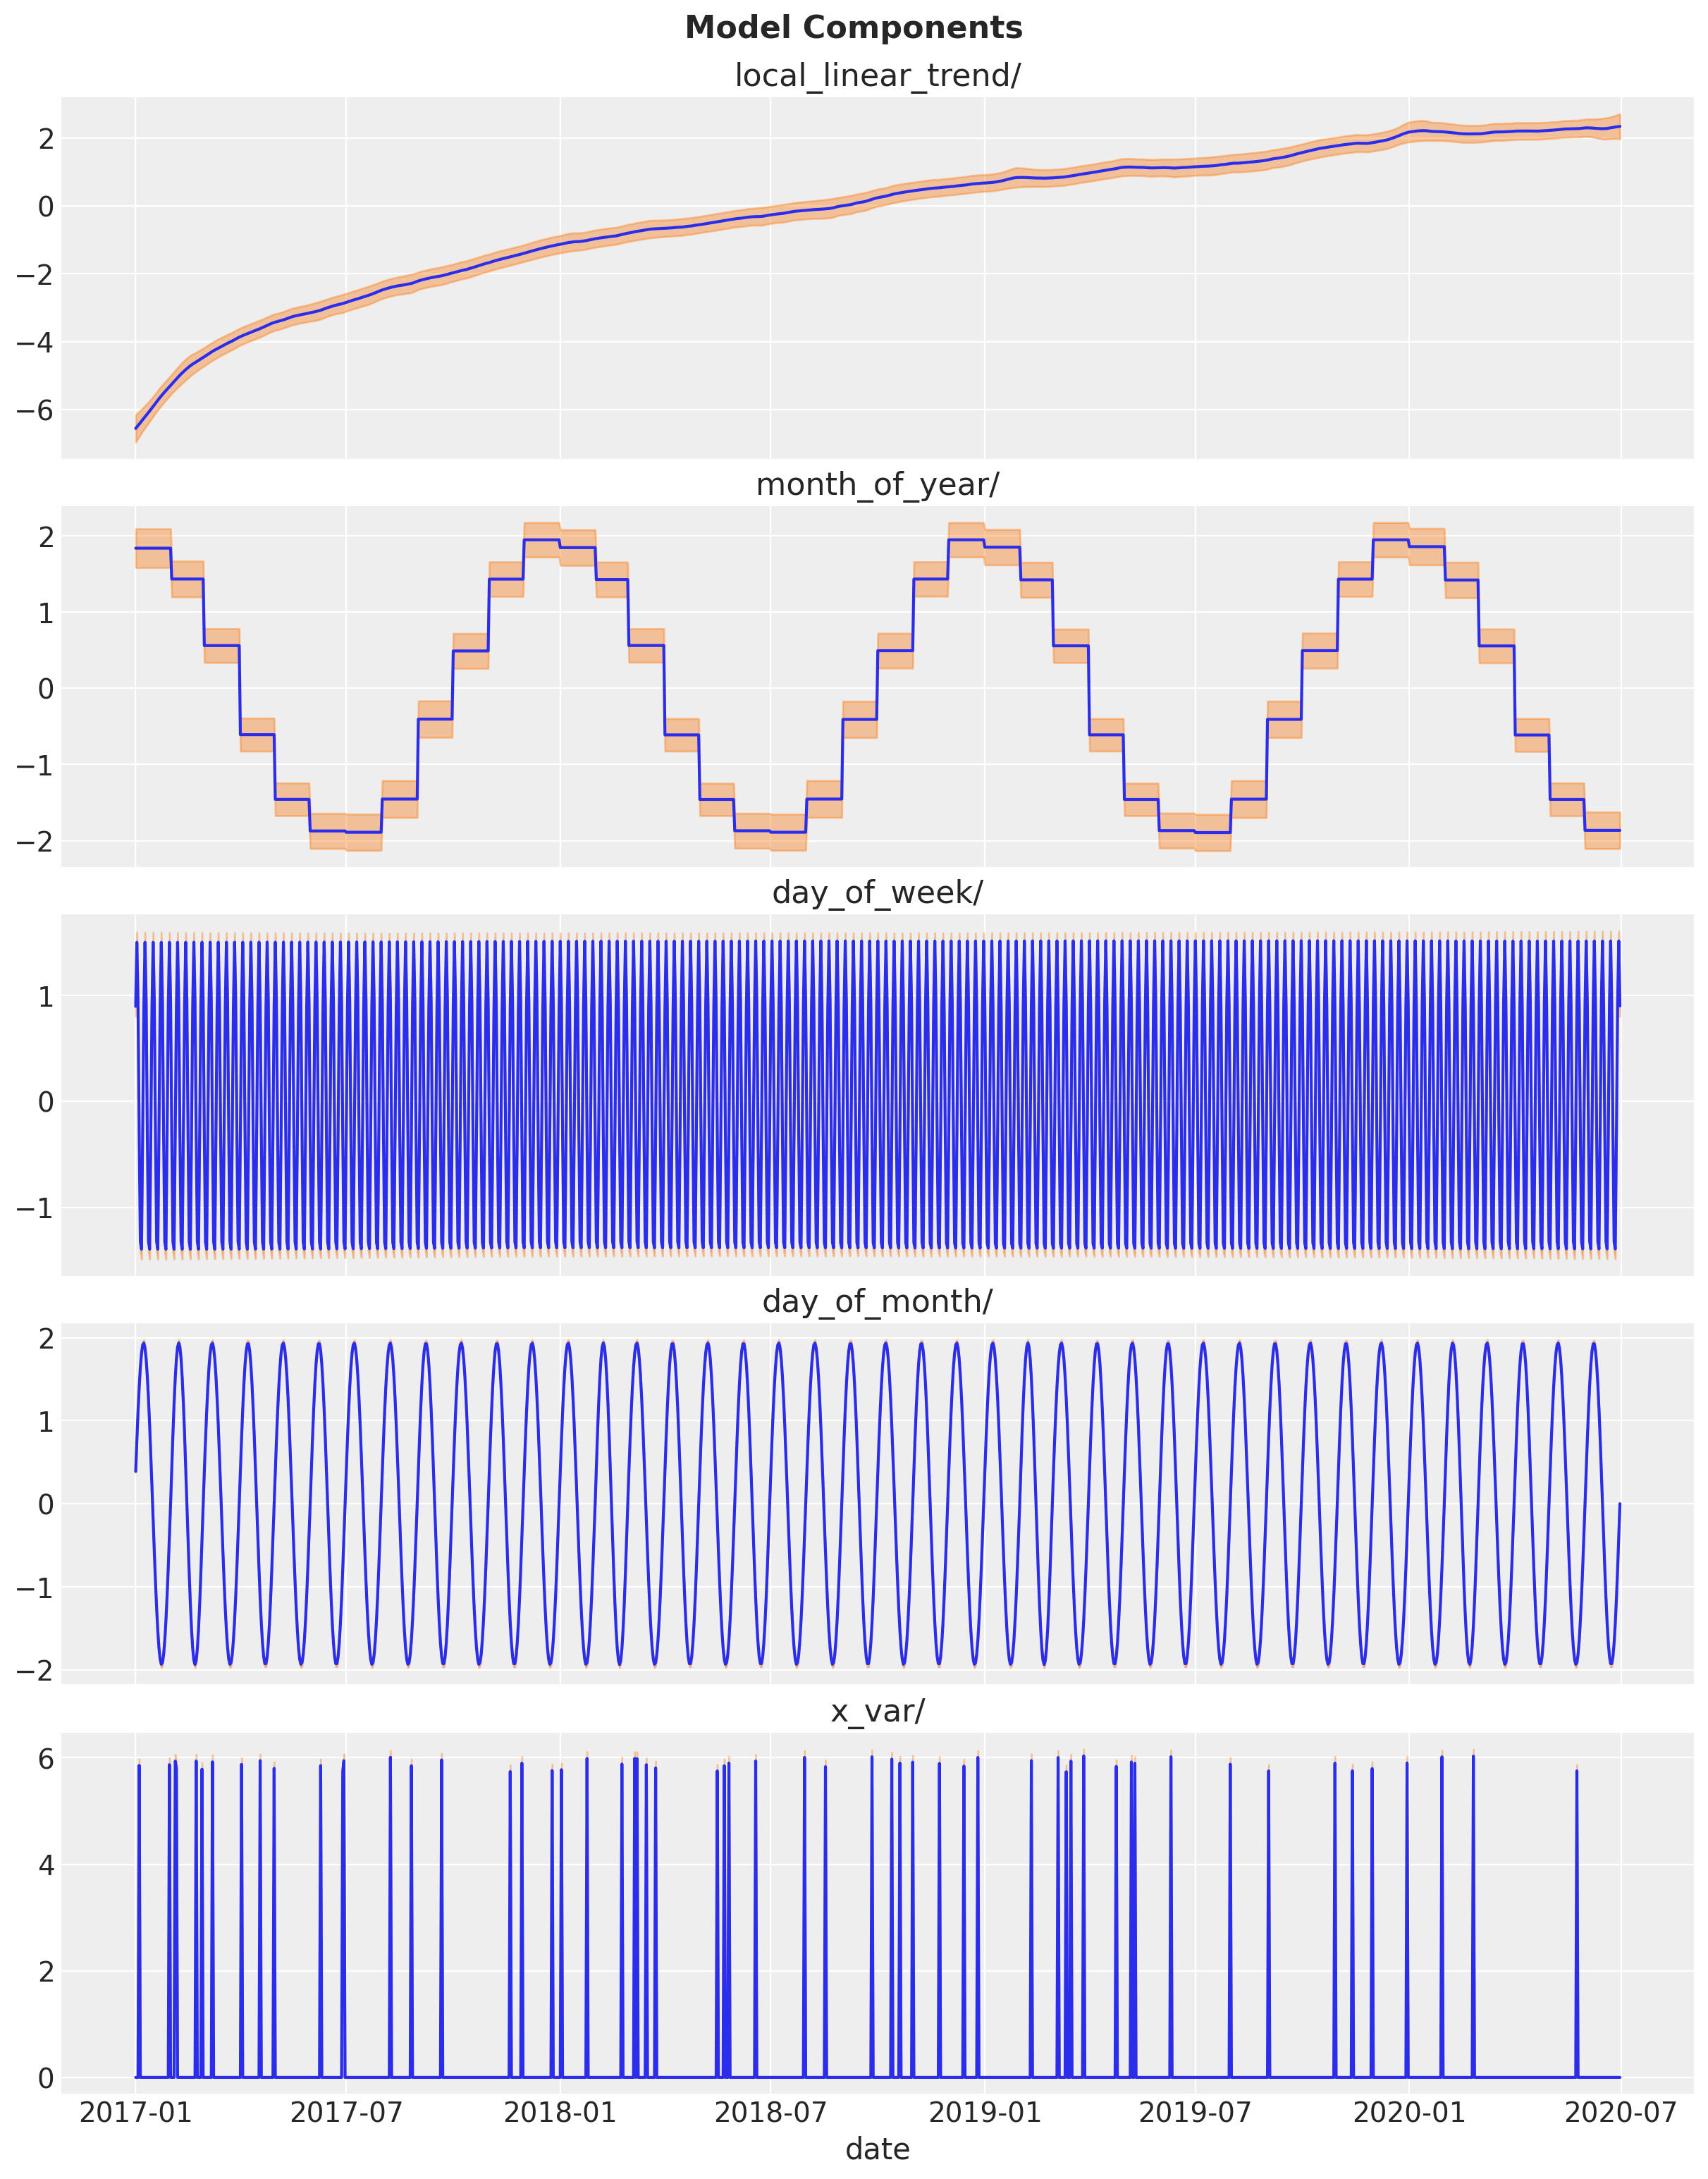

In [53]:
num_components = len(component_means)

fig, ax = plt.subplots(
    nrows=num_components,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]

    sns.lineplot(x=df_train["date"], y=component_mean, color="C0", ax=ax[i])

    ax[i].fill_between(
        x=df_train["date"],
        y1=component_mean - 2 * component_stddev,
        y2=component_mean + 2 * component_stddev,
        alpha=0.4,
        color="C1",
    )

    ax[i].set(title=component_name)

fig.suptitle("Model Components", fontweight="bold", fontsize=16, y=1.02)

---
This was a first exploration of the [STS TensorFlow Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) module. We emphasized on the time series exploratory analysis since, in real applications, we are never given the time series structure prior modeling (that would be quite boring). I really want to keep exploring the tools and techniques implemented in this probabilistic programming framework. 